## Problem Statement


### Business Context

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.).

## Objective

“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 20000 observations in the training set and 5000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators could be repaired before failing/breaking to reduce the overall maintenance cost.
The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model. These will result in repairing costs.
- False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
- False positives (FP) are detections where there is no failure. These will result in inspection costs.

It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variables should be considered as “failure” and “0” represents “No failure”.

## Data Description

- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models.
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable


## Importing necessary libraries


In [23]:
# Libraries for reading and manipulating data
import pandas as pd
import numpy as np

# Libaries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics and scoring
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score)

from sklearn import metrics

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# Tool to impute missing values
from sklearn.impute import SimpleImputer

# Tool to oversample/undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Tool for hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# Tools for pipeline creation and personalization
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Define maxiumum displayed rows and columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)


# Classifiers for model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier)

from xgboost import XGBClassifier

# Suppress scientific notations
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")
PYDEVD_WARN_SLOW_RESOLVE_TIMEOUT=7

## Loading the dataset


In [24]:
# read the data sets 
df = pd.read_csv("Train.csv.csv")
df_test = pd.read_csv("Test.csv.csv")

## Data Overview


- Observations
- Sanity checks


In [25]:
# Display the number of rows and columns
df.shape

(20000, 41)

In [26]:
# Display the number of rows and columns
df_test.shape

(5000, 41)

####Observations

- There are 20,000 rows and 41 columns in the train set.
- There are 5,000 rows and 41 columns in the test set.


In [27]:
# Create a copy of the training data
data_train = df.copy()

In [28]:
# Create a copy of the test data
data_test = df_test.copy()

In [29]:
# Display the first 5 rows
data_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-4.465,-4.679,3.102,0.506,-0.221,-2.033,-2.911,0.051,-1.522,3.762,-5.715,0.736,0.981,1.418,-3.376,-3.047,0.306,2.914,2.270,4.395,-2.388,0.646,-1.191,3.133,0.665,-2.511,-0.037,0.726,-3.982,-1.073,1.667,3.060,-1.690,2.846,2.235,6.667,0.444,-2.369,2.951,-3.480,0
1,3.366,3.653,0.910,-1.368,0.332,2.359,0.733,-4.332,0.566,-0.101,1.914,-0.951,-1.255,-2.707,0.193,-4.769,-2.205,0.908,0.757,-5.834,-3.065,1.597,-1.757,1.766,-0.267,3.625,1.500,-0.586,0.783,-0.201,0.025,-1.795,3.033,-2.468,1.895,-2.298,-1.731,5.909,-0.386,0.616,0
2,-3.832,-5.824,0.634,-2.419,-1.774,1.017,-2.099,-3.173,-2.082,5.393,-0.771,1.107,1.144,0.943,-3.164,-4.248,-4.039,3.689,3.311,1.059,-2.143,1.650,-1.661,1.680,-0.451,-4.551,3.739,1.134,-2.034,0.841,-1.600,-0.257,0.804,4.086,2.292,5.361,0.352,2.940,3.839,-4.309,0
3,1.618,1.888,7.046,-1.147,0.083,-1.530,0.207,-2.494,0.345,2.119,-3.053,0.460,2.705,-0.636,-0.454,-3.174,-3.404,-1.282,1.582,-1.952,-3.517,-1.206,-5.628,-1.818,2.124,5.295,4.748,-2.309,-3.963,-6.029,4.949,-3.584,-2.577,1.364,0.623,5.550,-1.527,0.139,3.101,-1.277,0
4,-0.111,3.872,-3.758,-2.983,3.793,0.545,0.205,4.849,-1.855,-6.220,1.998,4.724,0.709,-1.989,-2.633,4.184,2.245,3.734,-6.313,-5.380,-0.887,2.062,9.446,4.490,-3.945,4.582,-8.780,-3.383,5.107,6.788,2.044,8.266,6.629,-10.069,1.223,-3.230,1.687,-2.164,-3.645,6.510,0


In [30]:
# Display the first 5 rows
data_test.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-0.613,-3.820,2.202,1.300,-1.185,-4.496,-1.836,4.723,1.206,-0.342,-5.123,1.017,4.819,3.269,-2.984,1.387,2.032,-0.512,-1.023,7.339,-2.242,0.155,2.054,-2.772,1.851,-1.789,-0.277,-1.255,-3.833,-1.505,1.587,2.291,-5.411,0.870,0.574,4.157,1.428,-10.511,0.455,-1.448,0
1,0.390,-0.512,0.527,-2.577,-1.017,2.235,-0.441,-4.406,-0.333,1.967,1.797,0.410,0.638,-1.390,-1.883,-5.018,-3.827,2.418,1.762,-3.242,-3.193,1.857,-1.708,0.633,-0.588,0.084,3.014,-0.182,0.224,0.865,-1.782,-2.475,2.494,0.315,2.059,0.684,-0.485,5.128,1.721,-1.488,0
2,-0.875,-0.641,4.084,-1.590,0.526,-1.958,-0.695,1.347,-1.732,0.466,-4.928,3.565,-0.449,-0.656,-0.167,-1.630,2.292,2.396,0.601,1.794,-2.120,0.482,-0.841,1.790,1.874,0.364,-0.169,-0.484,-2.119,-2.157,2.907,-1.319,-2.997,0.460,0.620,5.632,1.324,-1.752,1.808,1.676,0
3,0.238,1.459,4.015,2.534,1.197,-3.117,-0.924,0.269,1.322,0.702,-5.578,-0.851,2.591,0.767,-2.391,-2.342,0.572,-0.934,0.509,1.211,-3.260,0.105,-0.659,1.498,1.100,4.143,-0.248,-1.137,-5.356,-4.546,3.809,3.518,-3.074,-0.284,0.955,3.029,-1.367,-3.412,0.906,-2.451,0
4,5.828,2.768,-1.235,2.809,-1.642,-1.407,0.569,0.965,1.918,-2.775,-0.530,1.375,-0.651,-1.679,-0.379,-4.443,3.894,-0.608,2.945,0.367,-5.789,4.598,4.450,3.225,0.397,0.248,-2.362,1.079,-0.473,2.243,-3.591,1.774,-1.502,-2.227,4.777,-6.560,-0.806,-0.276,-3.858,-0.538,0


In [31]:
# Display columns and data types
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19982 non-null  float64
 1   V2      19982 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     20000 non-null  float64
 22

In [32]:
# Display columns and data types
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      4995 non-null   float64
 1   V2      4994 non-null   float64
 2   V3      5000 non-null   float64
 3   V4      5000 non-null   float64
 4   V5      5000 non-null   float64
 5   V6      5000 non-null   float64
 6   V7      5000 non-null   float64
 7   V8      5000 non-null   float64
 8   V9      5000 non-null   float64
 9   V10     5000 non-null   float64
 10  V11     5000 non-null   float64
 11  V12     5000 non-null   float64
 12  V13     5000 non-null   float64
 13  V14     5000 non-null   float64
 14  V15     5000 non-null   float64
 15  V16     5000 non-null   float64
 16  V17     5000 non-null   float64
 17  V18     5000 non-null   float64
 18  V19     5000 non-null   float64
 19  V20     5000 non-null   float64
 20  V21     5000 non-null   float64
 21  V22     5000 non-null   float64
 22  

####Observations

- Columns V1 and V2 have missing values in both the train and test sets.
- All columns, except Target (int) are of data type float.


In [33]:
# Check for duplicate values
data_train.duplicated().sum()

0

In [34]:
# Check for duplicate values
data_test.duplicated().sum()

0

####Observations

- There are no duplicate values in the train or test sets.


In [35]:
# Check for missing values
data_train.isnull().sum()

V1        18
V2        18
V3         0
V4         0
V5         0
V6         0
V7         0
V8         0
V9         0
V10        0
V11        0
V12        0
V13        0
V14        0
V15        0
V16        0
V17        0
V18        0
V19        0
V20        0
V21        0
V22        0
V23        0
V24        0
V25        0
V26        0
V27        0
V28        0
V29        0
V30        0
V31        0
V32        0
V33        0
V34        0
V35        0
V36        0
V37        0
V38        0
V39        0
V40        0
Target     0
dtype: int64

In [36]:
# Check for missing values
data_test.isnull().sum()

V1        5
V2        6
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
V29       0
V30       0
V31       0
V32       0
V33       0
V34       0
V35       0
V36       0
V37       0
V38       0
V39       0
V40       0
Target    0
dtype: int64

####Observations

- There are 18 missing values in each the V1 and V2 columns of the train set.
- There are 5 missing values in the V1 column and 6 missing values in the V2 column of the test set.


In [37]:
# Statistical summary of the numerical data
data_train.describe(include = np.number)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
count,19982.000,19982.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000
mean,-0.272,0.440,2.485,-0.083,-0.054,-0.995,-0.879,-0.548,-0.017,-0.013,-1.895,1.605,1.580,-0.951,-2.415,-2.925,-0.134,1.189,1.182,0.024,-3.611,0.952,-0.366,1.134,-0.002,1.874,-0.612,-0.883,-0.986,-0.016,0.487,0.304,0.050,-0.463,2.230,1.515,0.011,-0.344,0.891,-0.876,0.056
std,3.442,3.151,3.389,3.432,2.105,2.041,1.762,3.296,2.161,2.193,3.124,2.930,2.875,1.790,3.355,4.222,3.345,2.592,3.397,3.669,3.568,1.652,4.032,3.912,2.017,3.435,4.369,1.918,2.684,3.005,3.461,5.500,3.575,3.184,2.937,3.801,1.788,3.948,1.753,3.012,0.229
min,-11.876,-12.320,-10.708,-15.082,-8.603,-10.227,-7.950,-15.658,-8.596,-9.854,-14.832,-12.948,-13.228,-7.739,-16.417,-20.374,-14.091,-11.644,-13.492,-13.923,-17.956,-10.122,-14.866,-16.387,-8.228,-11.834,-14.905,-9.269,-12.579,-14.796,-13.723,-19.877,-16.898,-17.985,-15.350,-14.833,-5.478,-17.375,-6.439,-11.024,0.000
25%,-2.737,-1.641,0.207,-2.348,-1.536,-2.347,-2.031,-2.643,-1.495,-1.411,-3.922,-0.397,-0.224,-2.171,-4.415,-5.634,-2.216,-0.404,-1.050,-2.433,-5.930,-0.118,-3.099,-1.468,-1.365,-0.338,-3.652,-2.171,-2.787,-1.867,-1.818,-3.420,-2.243,-2.137,0.336,-0.944,-1.256,-2.988,-0.272,-2.940,0.000
50%,-0.748,0.472,2.256,-0.135,-0.102,-1.001,-0.917,-0.389,-0.068,0.101,-1.921,1.508,1.637,-0.957,-2.383,-2.683,-0.015,0.883,1.279,0.033,-3.533,0.975,-0.262,0.969,0.025,1.951,-0.885,-0.891,-1.176,0.184,0.490,0.052,-0.066,-0.255,2.099,1.567,-0.128,-0.317,0.919,-0.921,0.000
75%,1.840,2.544,4.566,2.131,1.340,0.380,0.224,1.723,1.409,1.477,0.119,3.571,3.460,0.271,-0.359,-0.095,2.069,2.572,3.493,2.512,-1.266,2.026,2.452,3.546,1.397,4.130,2.189,0.376,0.630,2.036,2.731,3.762,2.255,1.437,4.064,3.984,1.176,2.279,2.058,1.120,0.000
max,15.493,13.089,17.091,13.236,8.134,6.976,8.006,11.679,8.138,8.108,11.826,15.081,15.420,5.671,12.246,13.583,16.756,13.180,13.238,16.052,13.840,7.410,14.459,17.163,8.223,16.836,17.560,6.528,10.722,12.506,17.255,23.633,16.692,14.358,15.291,19.330,7.467,15.290,7.760,10.654,1.000


In [38]:
# Statistical summary of the numerical data
data_test.describe(include = np.number)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
count,4995.000,4994.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000
mean,-0.278,0.398,2.552,-0.049,-0.080,-1.042,-0.908,-0.575,0.030,0.019,-2.009,1.576,1.622,-0.921,-2.452,-3.019,-0.104,1.196,1.210,0.138,-3.664,0.962,-0.422,1.089,0.061,1.847,-0.552,-0.868,-1.096,-0.119,0.469,0.233,-0.080,-0.393,2.211,1.595,0.023,-0.406,0.939,-0.932,0.056
std,3.466,3.140,3.327,3.414,2.111,2.005,1.769,3.332,2.174,2.145,3.112,2.907,2.883,1.803,3.387,4.264,3.337,2.586,3.385,3.657,3.578,1.640,4.057,3.968,2.010,3.400,4.403,1.926,2.655,3.023,3.446,5.586,3.539,3.166,2.948,3.775,1.785,3.969,1.717,2.978,0.231
min,-12.382,-10.716,-9.238,-14.682,-7.712,-8.924,-8.124,-12.253,-6.785,-8.171,-13.152,-8.164,-11.548,-7.814,-15.286,-20.986,-13.418,-12.214,-14.170,-13.720,-16.341,-6.740,-14.422,-12.316,-6.770,-11.414,-13.177,-7.933,-9.988,-12.438,-11.263,-17.244,-14.904,-14.700,-12.261,-12.736,-5.079,-15.335,-5.451,-10.076,0.000
25%,-2.744,-1.649,0.315,-2.293,-1.615,-2.369,-2.054,-2.642,-1.456,-1.353,-4.050,-0.450,-0.126,-2.111,-4.479,-5.648,-2.228,-0.409,-1.026,-2.325,-5.944,-0.048,-3.163,-1.623,-1.298,-0.242,-3.663,-2.160,-2.861,-1.997,-1.822,-3.556,-2.348,-2.010,0.322,-0.866,-1.241,-2.984,-0.208,-2.987,0.000
50%,-0.765,0.427,2.260,-0.146,-0.132,-1.049,-0.940,-0.358,-0.080,0.166,-2.043,1.488,1.719,-0.896,-2.417,-2.774,0.047,0.881,1.296,0.193,-3.663,0.986,-0.279,0.913,0.077,1.917,-0.872,-0.931,-1.341,0.112,0.486,-0.077,-0.160,-0.172,2.112,1.703,-0.110,-0.381,0.959,-1.003,0.000
75%,1.831,2.444,4.587,2.166,1.341,0.308,0.212,1.713,1.450,1.511,0.044,3.563,3.465,0.272,-0.433,-0.178,2.112,2.604,3.526,2.540,-1.330,2.029,2.426,3.537,1.428,4.156,2.247,0.421,0.522,1.946,2.779,3.752,2.099,1.465,4.032,4.104,1.238,2.288,2.131,1.080,0.000
max,13.504,14.079,15.315,12.140,7.673,5.068,7.616,10.415,8.851,6.599,9.956,12.984,12.620,5.734,11.673,13.976,19.777,13.642,12.428,13.871,11.047,7.505,13.181,17.806,6.557,17.528,17.290,7.416,14.039,10.315,12.559,26.539,13.324,12.146,13.489,17.116,6.810,13.065,7.182,8.698,1.000


####Observations

- Without context, there is not much to glean from masked data.


## Exploratory Data Analysis (EDA)


### Plotting histograms and boxplots for all the variables


In [39]:
# Define function to combine a boxplot and histogram into one figure
def histogram_boxplot(data, feature, figsize = (12, 8), kde = False, bins = None):

    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows = 2,  # (2) number of rows of the subplot grid
        sharex = True,  # share x axis among all subplots
        gridspec_kw = {"height_ratios": (0.25, 0.75)},
        figsize = figsize,) 
    
    # draw boxplot with mean
    sns.boxplot(
        data = data, x = feature, ax = ax_box2, showmeans = True, color= "pink")
    
    # draw histrogram
    sns.histplot(
        data = data, x = feature, kde = kde, ax = ax_hist2, bins = bins) if bins else sns.histplot(
        data = data, x = feature, kde = kde, ax = ax_hist2)
    ax_hist2.axvline(
        data[feature].mean(), color = "yellow", linestyle="--")  # show mean on histogram
    ax_hist2.axvline(
        data[feature].median(), color = "purple", linestyle="-")  # show median on histogram

### Plotting all the features at one go


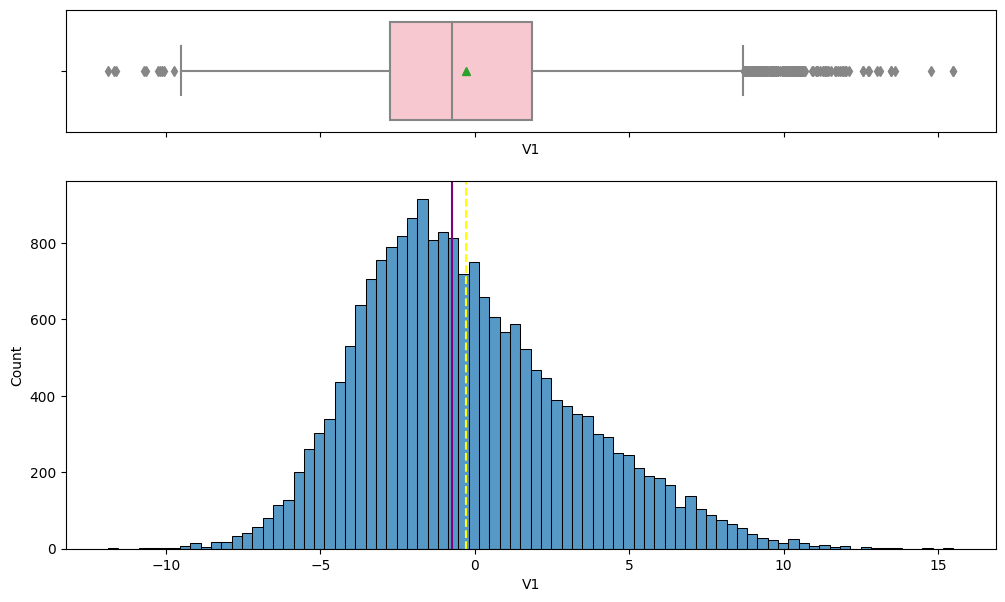

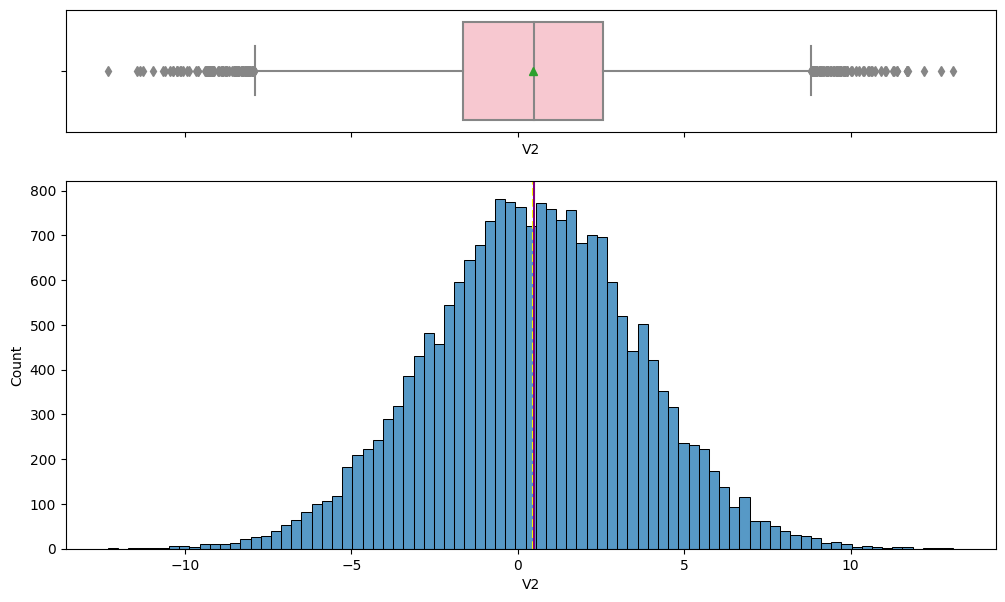

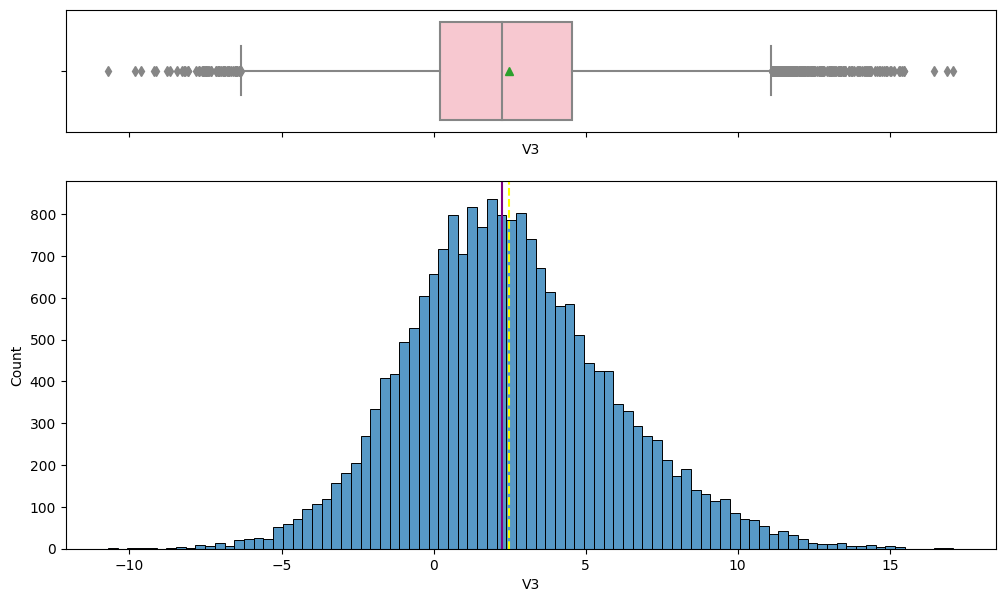

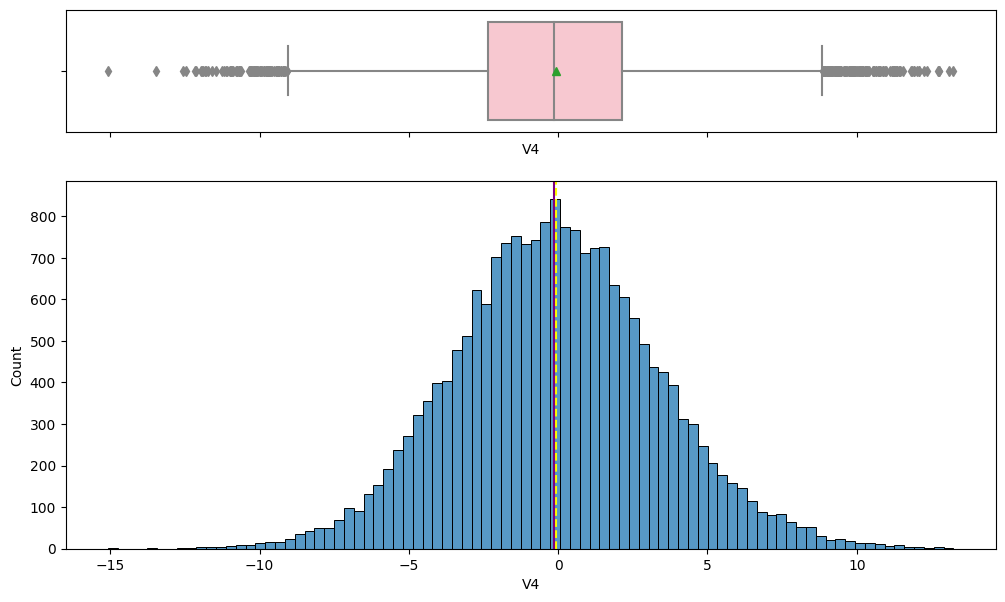

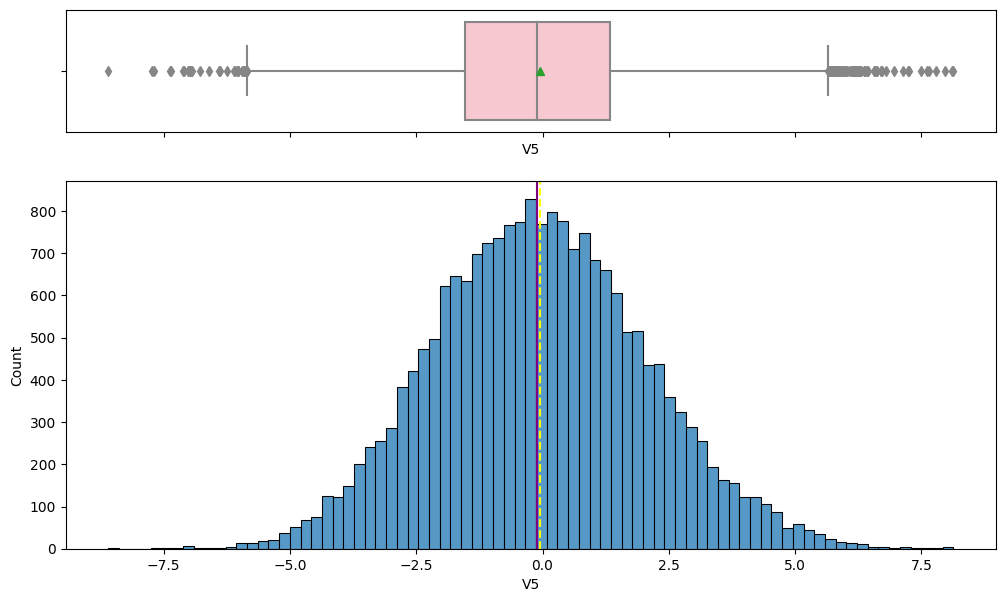

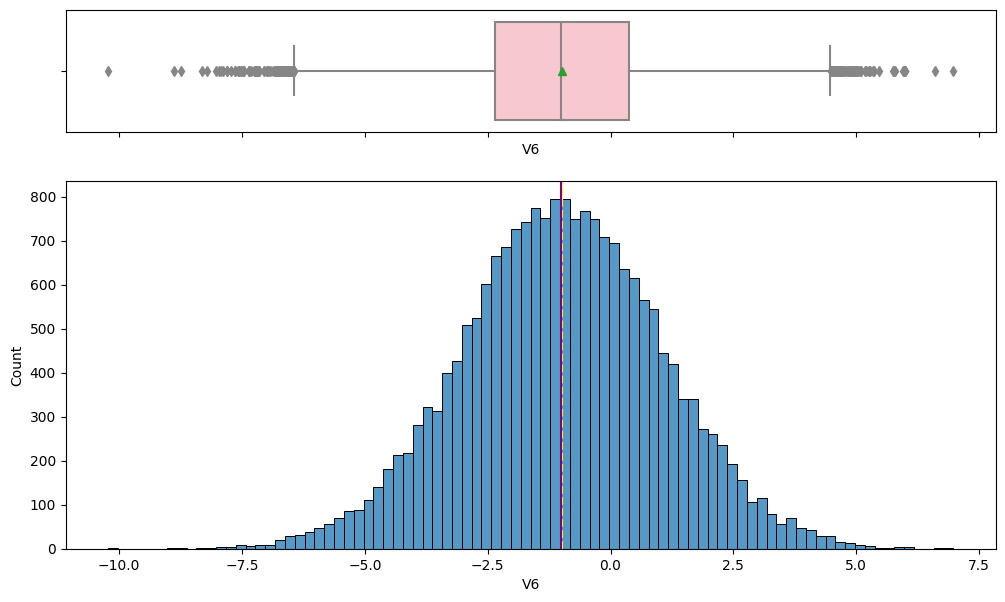

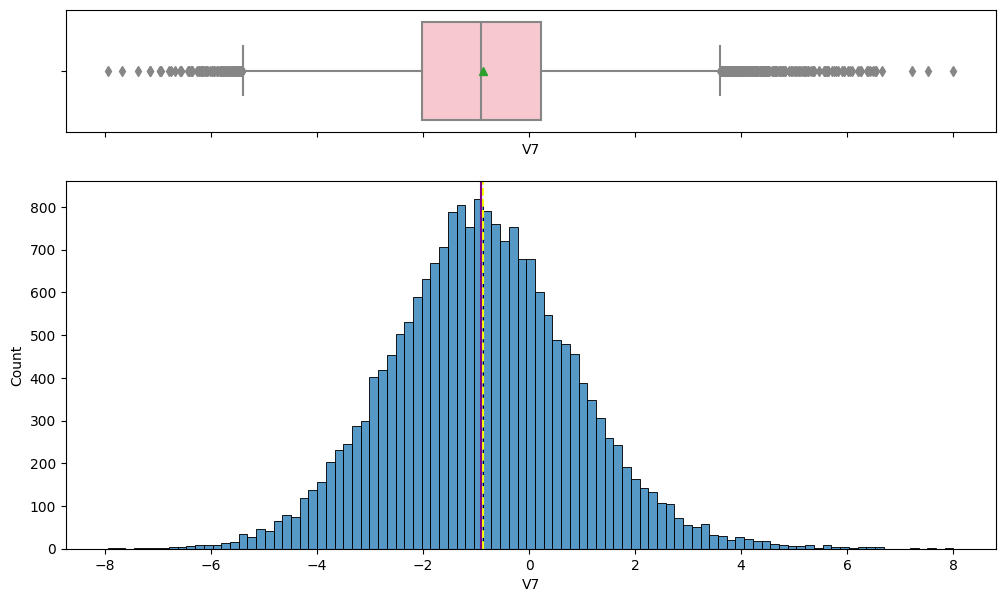

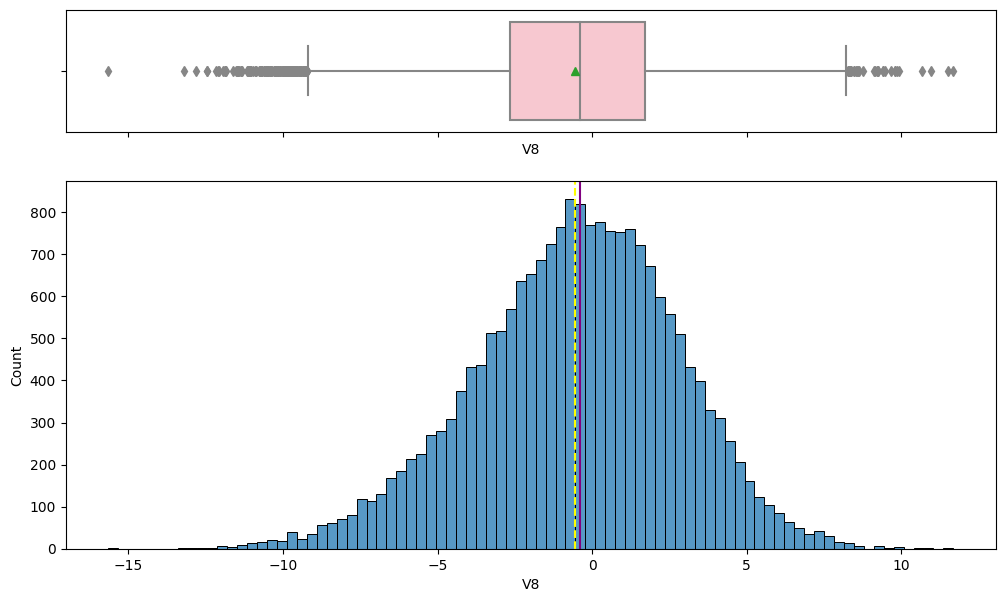

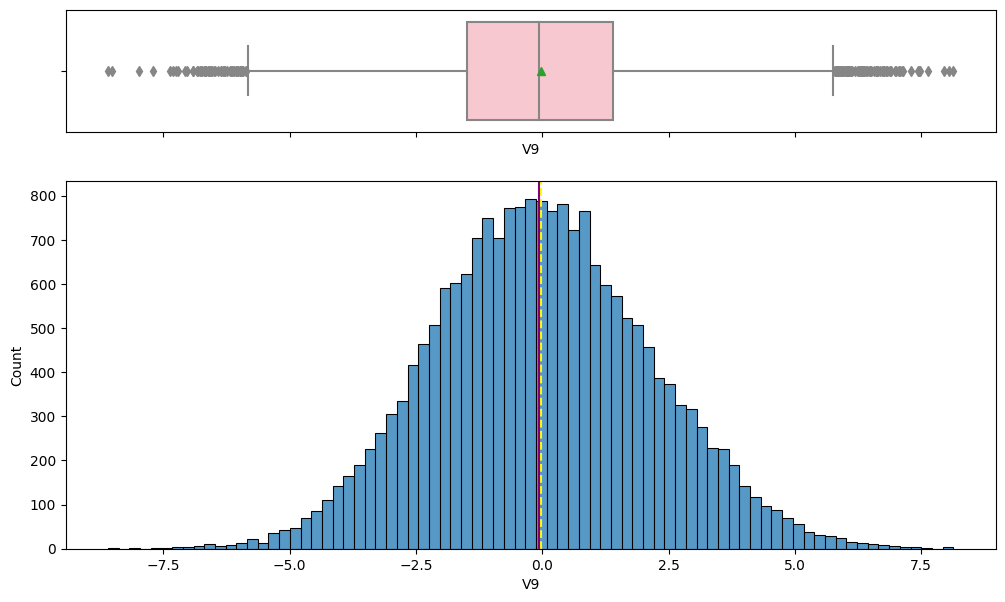

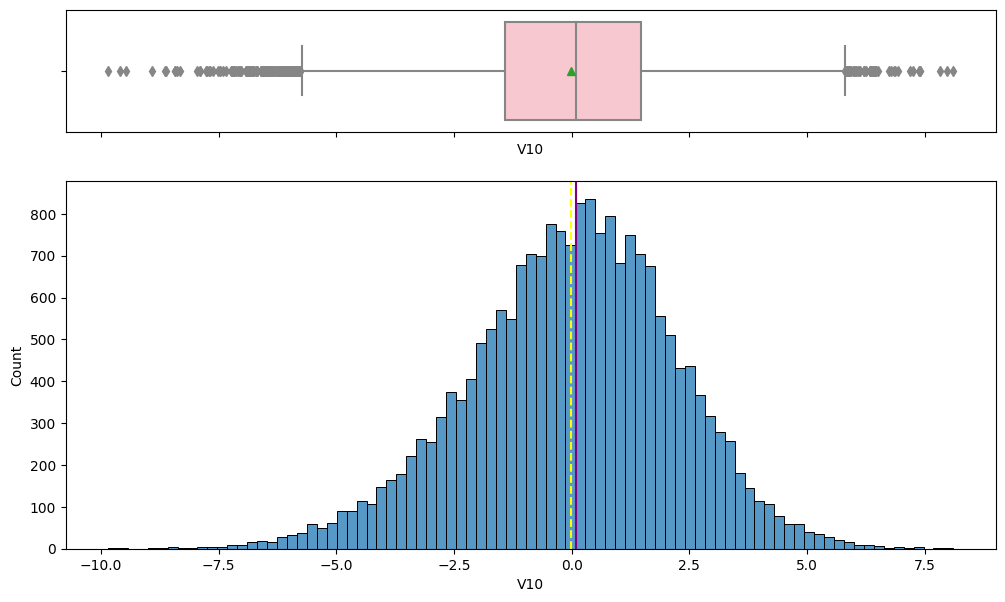

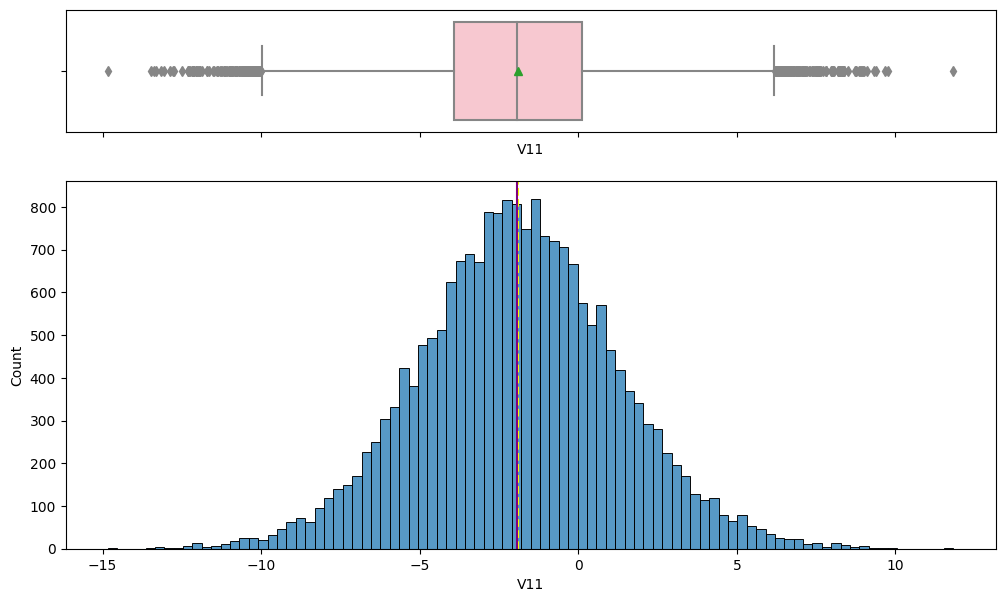

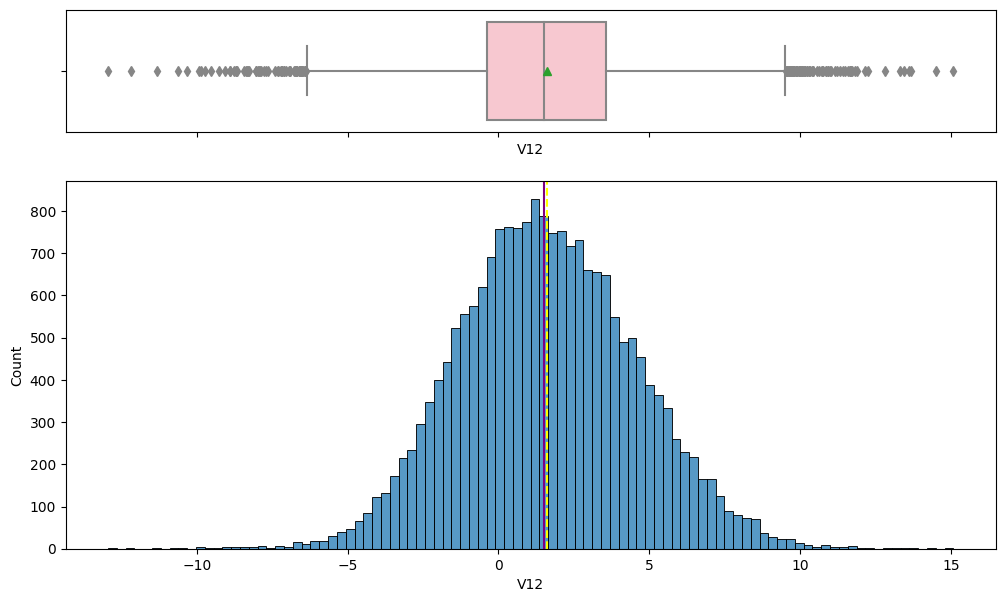

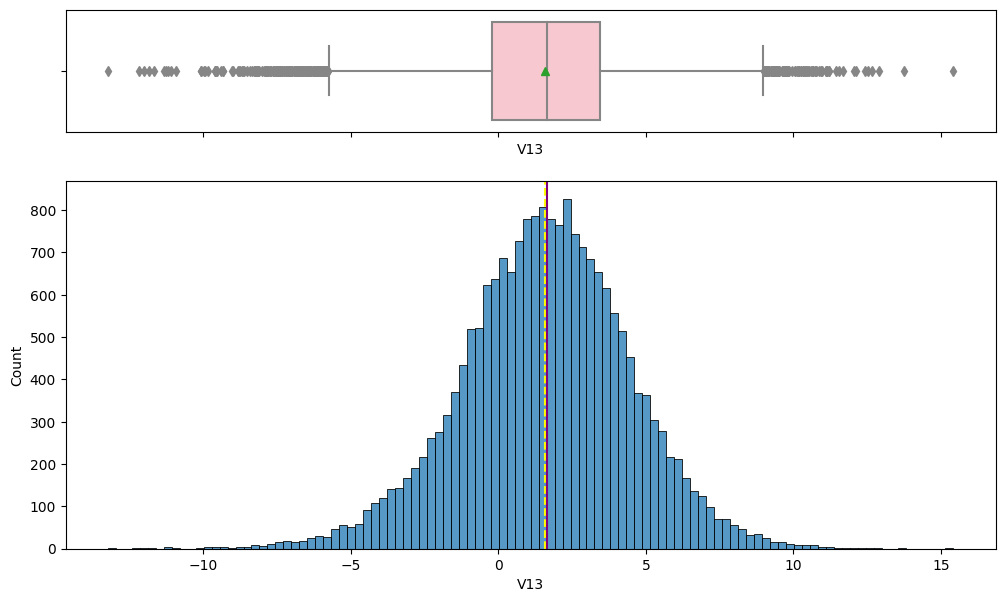

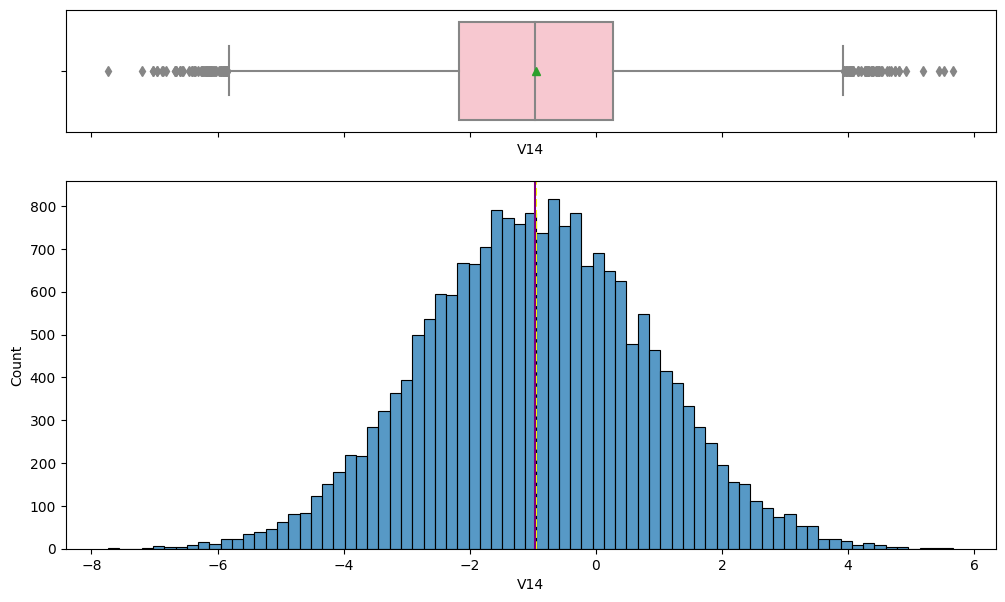

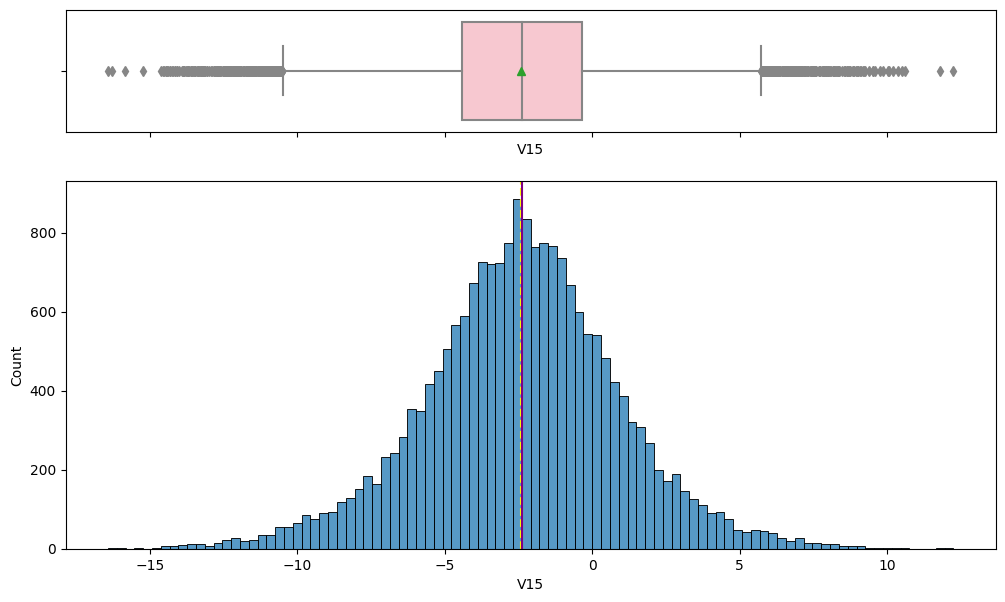

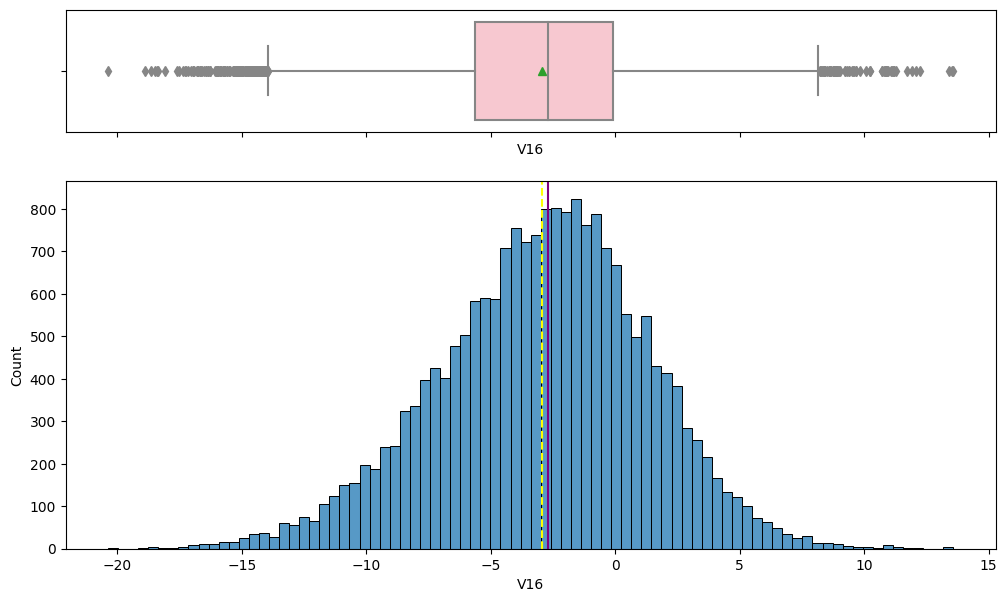

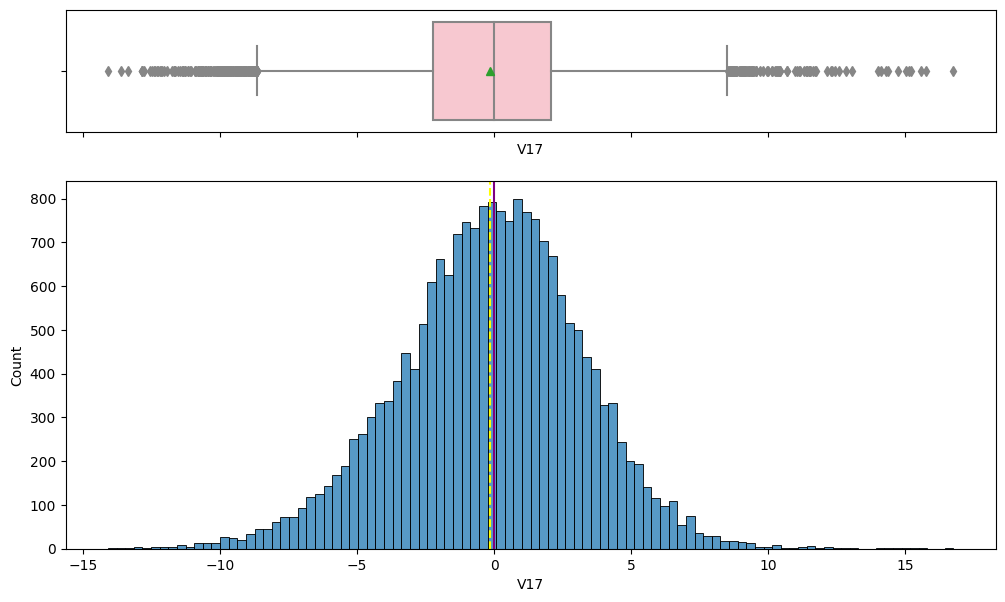

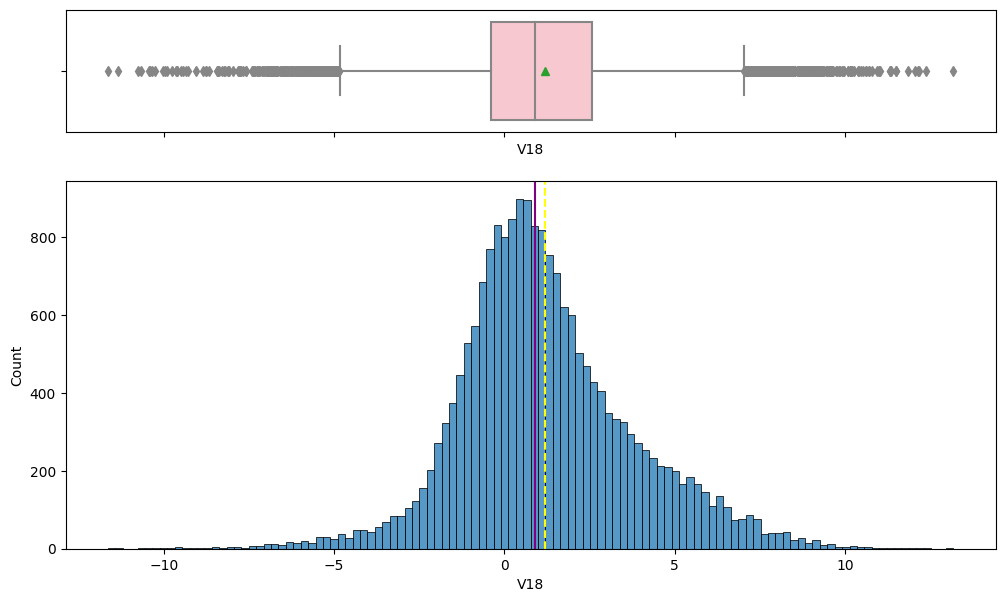

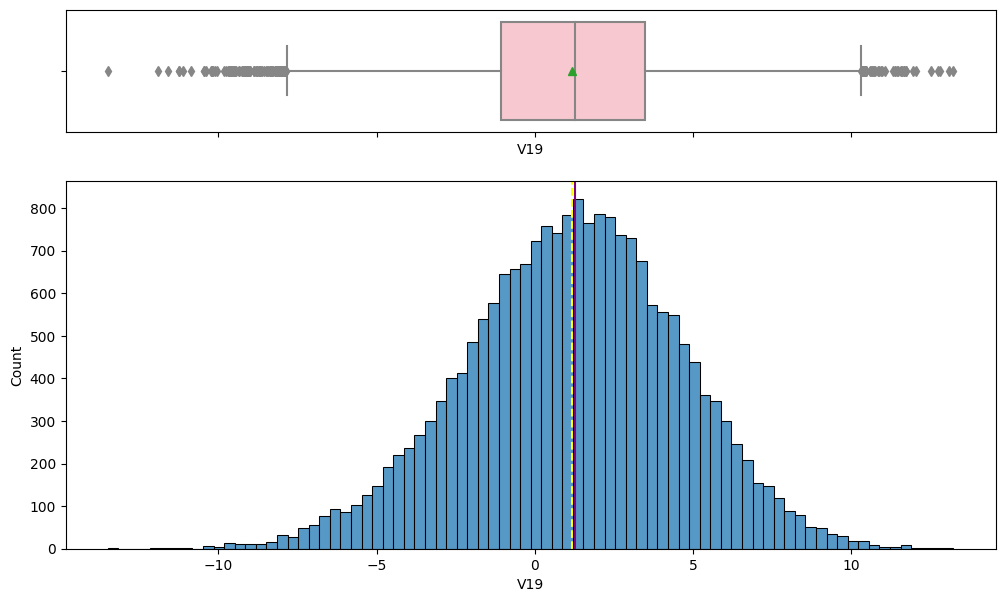

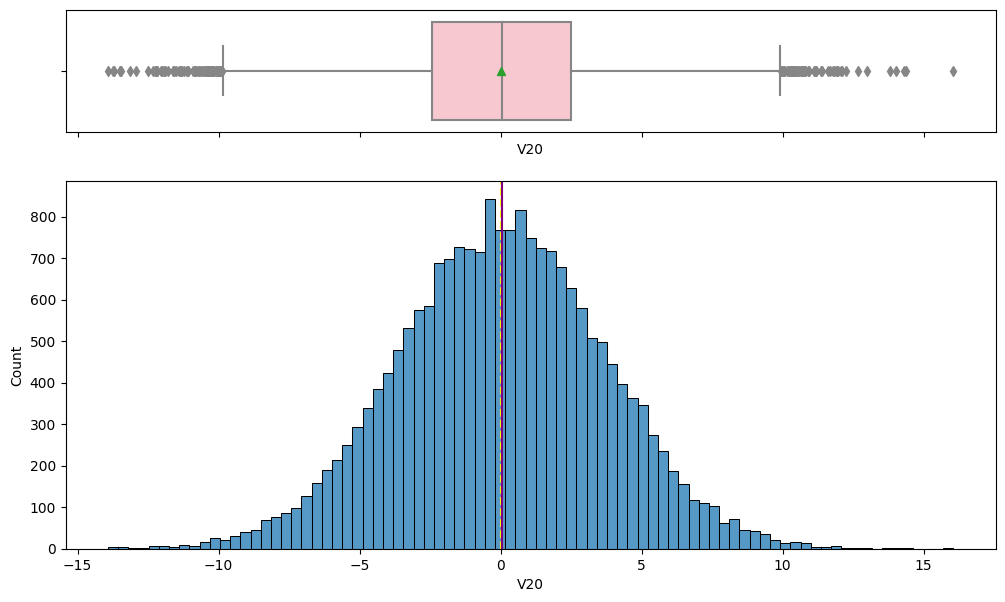

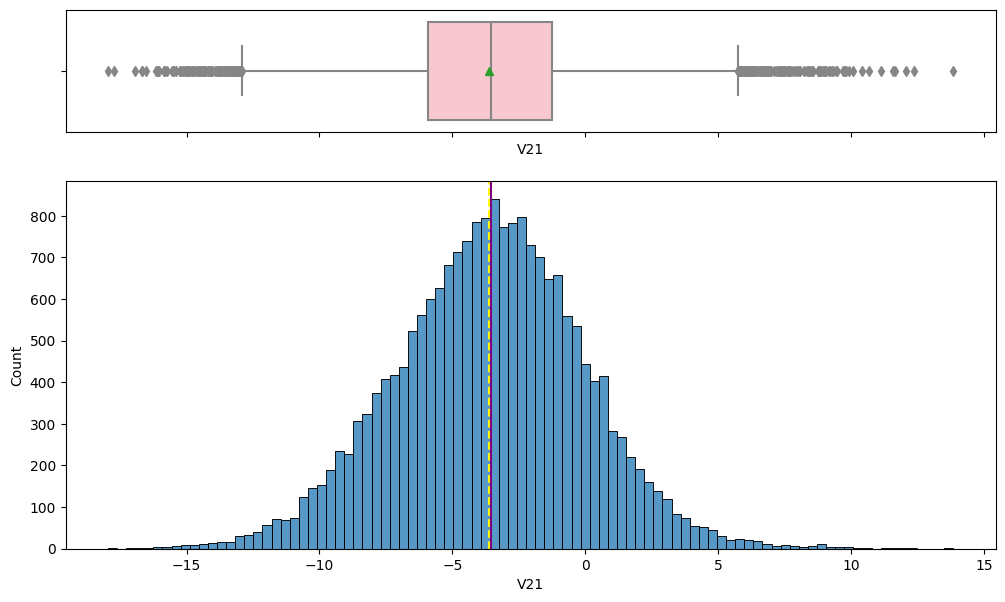

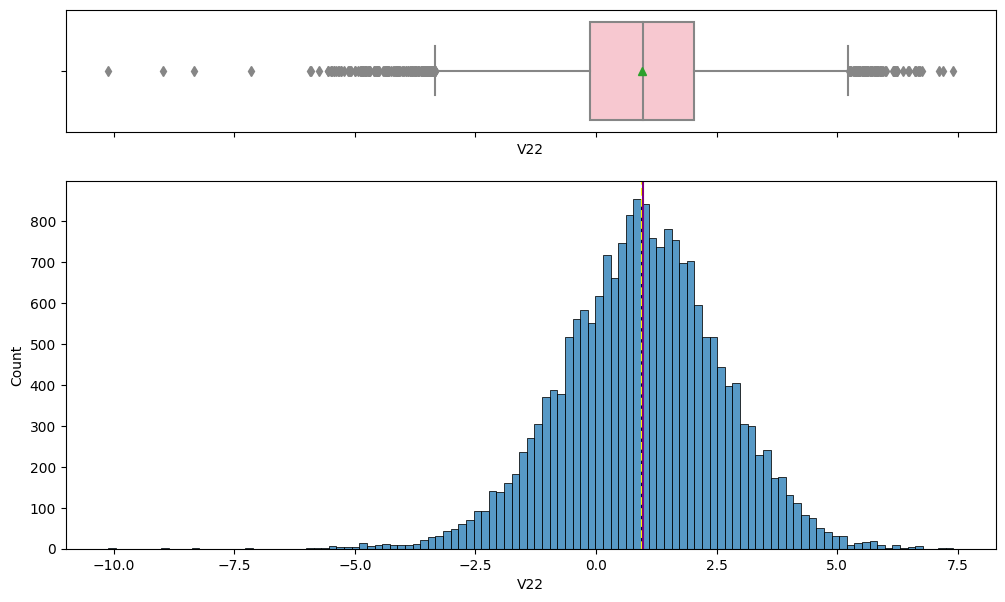

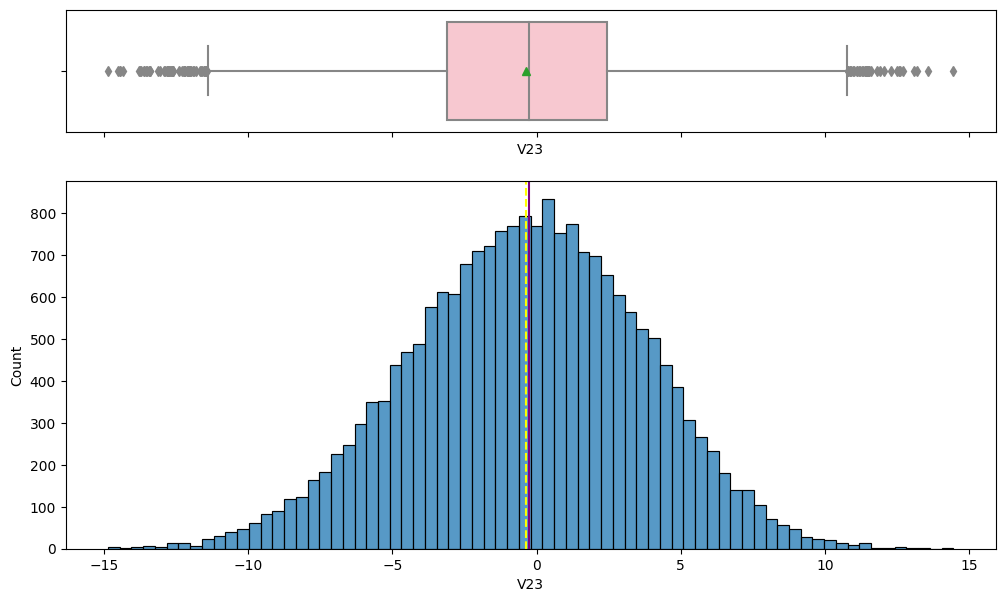

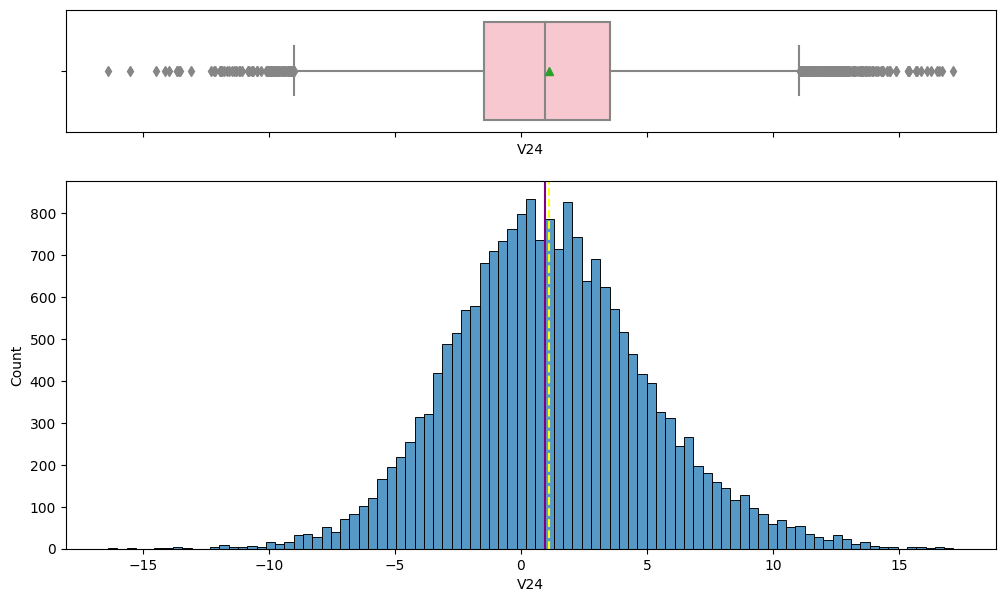

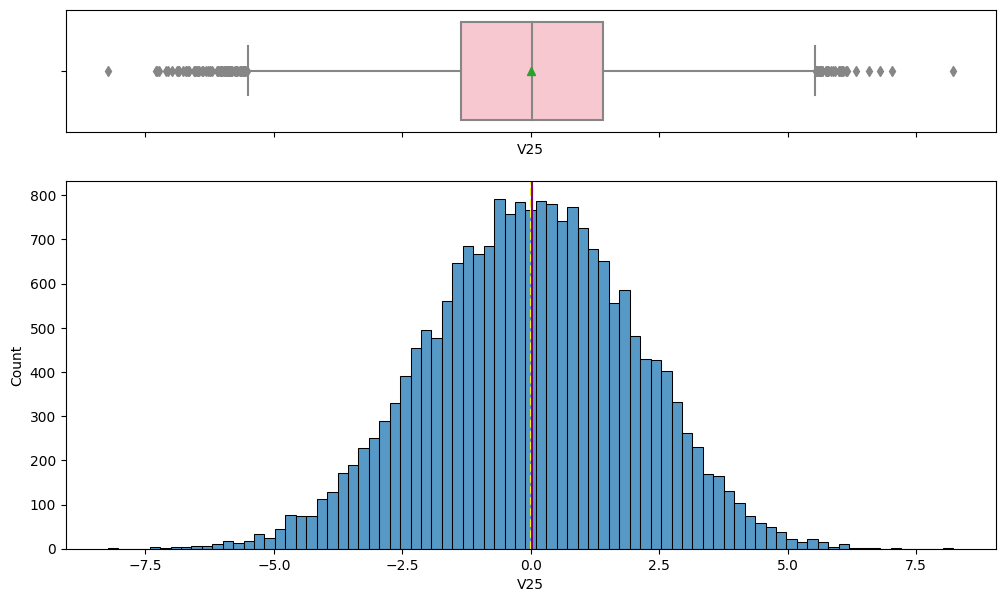

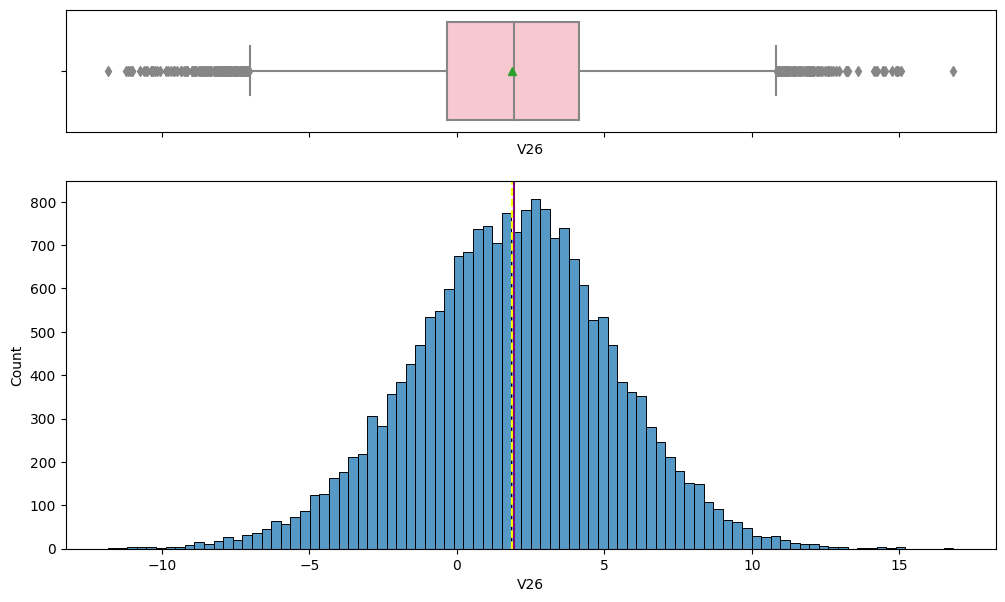

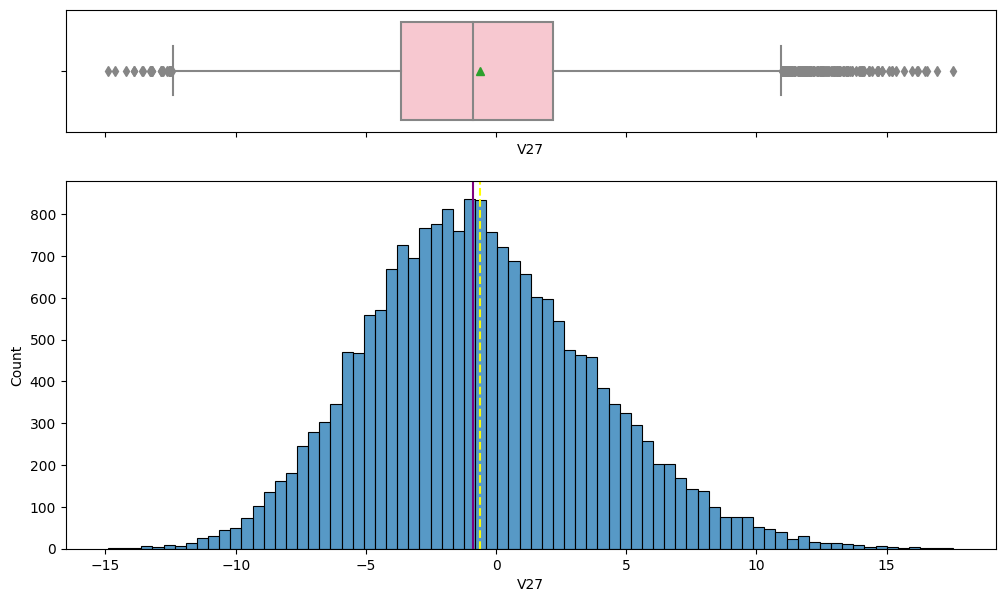

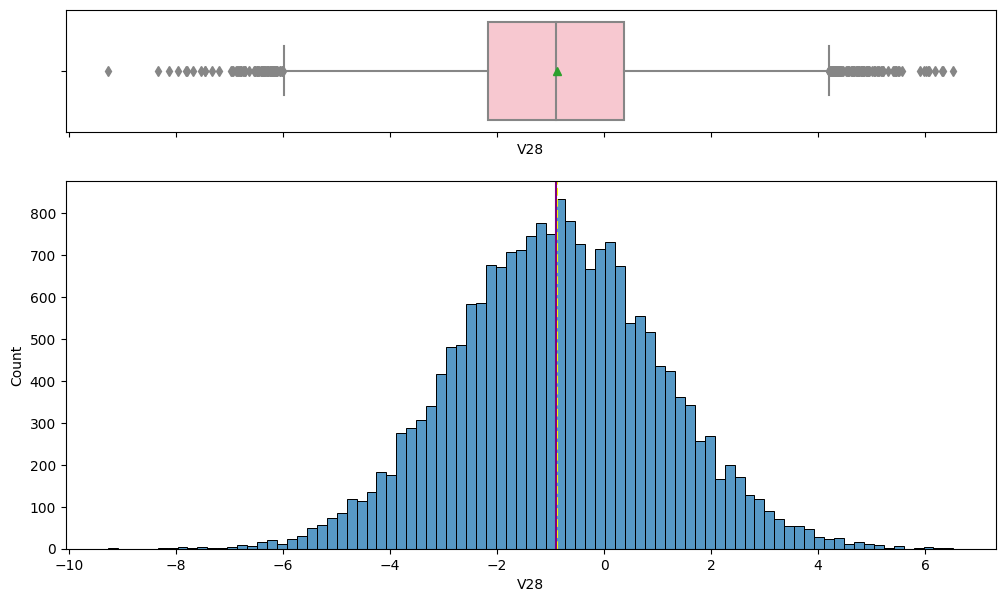

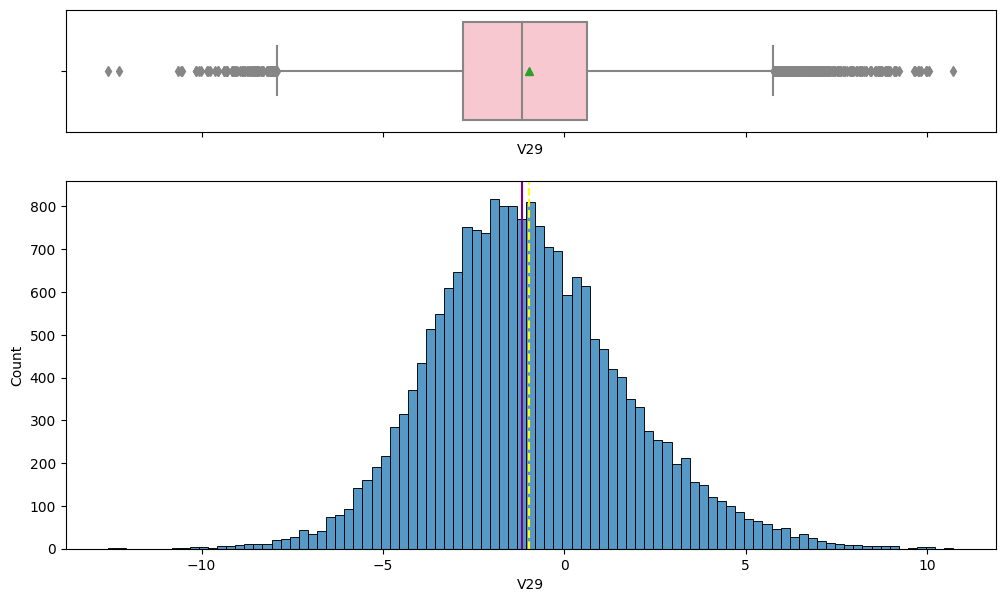

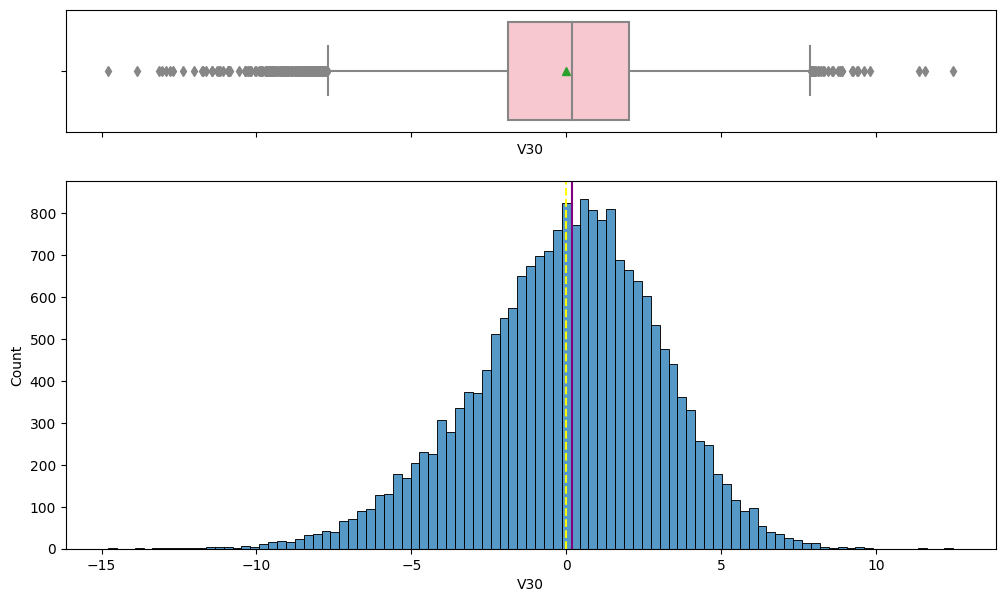

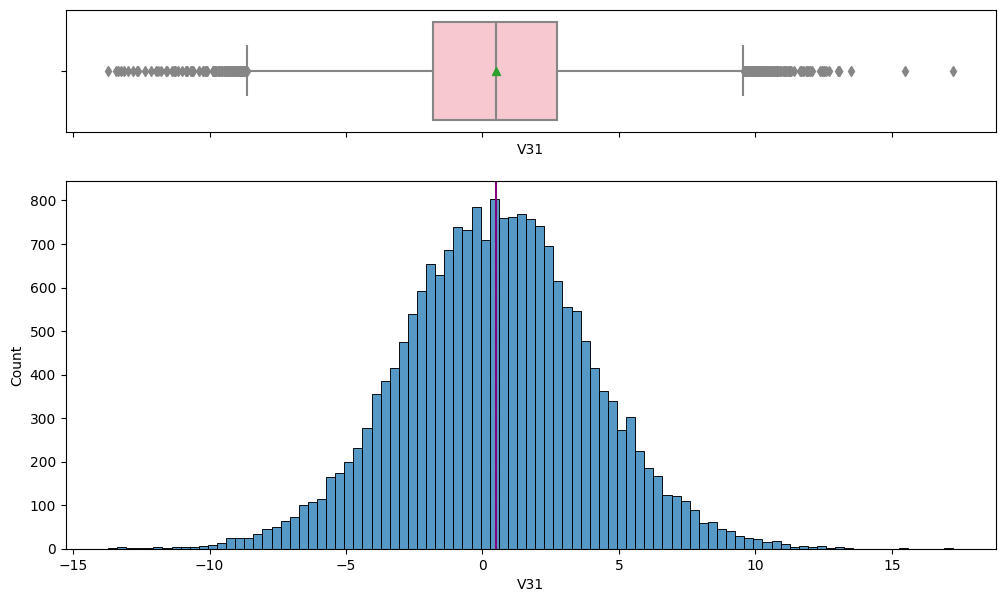

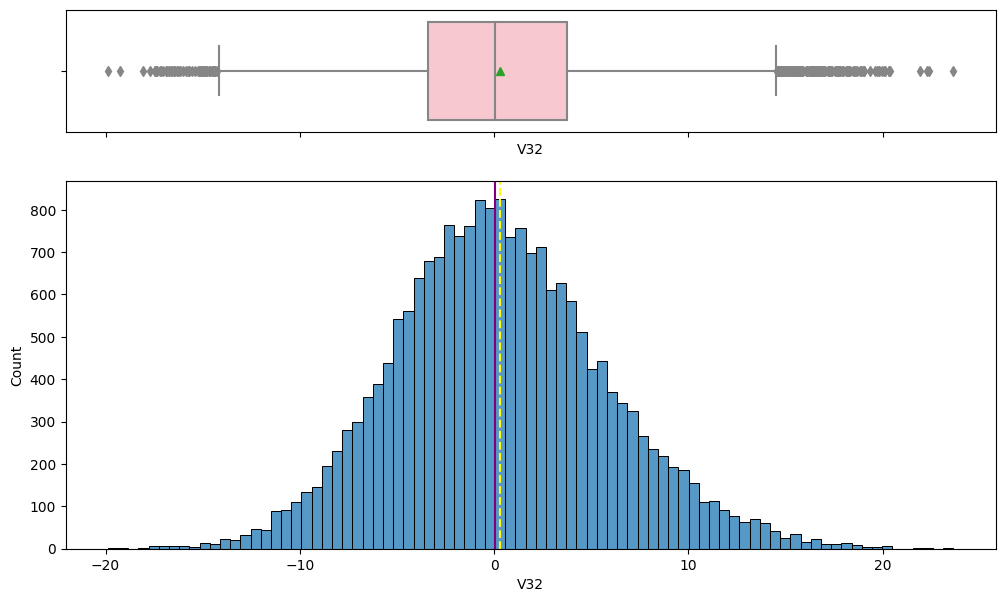

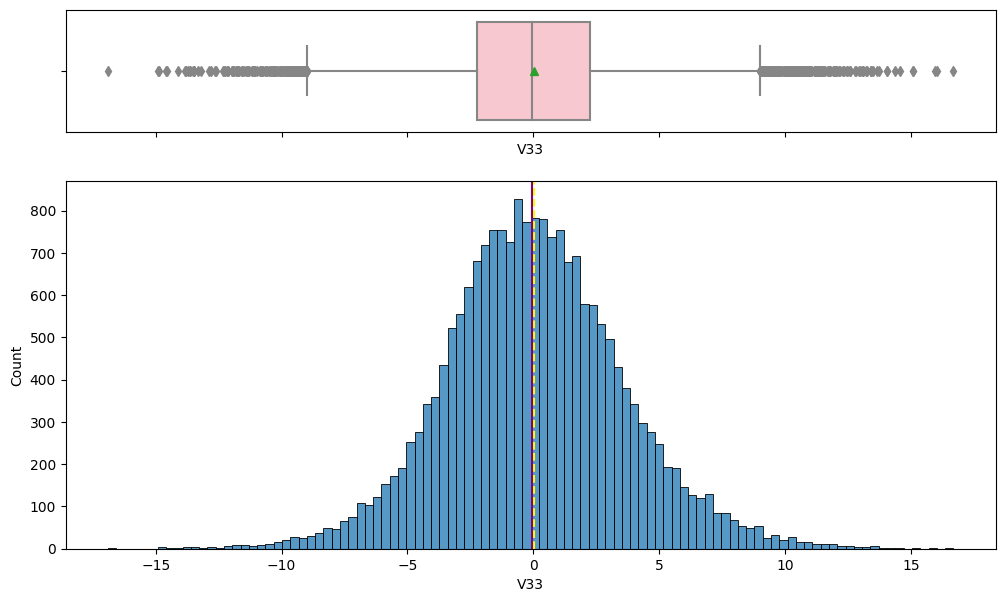

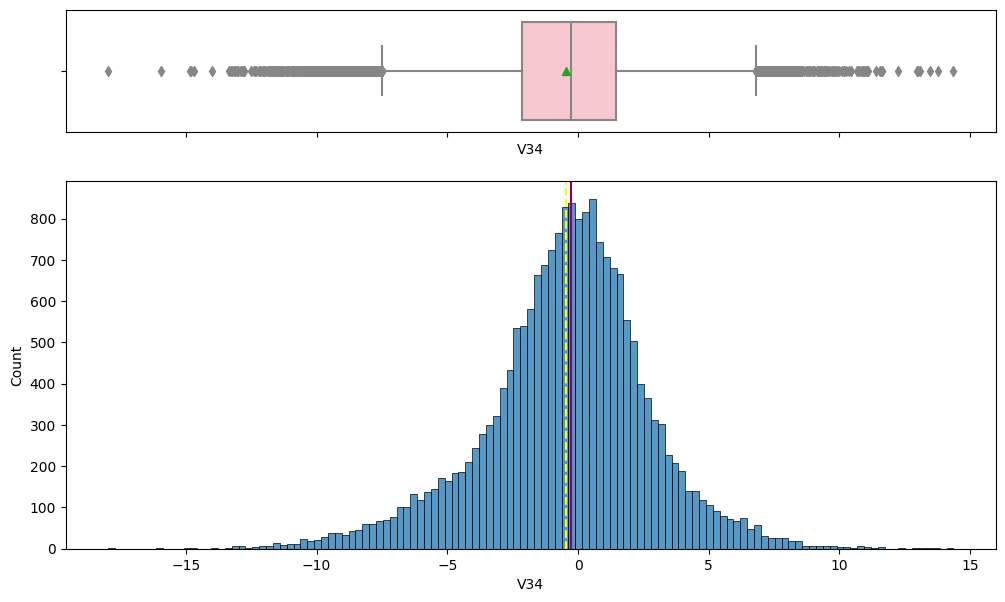

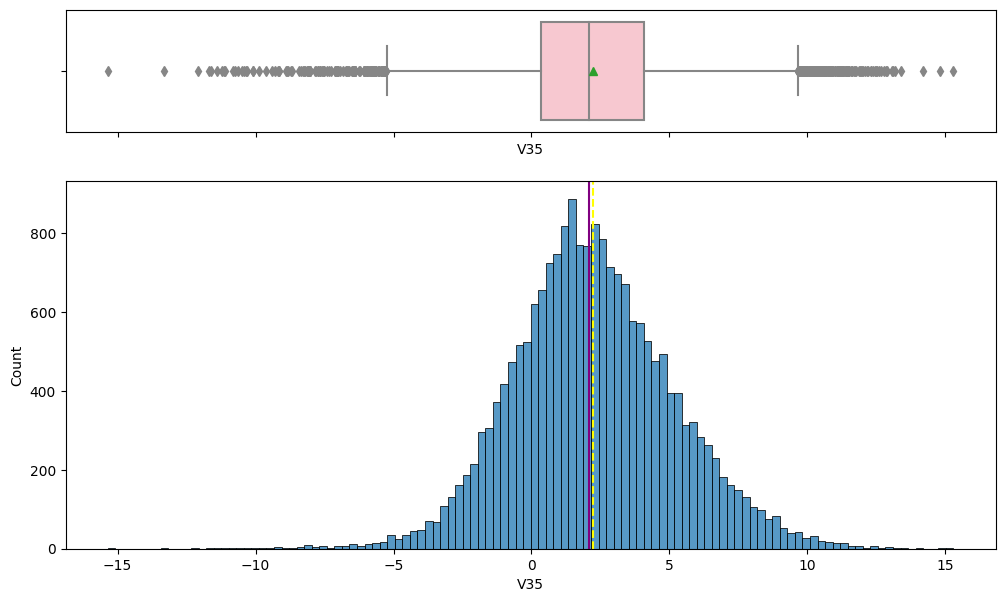

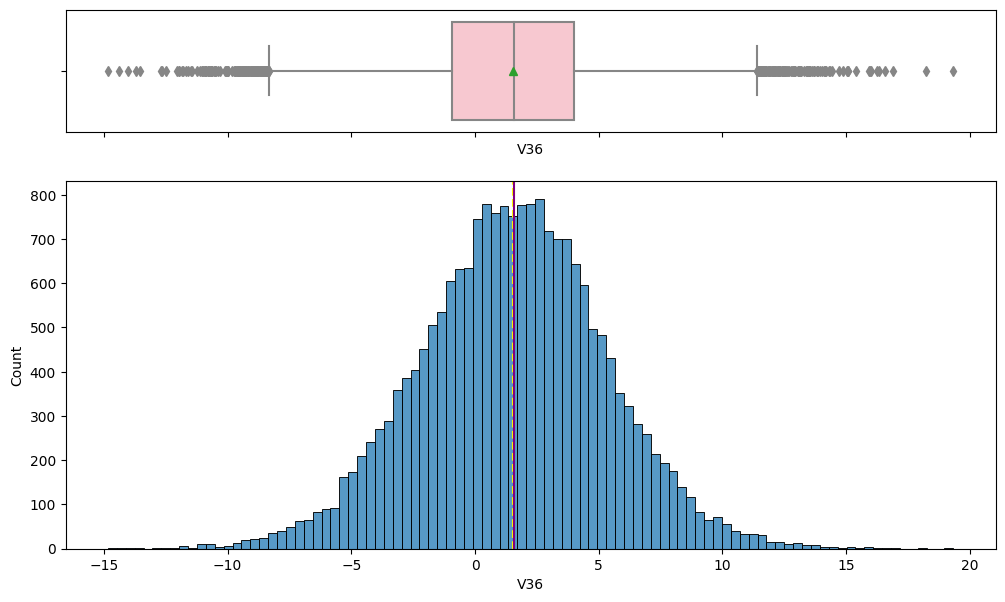

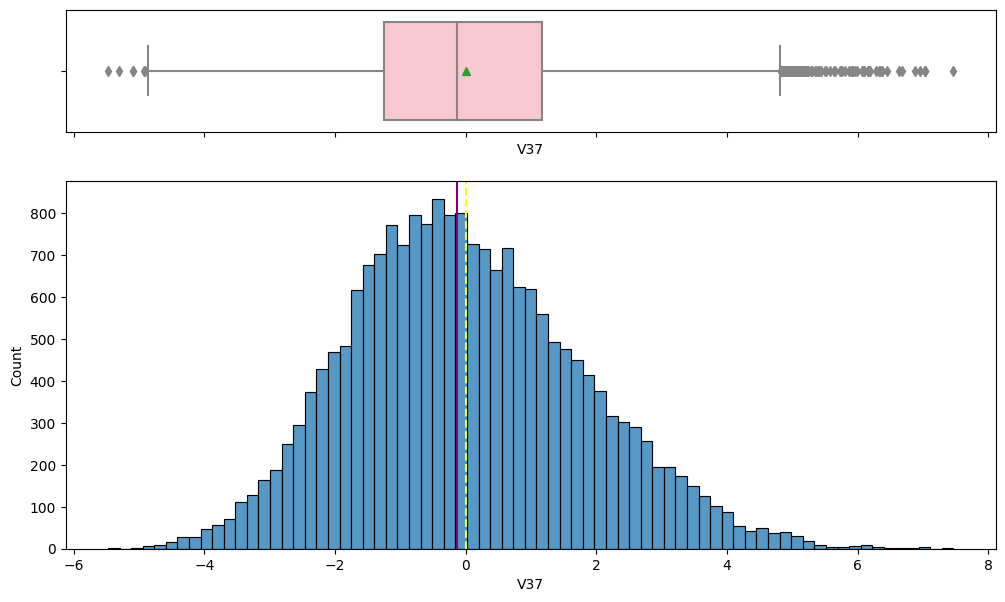

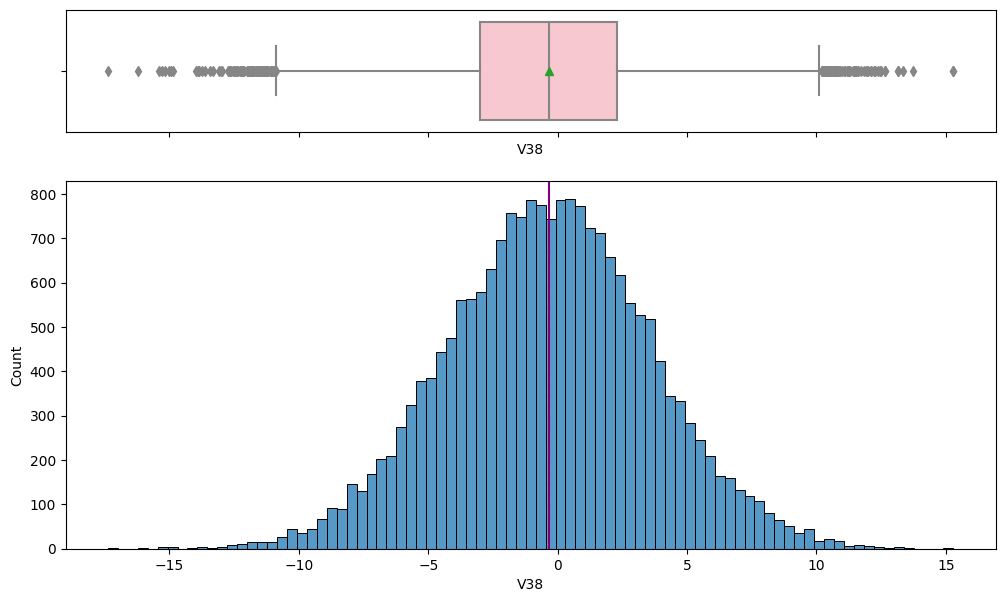

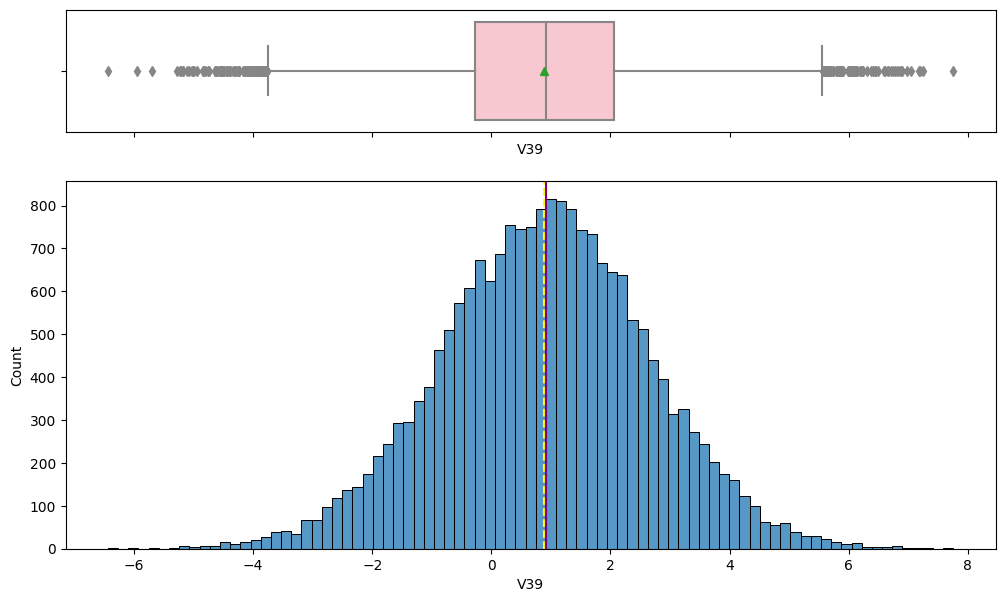

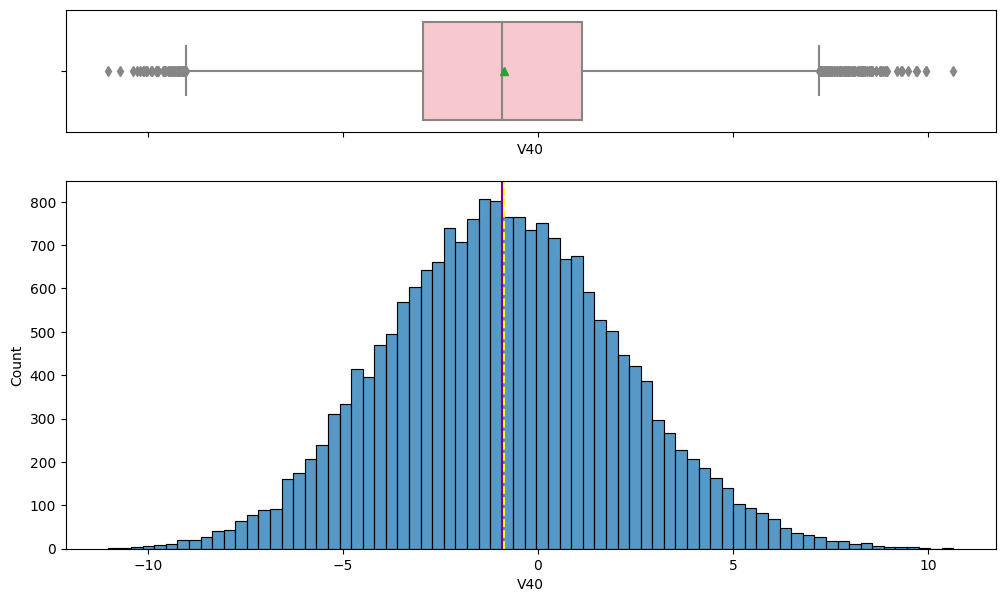

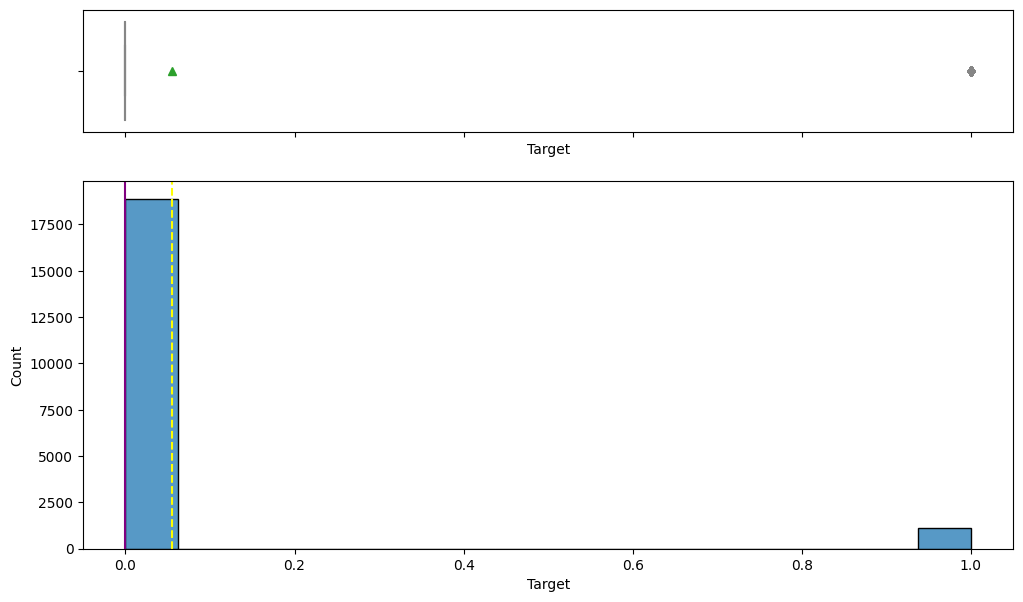

In [40]:
# Call function on all columns in train set
for feature in df.columns:
    histogram_boxplot(data_train, feature, figsize=(12, 7), kde=False, bins=None)

####Observations

- The majority of the variables in the train set are normally distributed with a couple variables being skewed left or right.
- Most variables contain outliers on both sides.


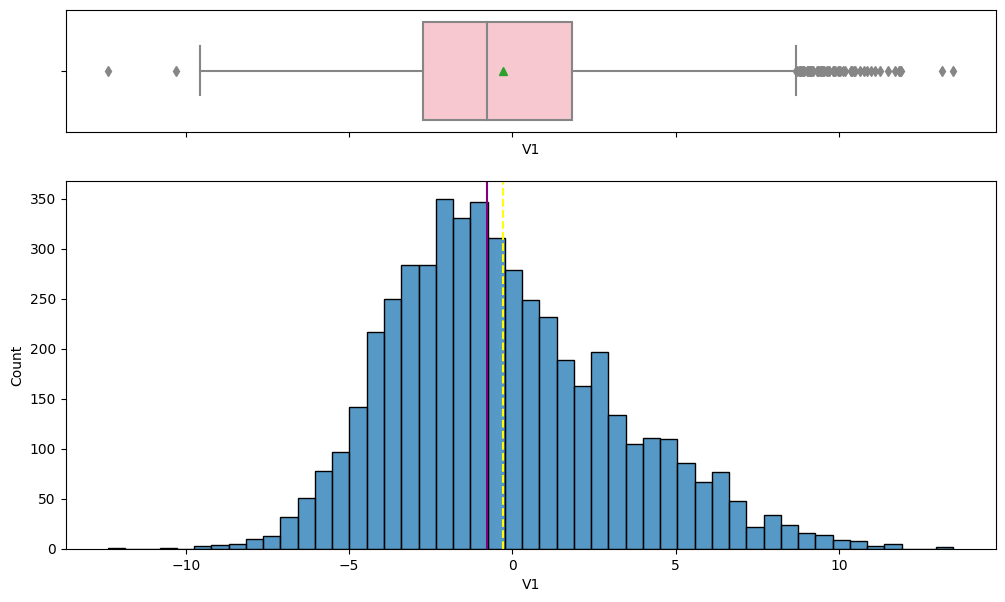

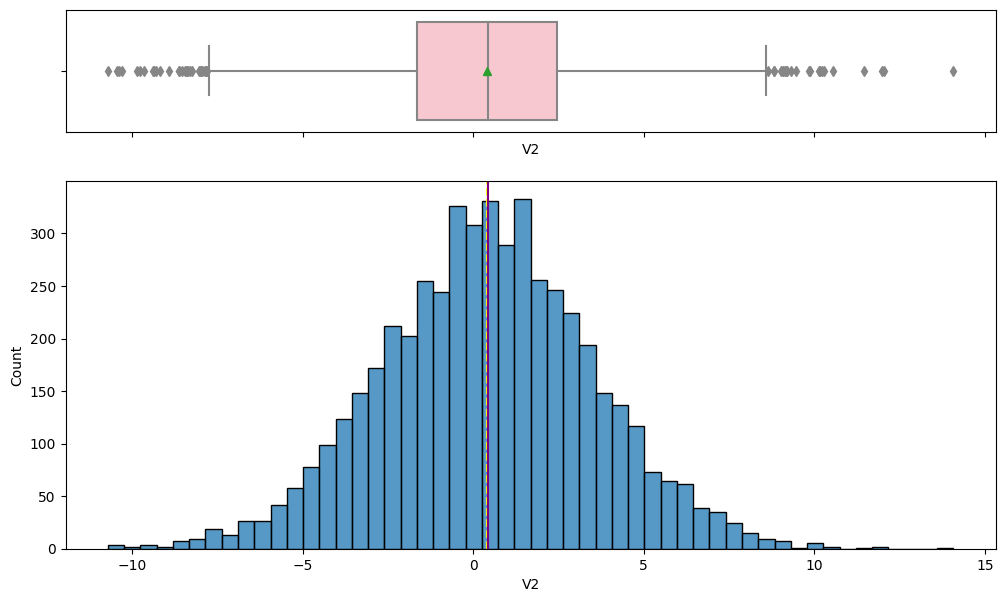

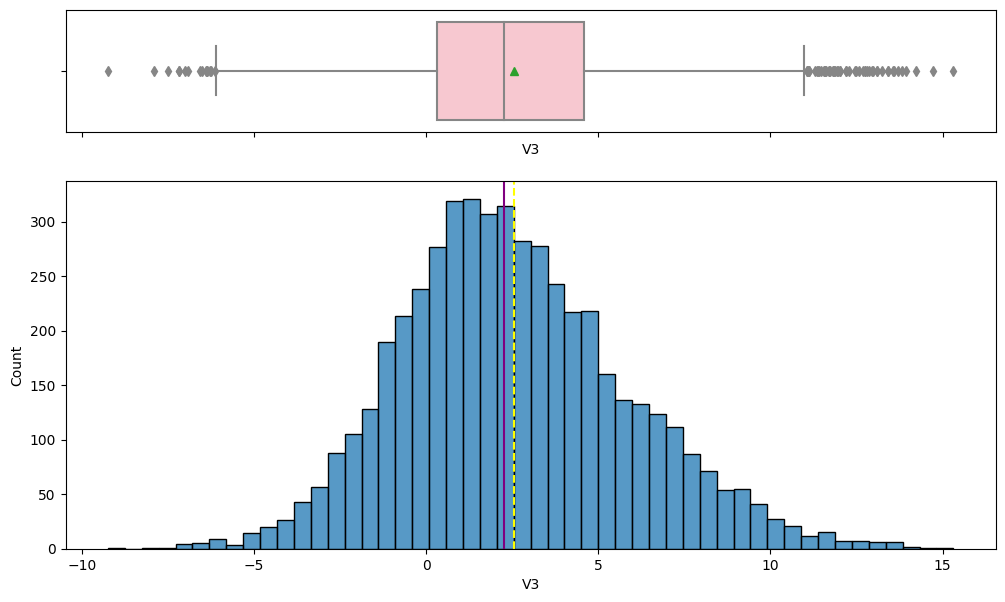

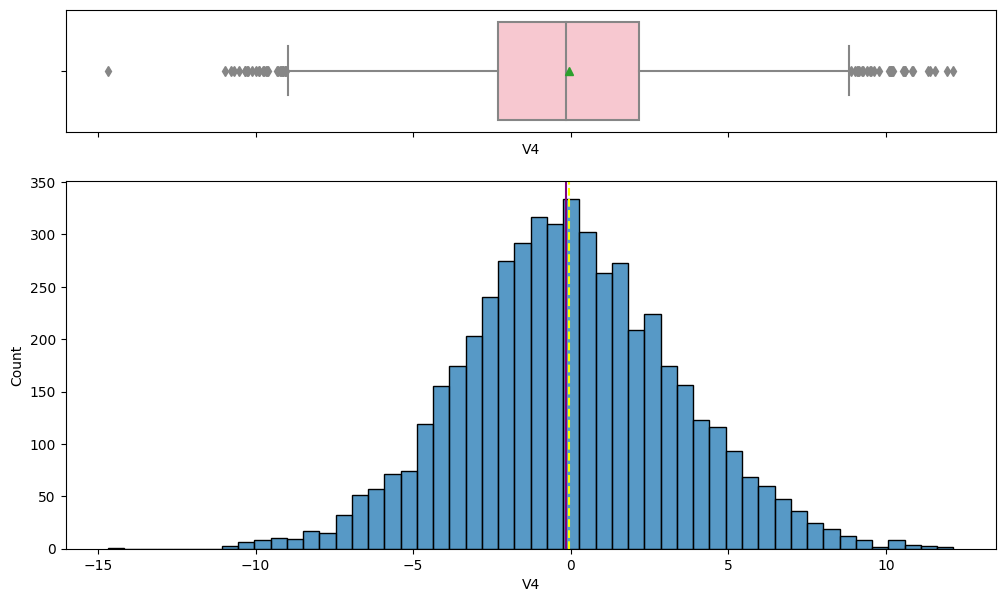

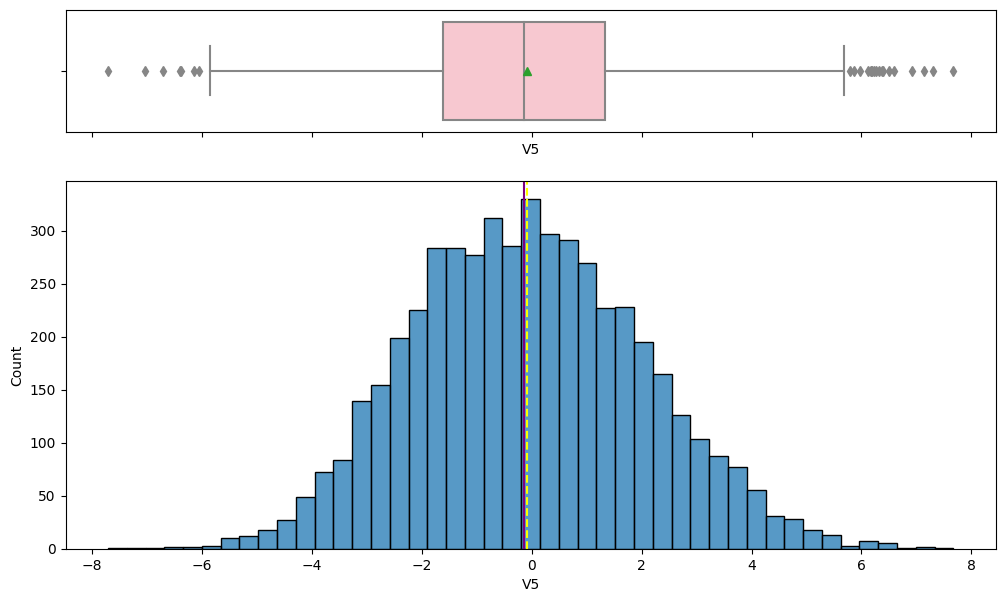

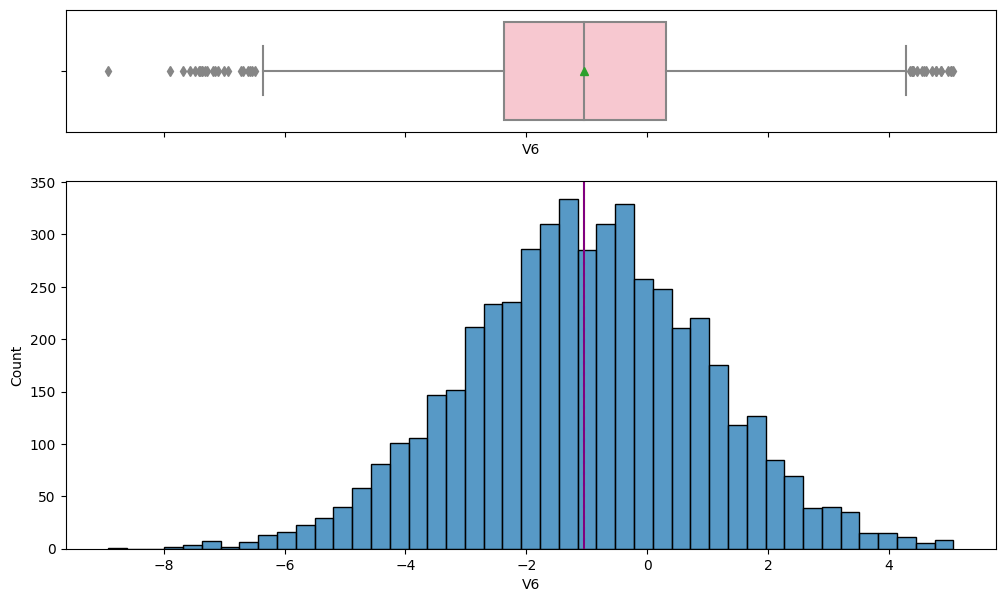

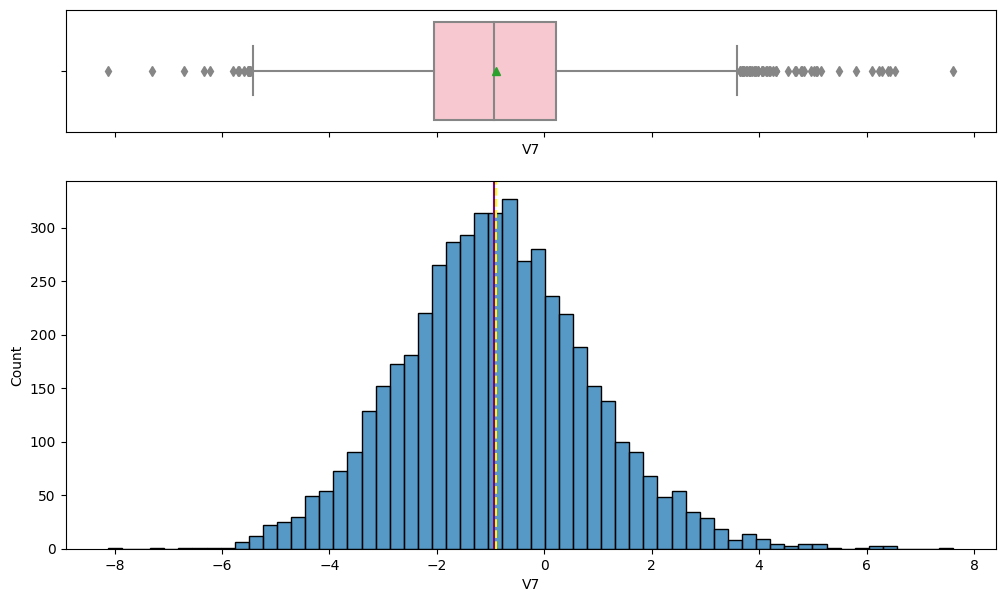

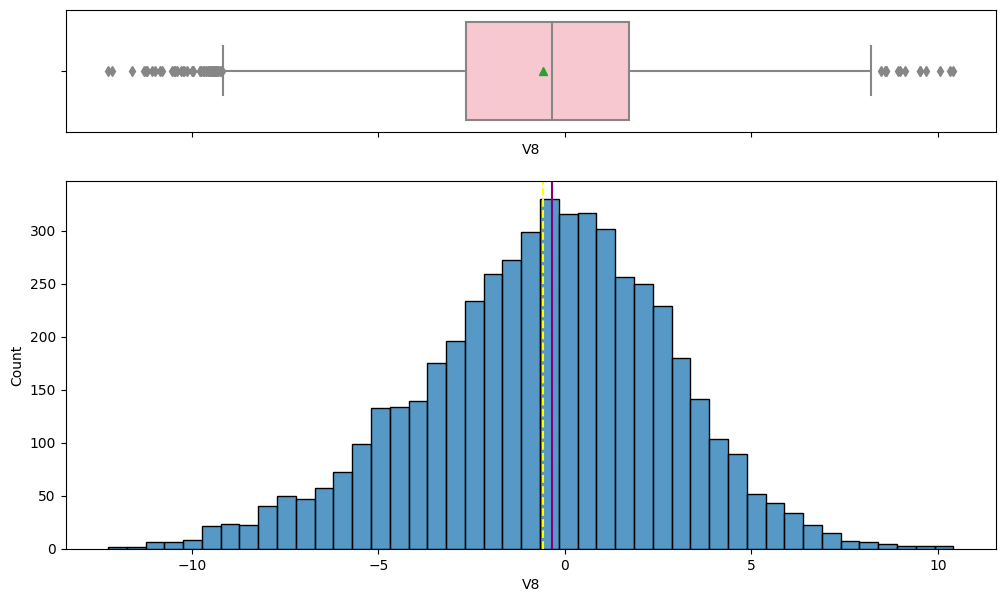

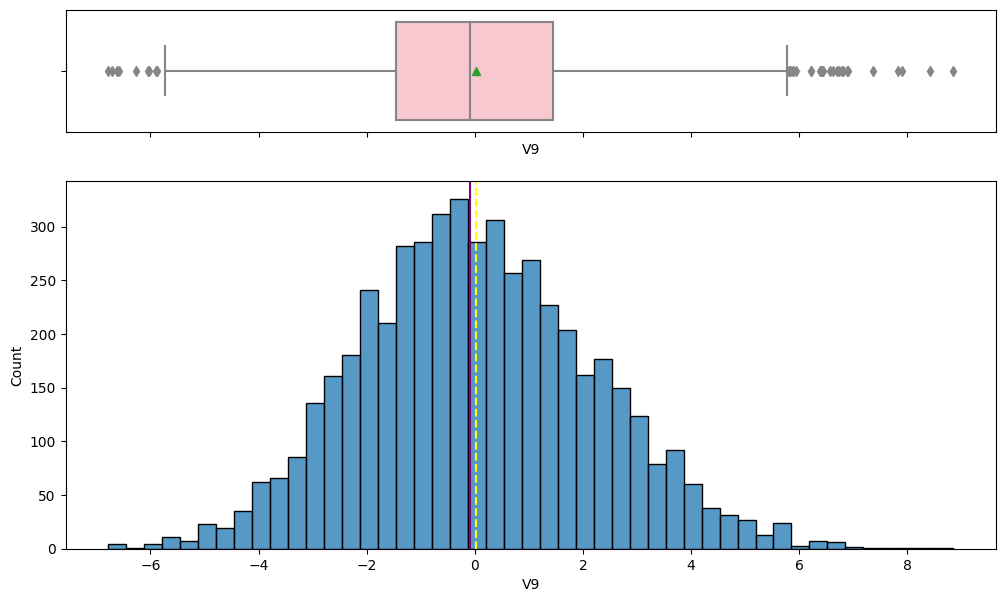

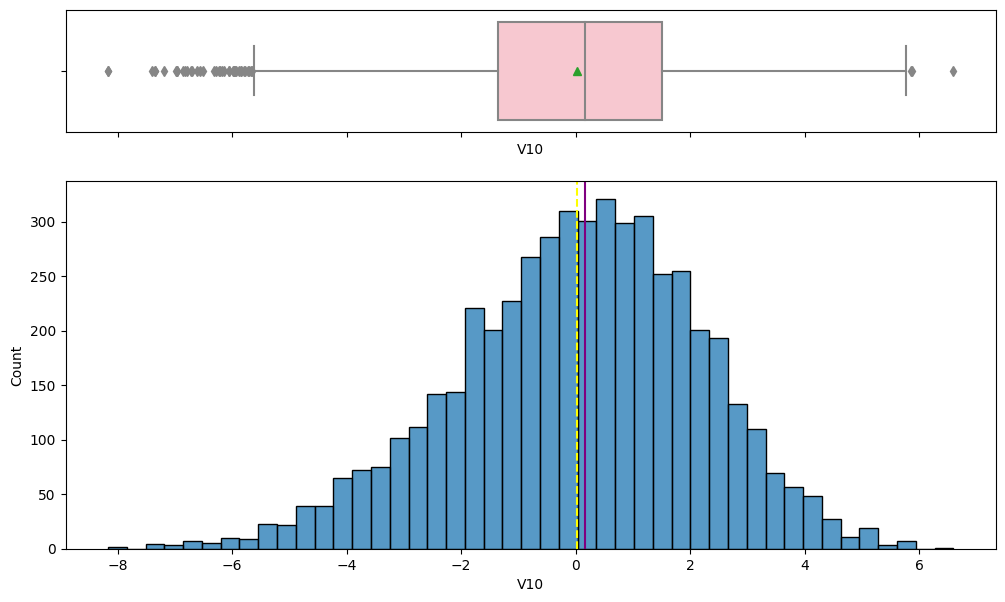

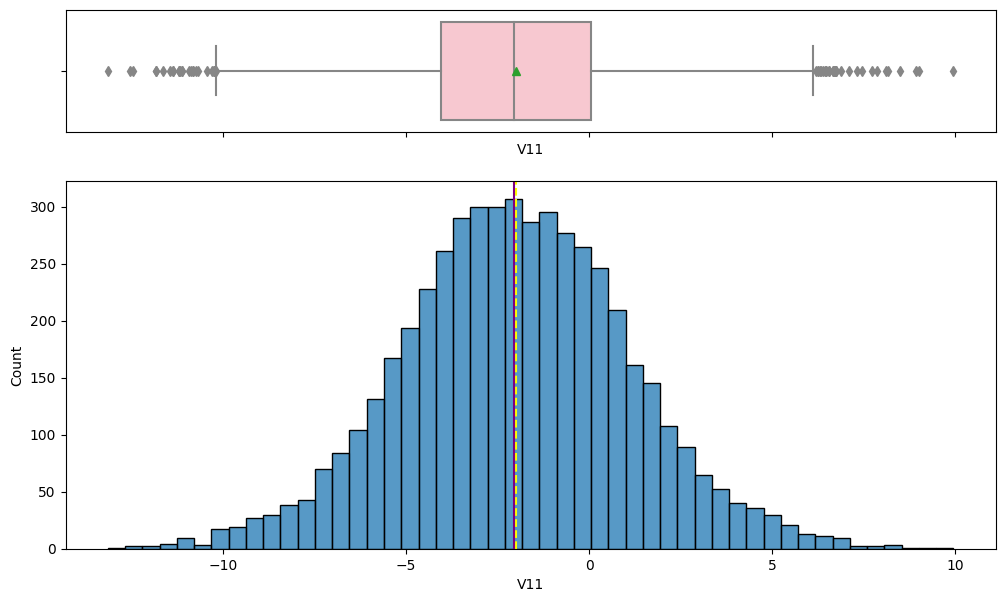

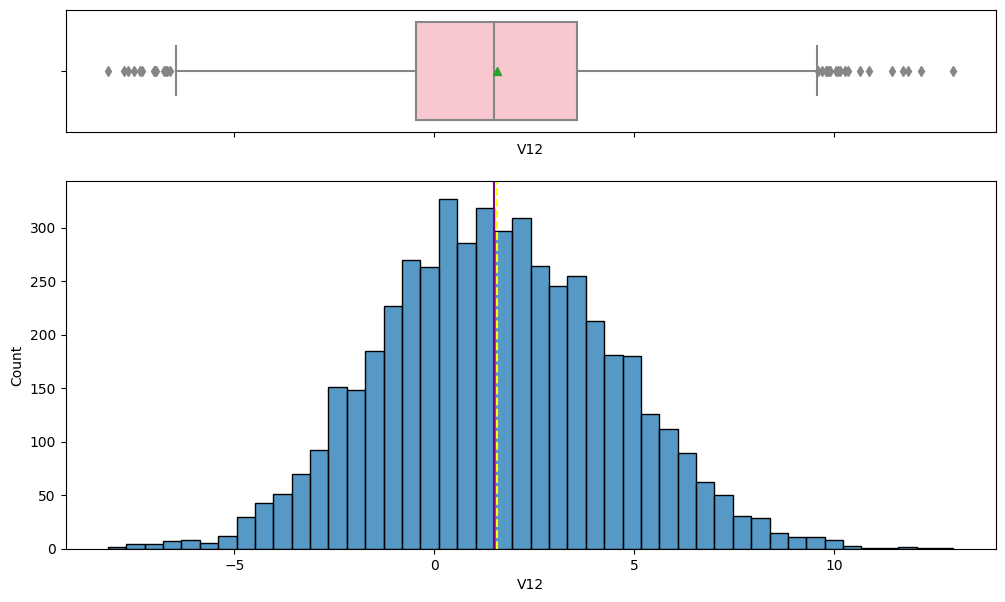

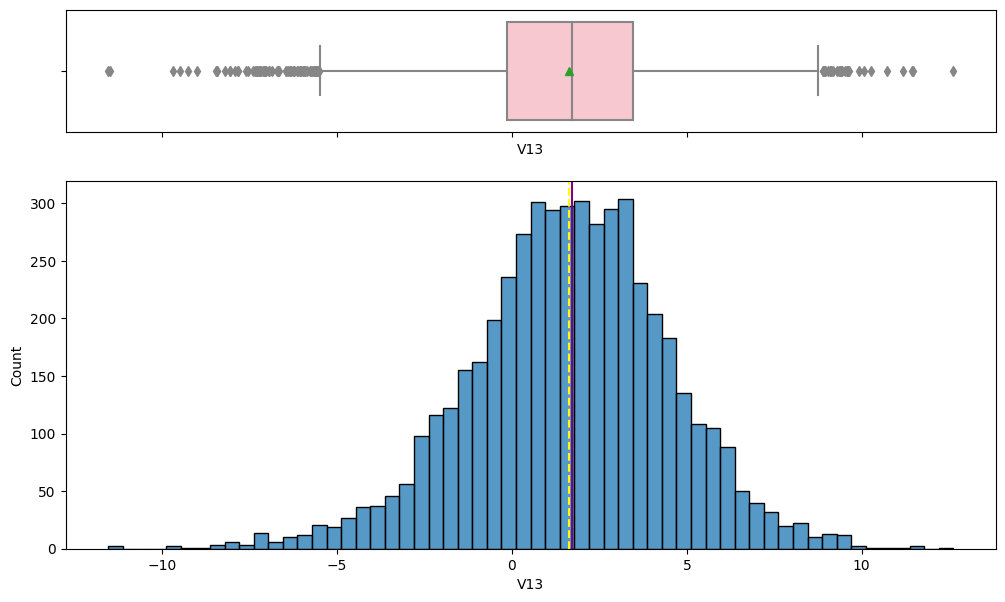

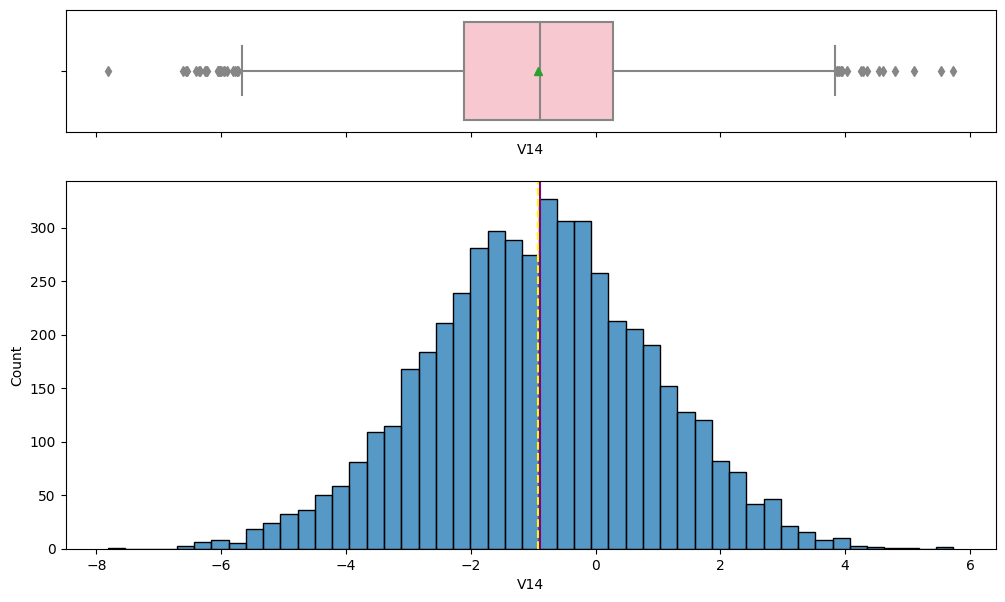

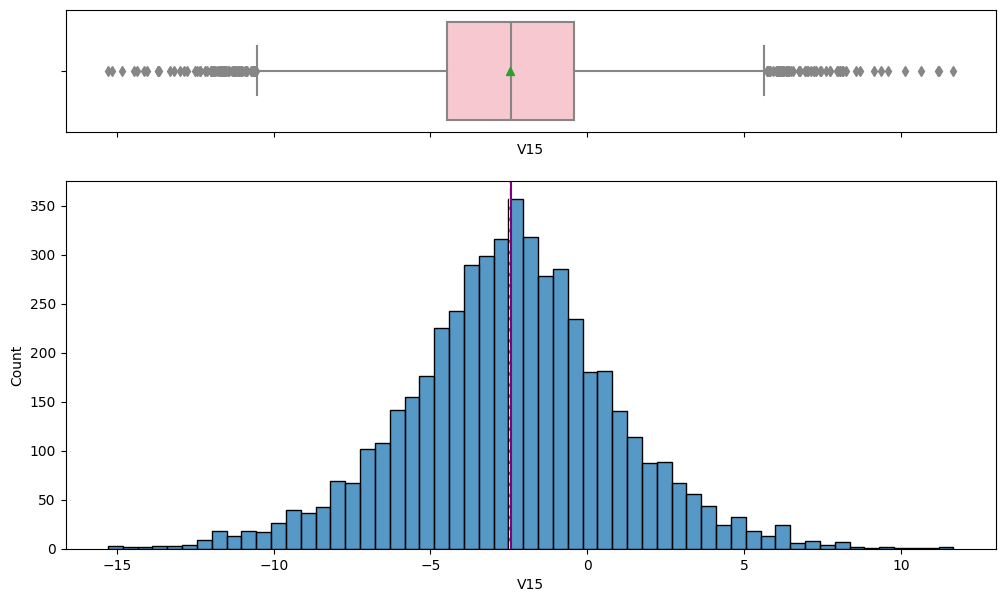

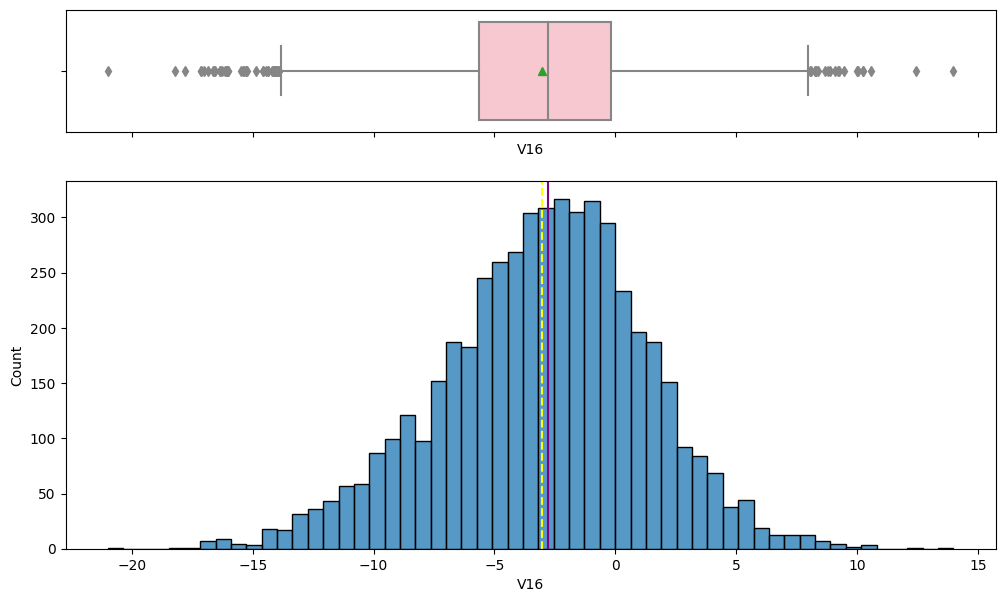

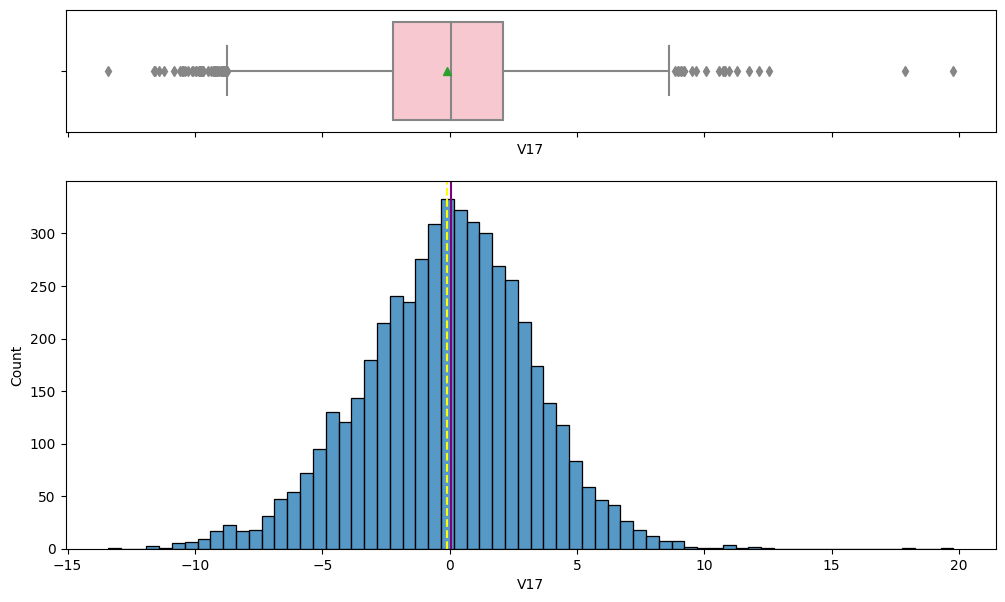

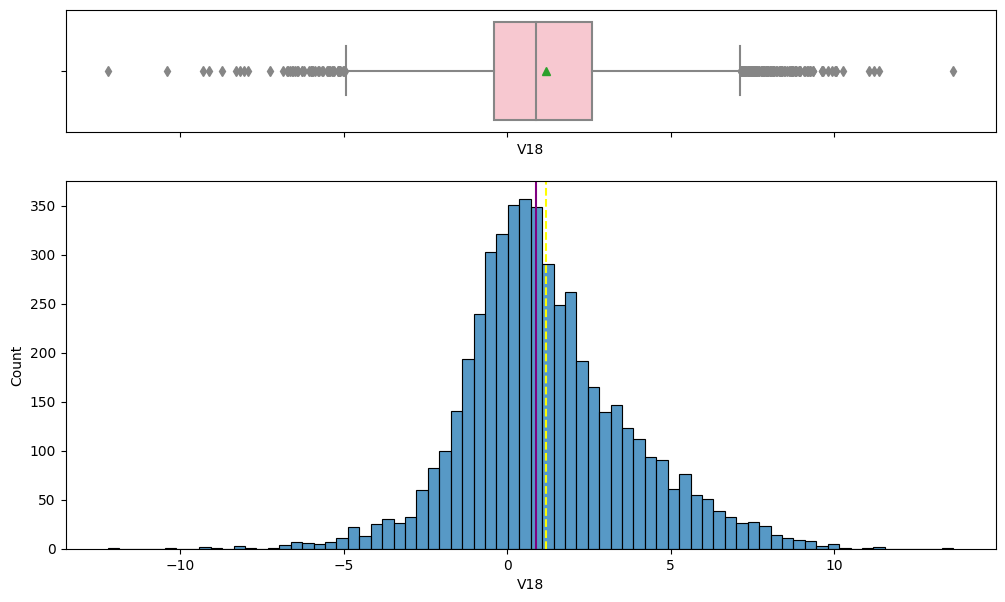

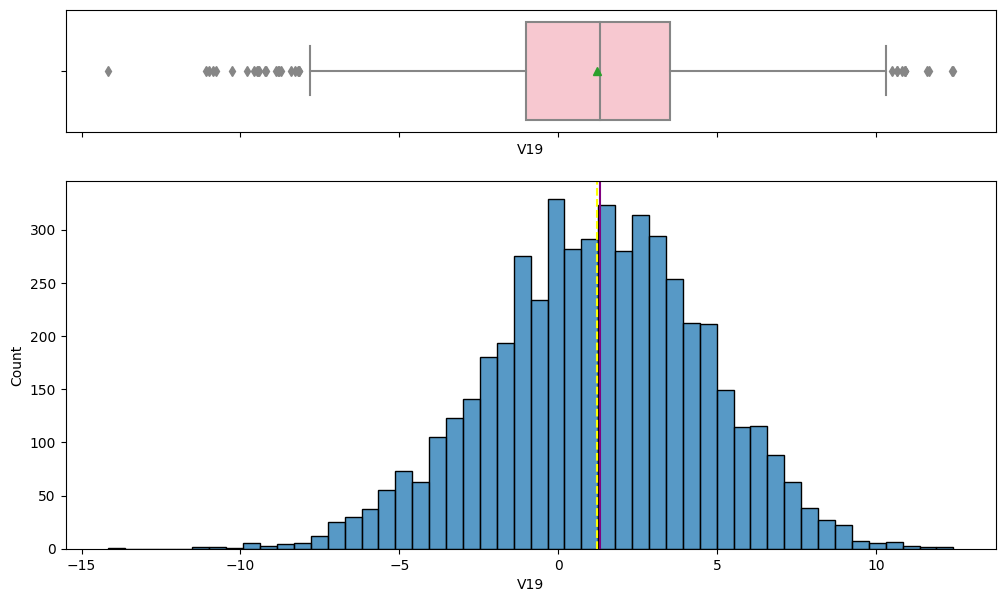

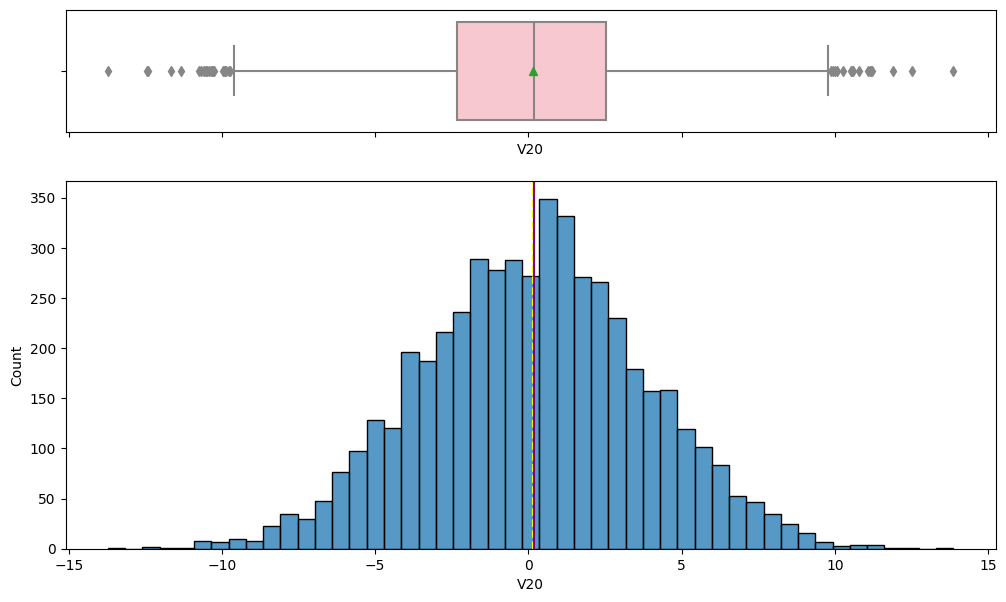

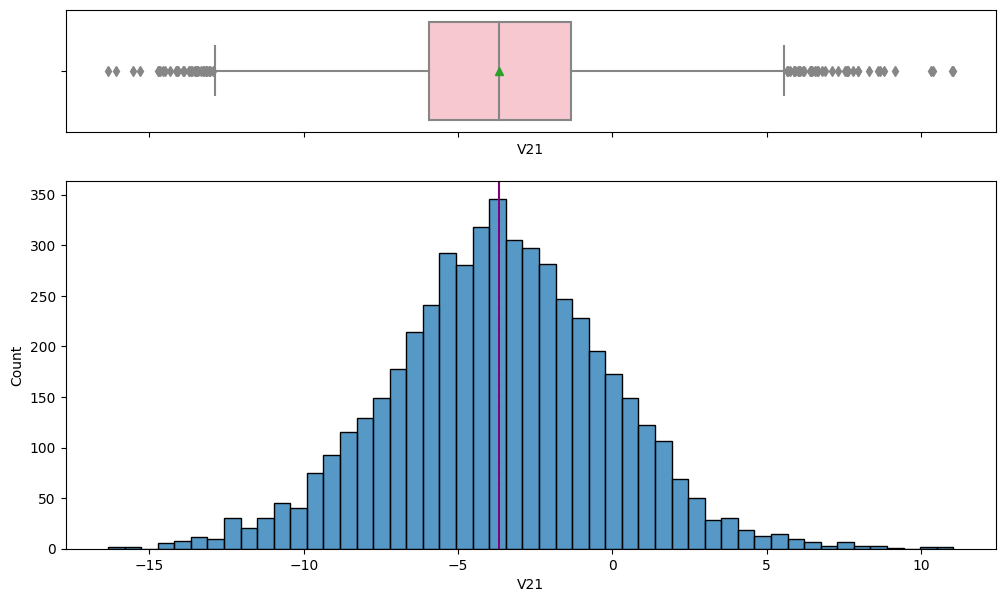

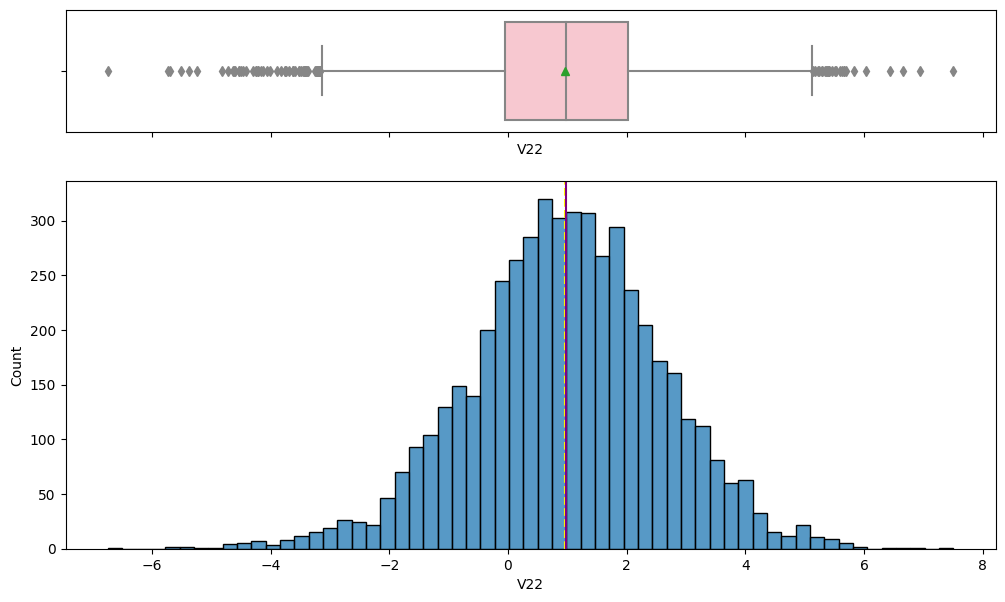

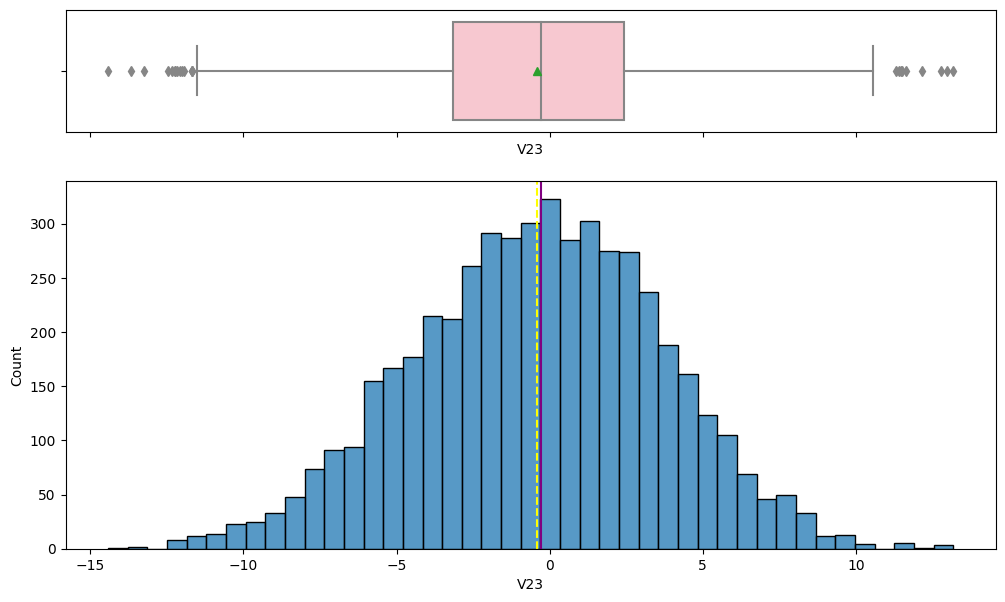

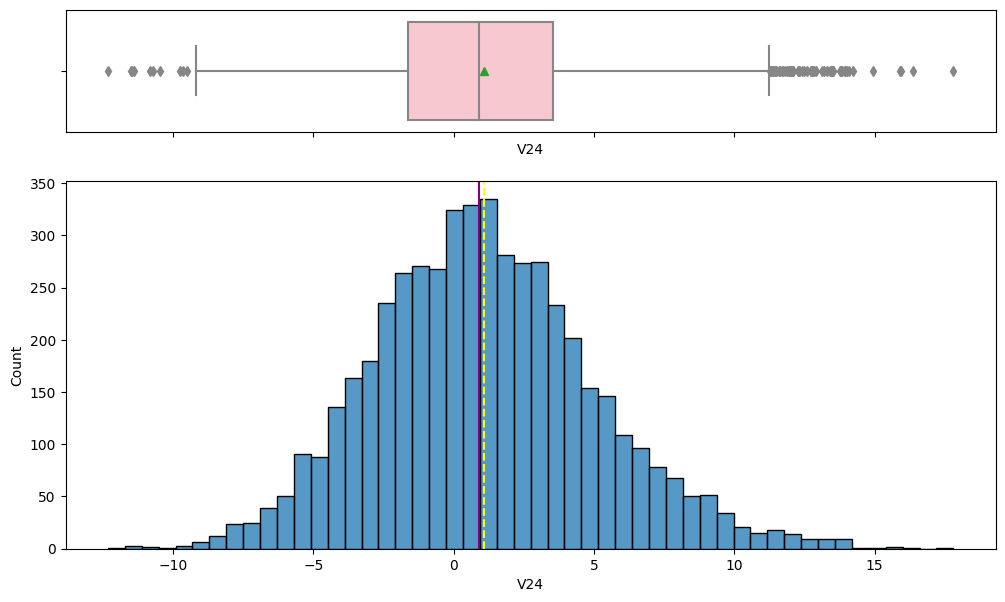

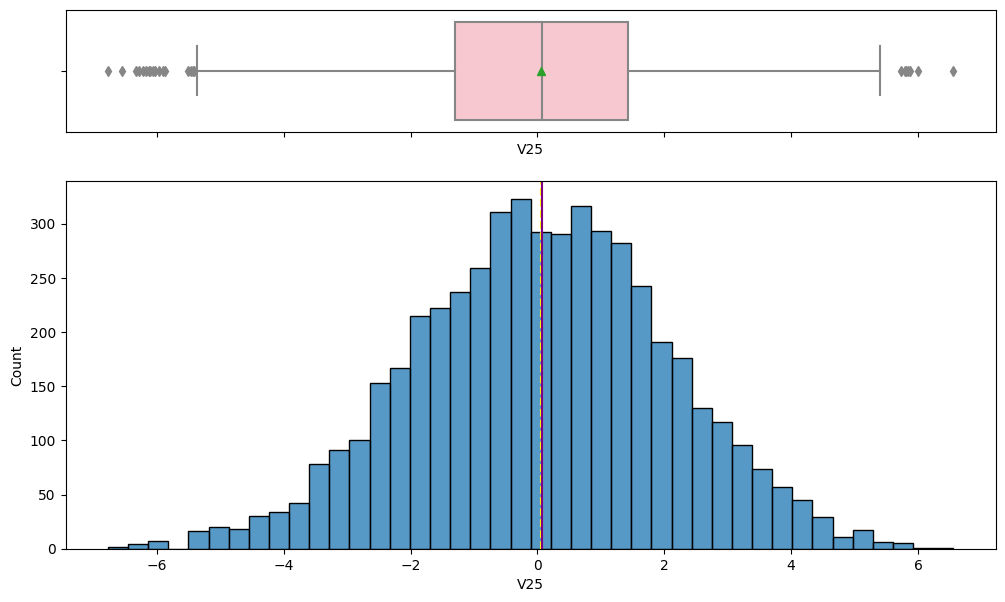

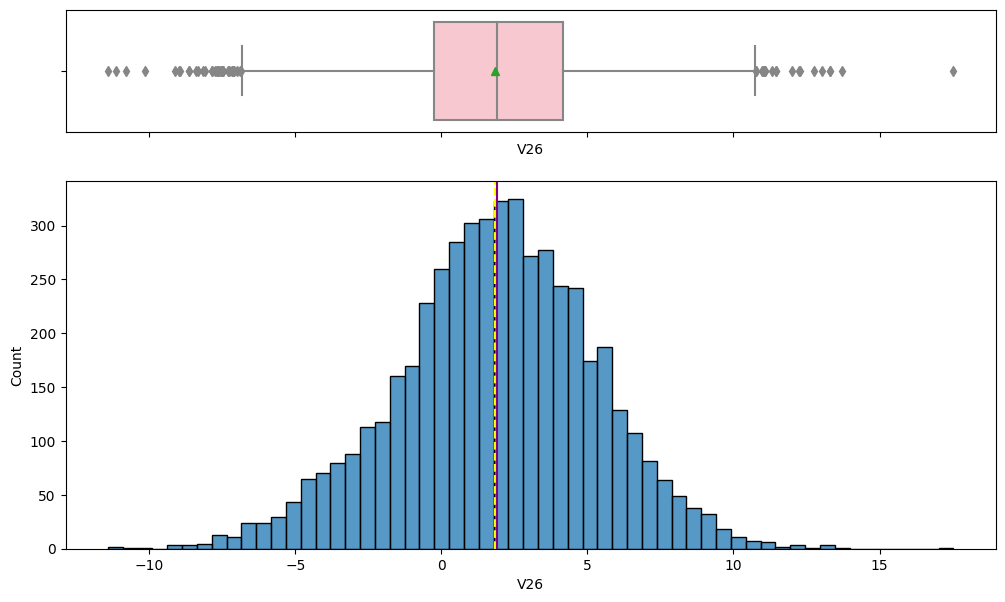

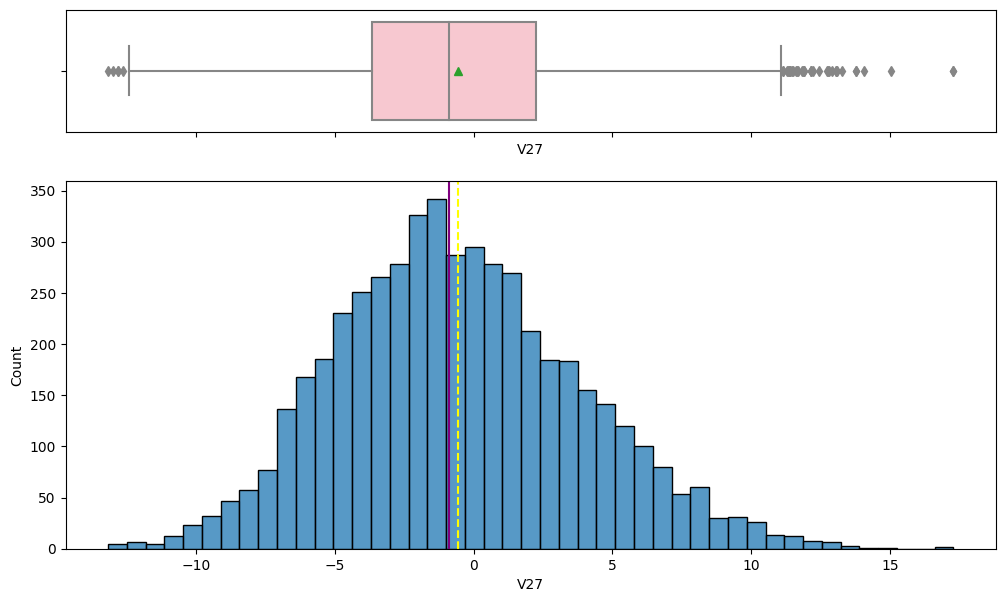

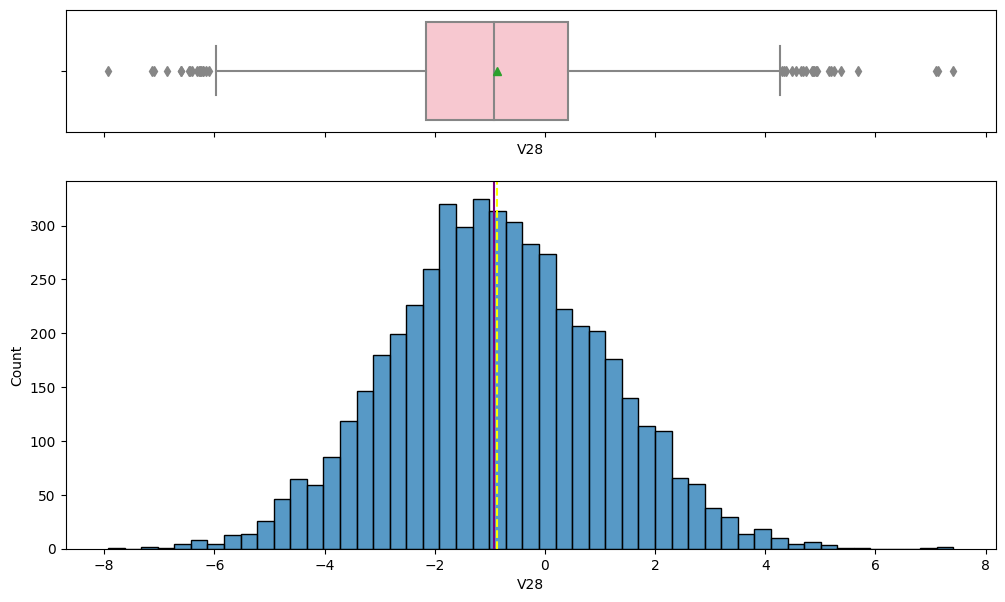

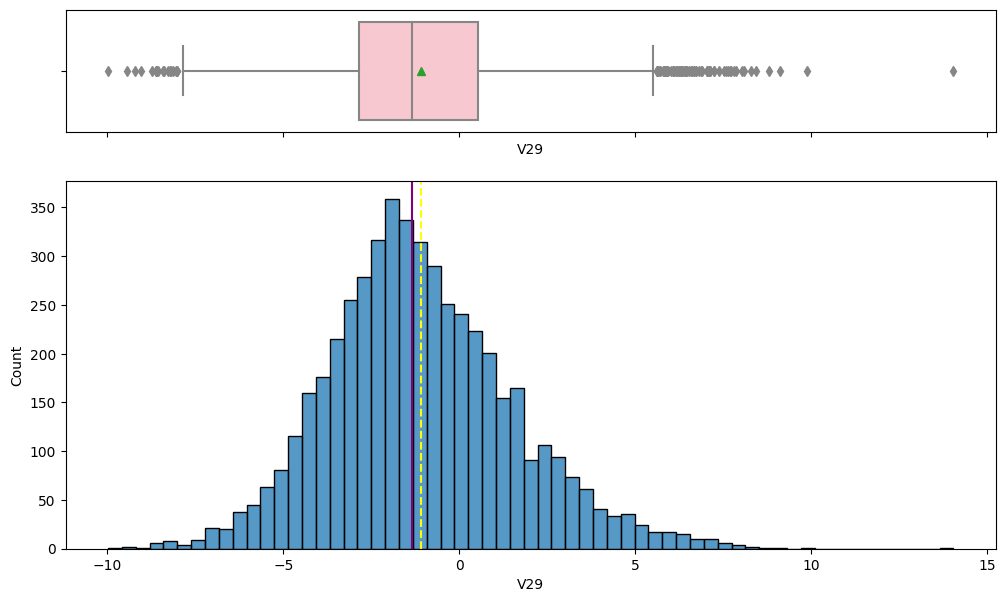

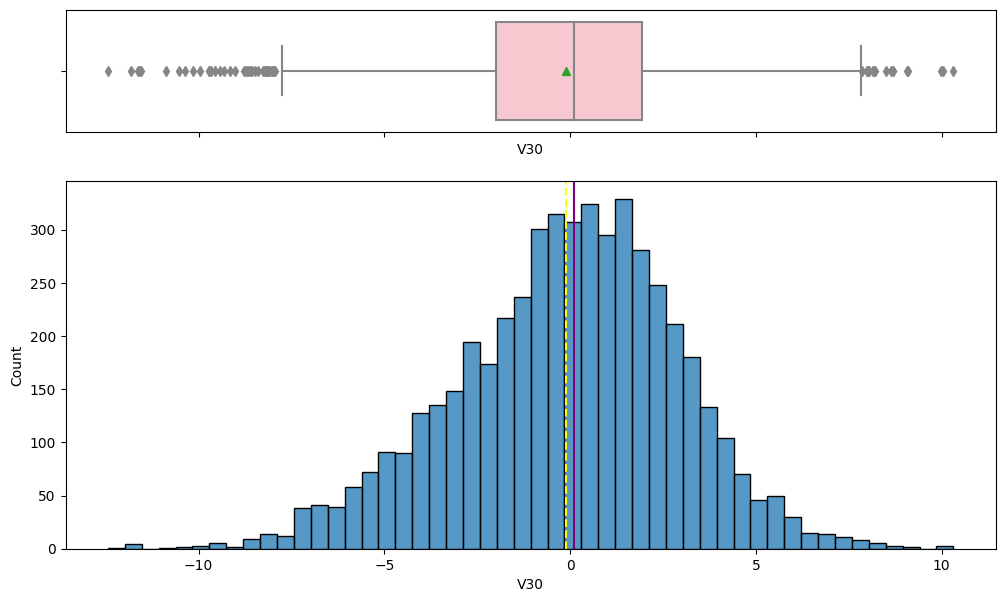

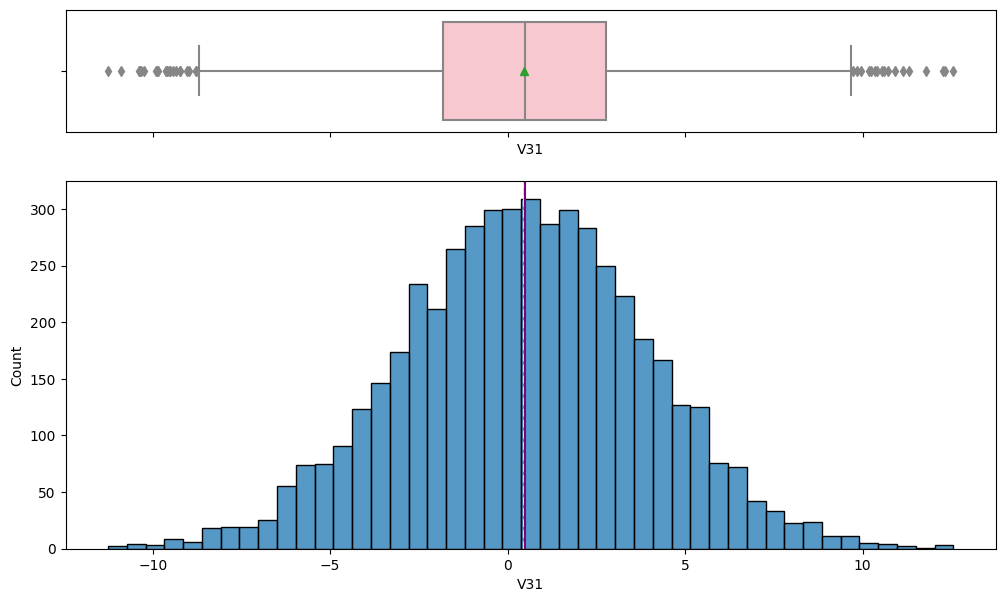

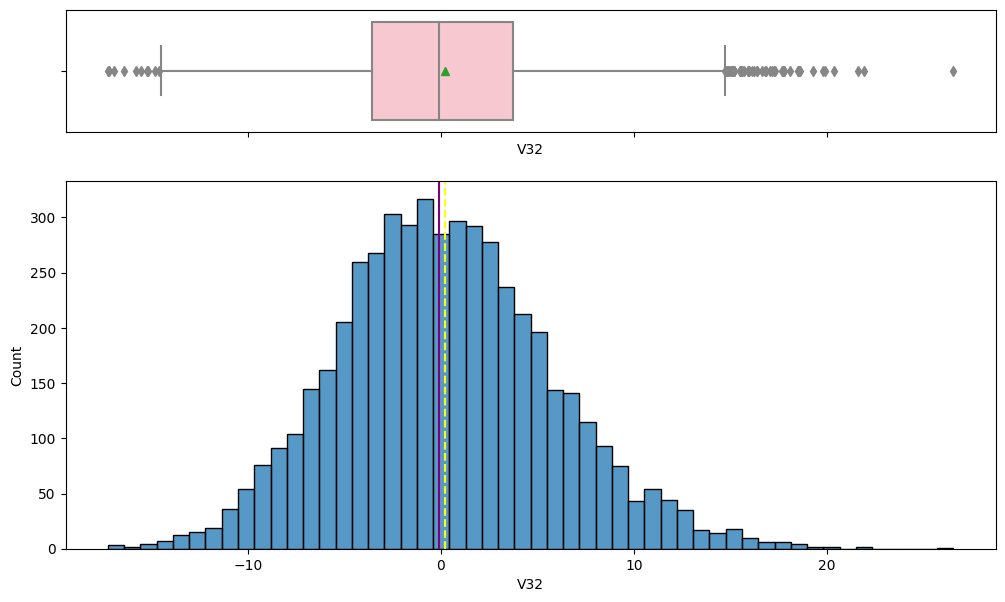

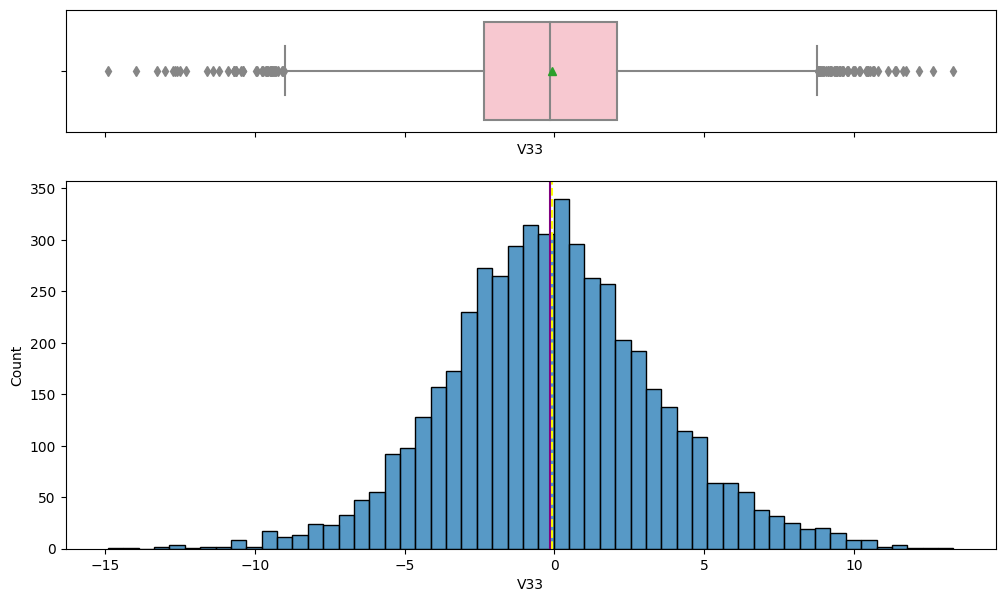

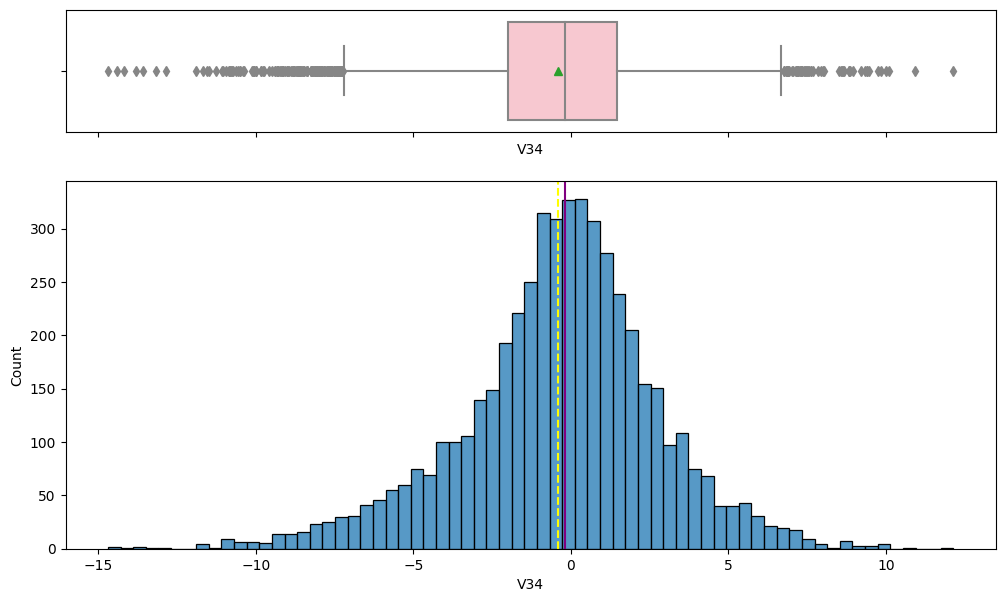

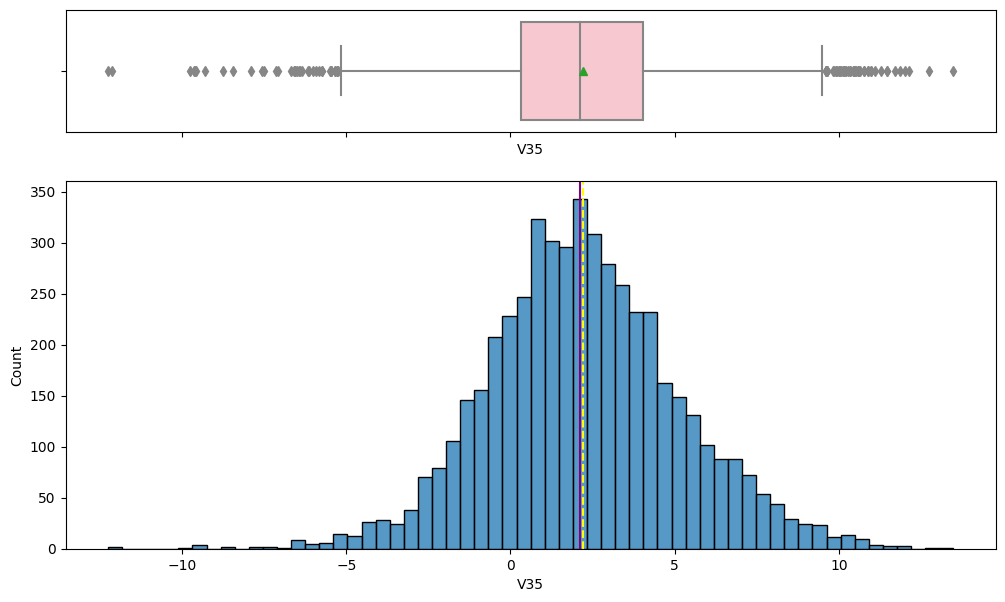

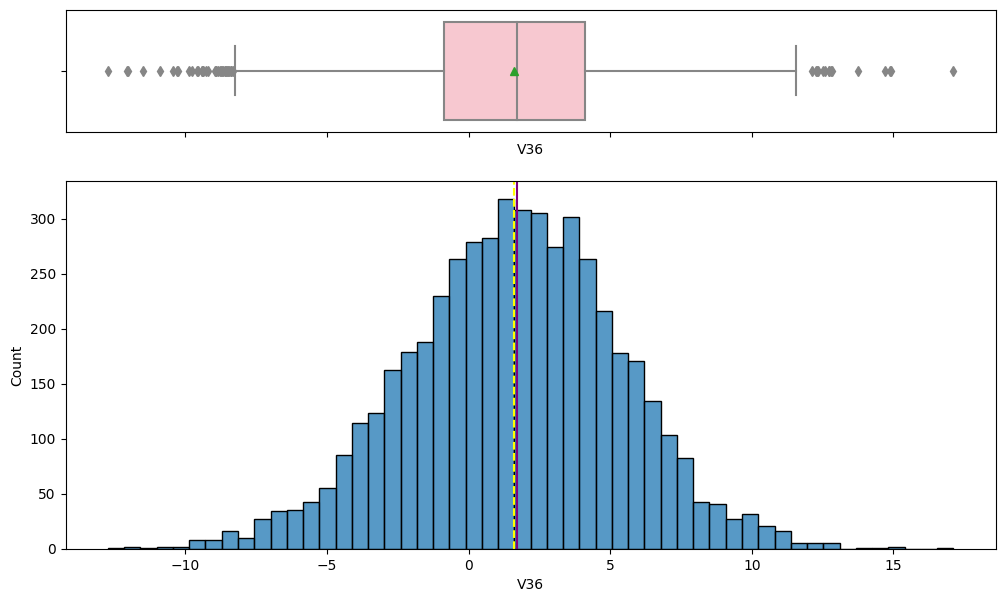

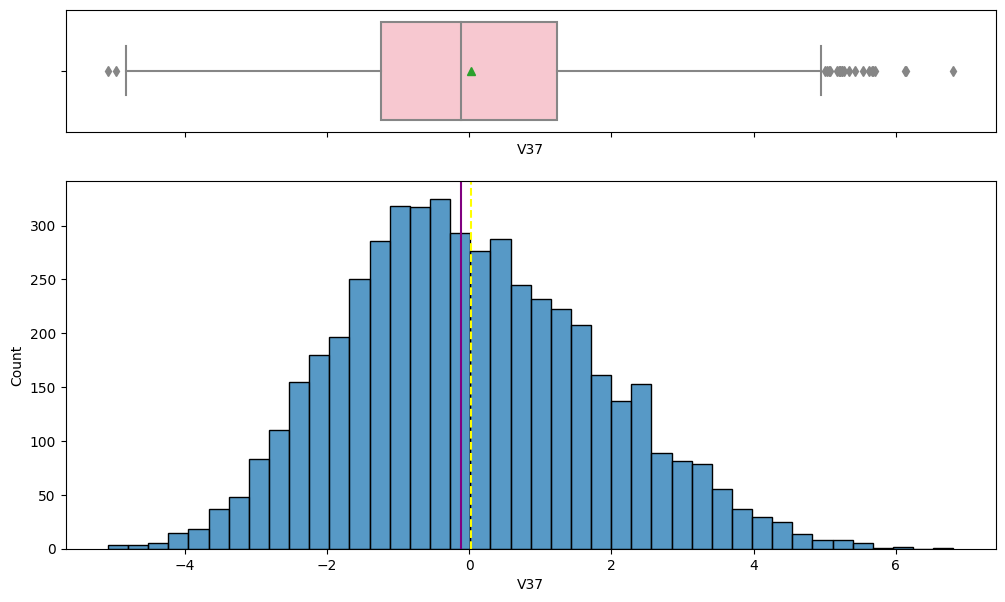

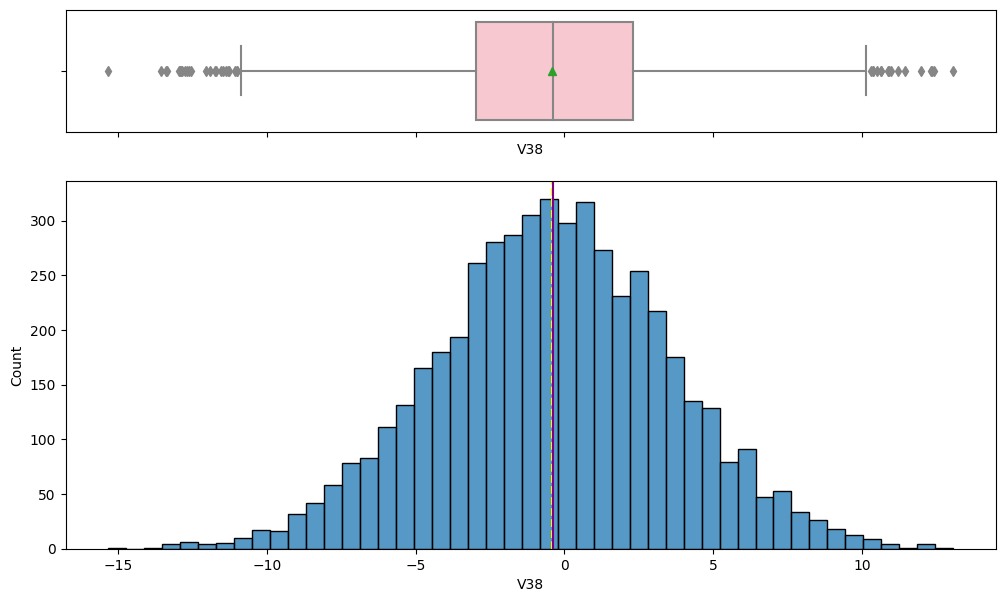

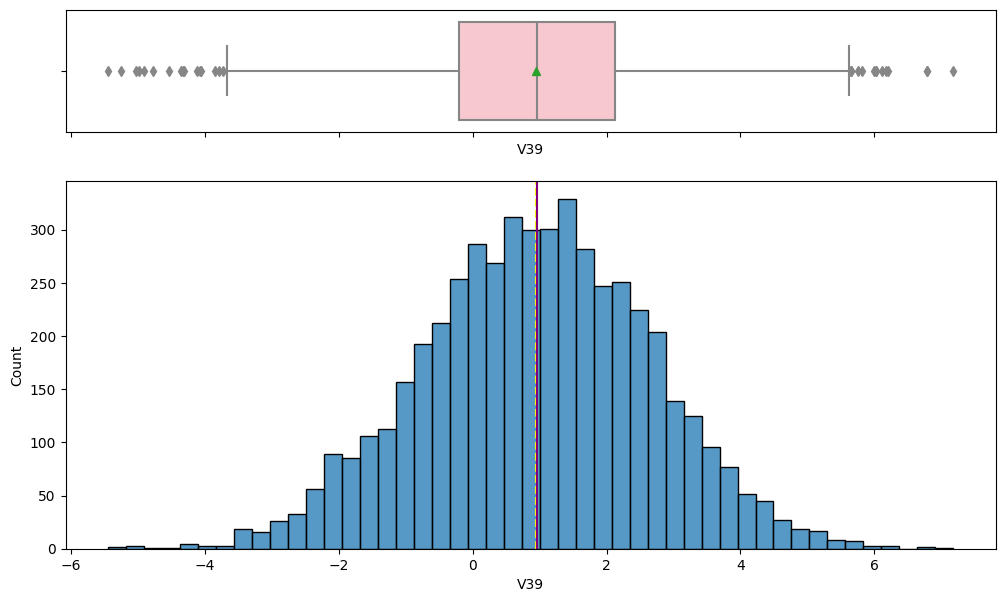

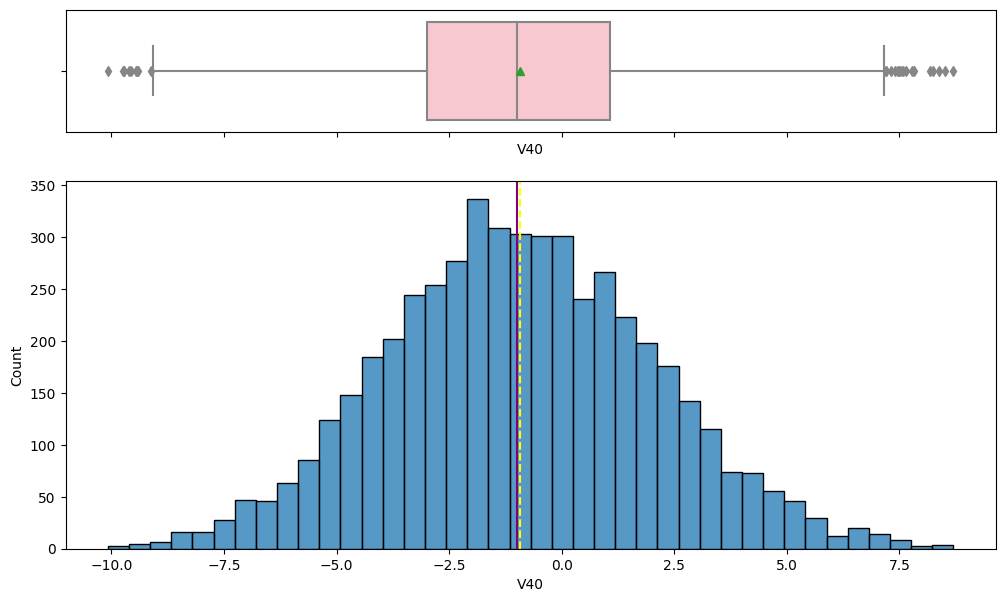

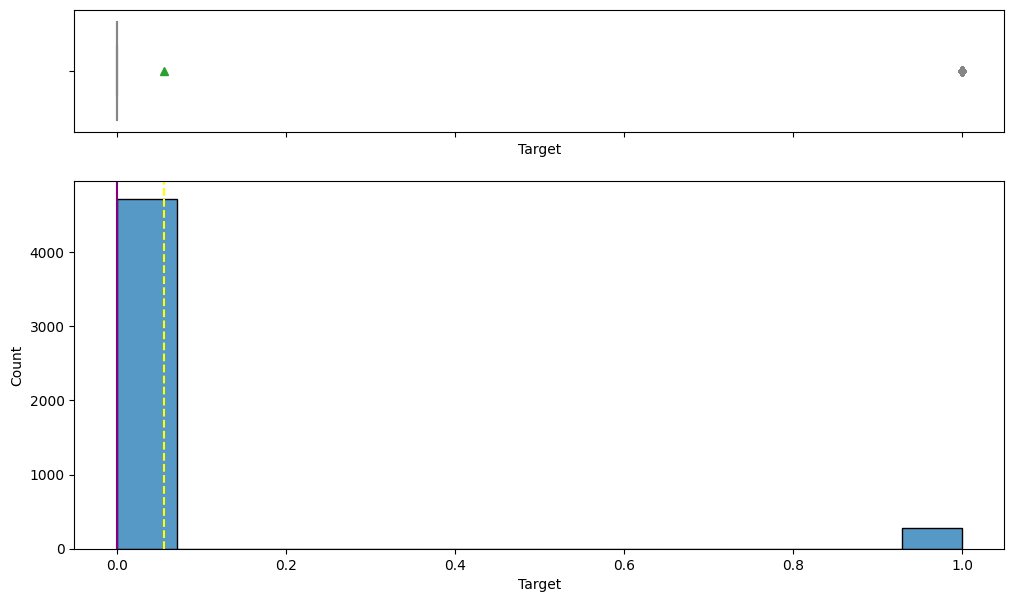

In [41]:
# Call function on all columns in test set
for feature in df.columns:
    histogram_boxplot(data_test, feature, figsize=(12, 7), kde=False, bins=None)

####Observations

- The distributions of each variable in the test set matches the distribution for the same variable in the train set.


In [42]:
# 1 = failure; 0 = no failure
# Check the distribution of classes
data_train["Target"].value_counts()

Target
0    18890
1     1110
Name: count, dtype: int64

In [43]:
# 1 = failure; 0 = no failure
# Check the distribution of classes
data_test["Target"].value_counts()

Target
0    4718
1     282
Name: count, dtype: int64

####Observations

- There are significantly less failures than non-failures in both the train and test sets.
- The train and test sets both have approximately 5.56% failure rate.


## Data Pre-Processing


In [44]:
# Divide train set into X and y 
X = data_train.drop(["Target"], axis=1)
y = data_train["Target"]

In [45]:
# Split train set into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)

print(X_train.shape, X_val.shape)

(15000, 40) (5000, 40)


####Observations

- There are 15,000 rows in the train set and 5,000 rows in the validation set.


## Missing value imputation


We will use the median to impute the missing values in "V1" and "V2" columns.


In [46]:
# Create the imputer
imputer = SimpleImputer(strategy="median")

In [47]:
# Fit the imputer on the train and validation sets
X_train= imputer.fit_transform(X_train)

X_val = imputer.transform(X_val)


In [48]:
# Re-check for missing values
print(pd.DataFrame(X_train).isna().sum())
print("-" * 30)

print(pd.DataFrame(X_val).isna().sum())

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
dtype: int64
------------------------------
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
dtype: int64


####Observations

- All missing values have been imputed for the train and validation sets.


## Model Building


### Model evaluation criterion


The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a generator where there is no detection by model.
- False positives (FP) are failure detections in a generator where there is no failure.

**Which metric to optimize?**

- We need to choose the metric which will ensure that the maximum number of generator failures are predicted correctly by the model.
- We would want Recall to be maximized as greater the Recall, the higher the chances of minimizing false negatives.
- We want to minimize false negatives because if a model predicts that a machine will have no failure when there will be a failure, it will increase the maintenance cost.


**Let's define a function to output different metrics (including recall) on the train and test set and a function to show confusion matrix so that we do not have to use the same code repetitively while evaluating models.**


In [49]:
# Define a function to compute classification performance metrics
def model_performance_classification_sklearn(model, predictors, target):
    
    # generate predictions using the model
    pred = model.predict(predictors)

    # calculate the classification metrics
    acc = accuracy_score(target, pred)  
    recall = recall_score(target, pred)
    precision = precision_score(target, pred)
    f1 = f1_score(target, pred)

    # create a dataframe to store the performance metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],)

    return df_perf

### Defining scorer to be used for cross-validation and hyperparameter tuning


- We want to reduce false negatives and will try to maximize "Recall".
- To maximize Recall, we can use Recall as a **scorer** in cross-validation and hyperparameter tuning.


In [50]:
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

### Model Building on original data


In [51]:
models = []  # Empty list to store models

# Append models to list
models.append(("Logistic regression", LogisticRegression(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Decision Tree", DecisionTreeClassifier(random_state=1)))
models.append(("Random Forest", RandomForestClassifier(random_state=1)))
models.append(("Gradient Boosting", GradientBoostingClassifier(random_state=1)))
models.append(("XGBoost", XGBClassifier(random_state=1)))
models.append(("ADABoost", AdaBoostClassifier(random_state=1)))

results = []  # Empty list to store model CV scores
names = []  # Empty list to store model names


# Loop through all models to get CV score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scorer, cv=kfold
    )
    results.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))



Cross-Validation performance on training dataset:

Logistic regression: 0.4927566553639709
Bagging: 0.7210807301060529
Decision Tree: 0.6982829521679532
Random Forest: 0.7235192266070268
Gradient Boosting: 0.7066661857008874
XGBoost: 0.7956208065796118
ADABoost: 0.6309140754635308

Validation Performance:

Logistic regression: 0.48201438848920863
Bagging: 0.7302158273381295
Decision Tree: 0.7050359712230215
Random Forest: 0.7266187050359713
Gradient Boosting: 0.7230215827338129
XGBoost: 0.8201438848920863
ADABoost: 0.6762589928057554


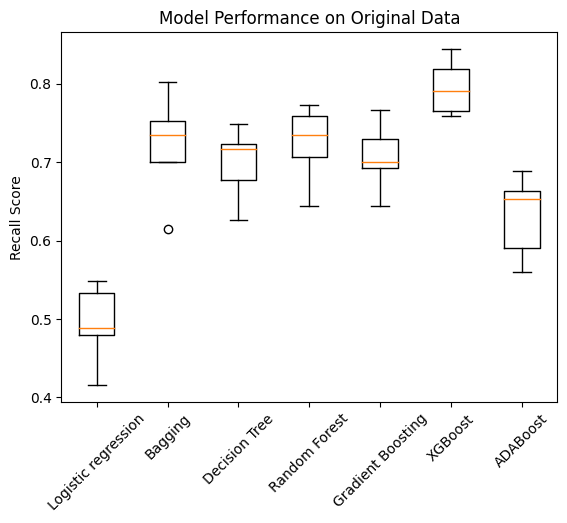

In [52]:
# Create boxplot of each model's CV score
plt.boxplot(results, labels=names)
plt.title("Model Performance on Original Data")
plt.ylabel("Recall Score")

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45)

plt.show()


####Observations

- The cross-validation recall scores are similar across the train and validation sets with logistic regression performing the worst with the lowest recall scores.
- The similarities indicate the models are not overfitting. However, there is room for improvement.


### Model Building with oversampled data


In [53]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)


print("After OverSampling, counts of label '1': {}".format(sum(y_train_over == 1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_train_over == 0)))


print("After OverSampling, the shape of train_X: {}".format(X_train_over.shape))
print("After OverSampling, the shape of train_y: {} \n".format(y_train_over.shape))

Before OverSampling, counts of label '1': 832
Before OverSampling, counts of label '0': 14168 

After OverSampling, counts of label '1': 14168
After OverSampling, counts of label '0': 14168 

After OverSampling, the shape of train_X: (28336, 40)
After OverSampling, the shape of train_y: (28336,) 



####Observations

- Before oversampling, there is an imbalance in the minority target attribute (1).
- SMOTE has been used to generate data points for the minority class (1: failure) K-nearest neighbors.
- Classes 1 and 0 are balanced after applying SMOTE.


In [54]:
models = []  # Empty list to store models

# Append models to list
models.append(("Logistic regression", LogisticRegression(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Decision Tree", DecisionTreeClassifier(random_state=1)))
models.append(("Random Forest", RandomForestClassifier(random_state=1)))
models.append(("Gradient Boosting", GradientBoostingClassifier(random_state=1)))
models.append(("XGBoost", XGBClassifier(random_state=1)))
models.append(("ADABoost", AdaBoostClassifier(random_state=1)))

results1 = []  # Empty list to store model CV scores
names = []  # Empty list to store model names

# Loop through all models to get CV score
print("\nCross-Validation performance on training dataset:\n")

for name, model in models:
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)  # Setting number of splits equal to 5
    cv_result = cross_val_score(estimator=model, X=X_train_over, y=y_train_over, scoring=scorer, cv=kfold)
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\nValidation Performance:\n")

for name, model in models:
    model.fit(X_train_over, y_train_over)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))



Cross-Validation performance on training dataset:

Logistic regression: 0.883963699328486
Bagging: 0.9762141471581656
Decision Tree: 0.9720494245534969
Random Forest: 0.9839075260047615
Gradient Boosting: 0.9256068151319724
XGBoost: 0.989554053559209
ADABoost: 0.8978689011775473

Validation Performance:

Logistic regression: 0.8489208633093526
Bagging: 0.8345323741007195
Decision Tree: 0.7769784172661871
Random Forest: 0.8489208633093526
Gradient Boosting: 0.8776978417266187
XGBoost: 0.8669064748201439
ADABoost: 0.8561151079136691


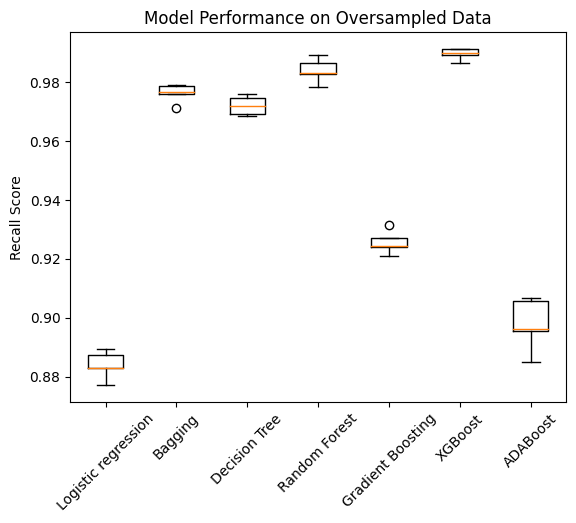

In [55]:
# Create boxplot of each model's CV score
plt.boxplot(results1, labels=names)
plt.title("Model Performance on Oversampled Data")

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45)

plt.ylabel("Recall Score")
plt.show()

####Observations

- The recall scores of both the training and validation sets has improved for most models.
- The decision tree model shows the largest recall score difference between the training and validation sets.


### Model Building with undersampled data


In [56]:
# Random undersampler for under sampling the data
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)


print("Before UnderSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before UnderSampling, counts of label '0': {} \n".format(sum(y_train == 0)))


print("After UnderSampling, counts of label '1': {}".format(sum(y_train_un == 1)))
print("After UnderSampling, counts of label '0': {} \n".format(sum(y_train_un == 0)))


print("After UnderSampling, the shape of train_X: {}".format(X_train_un.shape))
print("After UnderSampling, the shape of train_y: {} \n".format(y_train_un.shape))

Before UnderSampling, counts of label '1': 832
Before UnderSampling, counts of label '0': 14168 

After UnderSampling, counts of label '1': 832
After UnderSampling, counts of label '0': 832 

After UnderSampling, the shape of train_X: (1664, 40)
After UnderSampling, the shape of train_y: (1664,) 



####Observations

- Undersampling technique uses random samples from the majority class for model building.
- After undersampling, we have an equal number of class "1" and class "0."


In [57]:
models = []  # Empty list to store models

# Append models to list
models.append(("Logistic regression", LogisticRegression(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Decision Tree", DecisionTreeClassifier(random_state=1)))
models.append(("Random Forest", RandomForestClassifier(random_state=1)))
models.append(("AdaBoost", AdaBoostClassifier(random_state=1)))
models.append(("Gradient Boosting", GradientBoostingClassifier(random_state=1)))
models.append(("XGBoost", XGBClassifier(random_state=1)))


results2 = []  # Empty list to store model CV scores
names = []  # Empty list to store model names


# Loop through all models to get CV score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_un, y=y_train_un, scoring=scorer, cv=kfold
    )  ## Complete the code to build models on undersampled data
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train_un, y_train_un)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

Logistic regression: 0.8726138085275232
Bagging: 0.8641945025611427
Decision Tree: 0.8617776495202367
Random Forest: 0.9038669648654498
AdaBoost: 0.8666113556020489
Gradient Boosting: 0.8990621167303946
XGBoost: 0.9074742082100858

Validation Performance:

Logistic regression: 0.8525179856115108
Bagging: 0.8705035971223022
Decision Tree: 0.841726618705036
Random Forest: 0.8920863309352518
AdaBoost: 0.8489208633093526
Gradient Boosting: 0.8884892086330936
XGBoost: 0.9028776978417267


####Observations

- Recall scores have reduced slightly for most models on both training and validation sets compared to oversampled models.
- The decision tree model is performing better with undersampled data than the oversampled model.
- All recall scores are approximately equal across training and validation sets.


## Hyperparameter Tuning


### Sample Parameter Grids


**Hyperparameter tuning can take a long time to run, so to avoid that time complexity - you can use the following grids, wherever required.**

- For Gradient Boosting:

param_grid = {
"n_estimators": np.arange(100,150,25),
"learning_rate": [0.2, 0.05, 1],
"subsample":[0.5,0.7],
"max_features":[0.5,0.7]
}

- For Adaboost:

param_grid = {
"n_estimators": [100, 150, 200],
"learning_rate": [0.2, 0.05],
"base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=2, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1),
]
}

- For Bagging Classifier:

param_grid = {
'max_samples': [0.8,0.9,1],
'max_features': [0.7,0.8,0.9],
'n_estimators' : [30,50,70],
}

- For Random Forest:

param_grid = {
"n_estimators": [200,250,300],
"min_samples_leaf": np.arange(1, 4),
"max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
"max_samples": np.arange(0.4, 0.7, 0.1)
}

- For Decision Trees:

param_grid = {
'max_depth': np.arange(2,6),
'min_samples_leaf': [1, 4, 7],
'max_leaf_nodes' : [10, 15],
'min_impurity_decrease': [0.0001,0.001]
}

- For Logistic Regression:

param_grid = {'C': np.arange(0.1,1.1,0.1)}

- For XGBoost:

param_grid={
'n_estimators': [150, 200, 250],
'scale_pos_weight': [5,10],
'learning_rate': [0.1,0.2],
'gamma': [0,3,5],
'subsample': [0.8,0.9]
}


### Tuning Gradient Boosting using oversampled data


In [58]:
# defining model
Model_GBM = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid={"n_estimators": np.arange(100,150,25), 
            "learning_rate": [0.2, 0.05, 1], 
            "subsample":[0.5,0.7], 
            "max_features":[0.5,0.7]}

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    estimator=Model_GBM,
    param_distributions=param_grid,
    scoring=scorer,
    n_iter=50,
    n_jobs=-1,
    cv=5,
    random_state=1)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over, y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.5, 'learning_rate': 1} with CV score=0.9724734521882811:


In [59]:
# Creating new pipeline with best parameters
tuned_gbm_over = GradientBoostingClassifier(
    max_features=0.5,
    random_state=1,
    learning_rate=1,
    n_estimators=125,
    subsample=0.7,)

# Fitting the model on oversampled data
tuned_gbm_over.fit(X_train_over, y_train_over)

GradientBoostingClassifier(learning_rate=1, max_features=0.5, n_estimators=125,
                           random_state=1, subsample=0.7)

In [60]:
# Check performance of train data
gbm_train_perf = model_performance_classification_sklearn(tuned_gbm_over, X_train_over, y_train_over)
print(gbm_train_perf)

   Accuracy  Recall  Precision    F1
0     0.993   0.993      0.994 0.993


In [61]:
# Check performance of validation data
gbm_val_perf = model_performance_classification_sklearn(tuned_gbm_over, X_val, y_val)
print(gbm_val_perf)

   Accuracy  Recall  Precision    F1
0     0.970   0.842      0.692 0.760


####Observations

- The model performed well on the train set. However, there is a drop precision and F1-score for the validation set.
- The model is overfitting to the train set and not generalizing well to the validation set.


### Tuning Gradient Boosting using undersampled data


In [62]:
# defining model
Model_GBM_Un = GradientBoostingClassifier(random_state=1)

#P arameter grid to pass in RandomSearchCV
param_grid={"n_estimators": np.arange(100,150,25),
            "learning_rate": [0.2, 0.05, 1],
            "subsample":[0.5,0.7],
            "max_features":[0.5,0.7]}

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model_GBM_Un,
                                   param_distributions=param_grid,
                                   scoring=scorer,
                                   n_iter=50,
                                   n_jobs=-1, 
                                   cv=5,
                                   random_state=1)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un, y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.5, 'n_estimators': 100, 'max_features': 0.7, 'learning_rate': 0.2} with CV score=0.9038164634586249:


In [63]:
# Creating new pipeline with best parameters
tuned_gbm_un = GradientBoostingClassifier(
    max_features=0.7,
    random_state=1,
    learning_rate=0.2,
    n_estimators=100,
    subsample=0.5,)

# Fitting the model on undersamnpled data
tuned_gbm_un.fit(X_train_un, y_train_un)

GradientBoostingClassifier(learning_rate=0.2, max_features=0.7, random_state=1,
                           subsample=0.5)

In [64]:
# Check performance of train data
gbm_train_perf_un = model_performance_classification_sklearn(tuned_gbm_un, X_train_un, y_train_un)
print(gbm_train_perf_un)

   Accuracy  Recall  Precision    F1
0     0.986   0.978      0.994 0.986


In [65]:
# Check performance of validation data
gbm_val_perf_un = model_performance_classification_sklearn(tuned_gbm_un, X_val, y_val)
print(gbm_val_perf_un)

   Accuracy  Recall  Precision    F1
0     0.914   0.896      0.382 0.535


####Observations

- The model performed well on the train set. However, there is a drop precision and F1-score for the validation set.
- The model is overfitting to the train set and not generalizing well to the validation set.


### Tuning AdaBoost using oversampled data


In [66]:
# defining model
Model_ADA = AdaBoostClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.2, 0.05],
    "estimator": [DecisionTreeClassifier(max_depth=1, random_state=1),
                  DecisionTreeClassifier(max_depth=2, random_state=1),
                  DecisionTreeClassifier(max_depth=3, random_state=1),]}


# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model_ADA,
                                   param_distributions=param_grid,
                                   n_iter=50, 
                                   n_jobs=-1, 
                                   scoring=scorer, 
                                   cv=5, 
                                   random_state=1)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 200, 'learning_rate': 0.2, 'estimator': DecisionTreeClassifier(max_depth=3, random_state=1)} with CV score=0.971555946263926:


In [67]:
# Creating new pipeline with best parameters
tuned_ada = AdaBoostClassifier(
    n_estimators=200,
    learning_rate=0.2,
    estimator= DecisionTreeClassifier(max_depth=3, random_state=1))

# Fitting the model on oversampled data
tuned_ada.fit(X_train_over, y_train_over)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    random_state=1),
                   learning_rate=0.2, n_estimators=200)

In [68]:
# Check performance of train data
ada_train_perf = model_performance_classification_sklearn(tuned_ada, X_train_over, y_train_over)
ada_train_perf

,Accuracy,Recall,Precision,F1
0,0.992,0.988,0.995,0.992


In [69]:
# Check performance of validation data
ada_val_perf = model_performance_classification_sklearn(tuned_ada, X_val, y_val)
ada_val_perf

,Accuracy,Recall,Precision,F1
0,0.979,0.849,0.789,0.818


####Observations

- The model performed well on the train and validation sets.
- There is a slight room for improvement on the validation set.


### Tuning AdaBoost using undersampled data


In [70]:
# defining model
Model_ADA_Un = AdaBoostClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.2, 0.05],
    "estimator": [DecisionTreeClassifier(max_depth=1, random_state=1),
                  DecisionTreeClassifier(max_depth=2, random_state=1),
                  DecisionTreeClassifier(max_depth=3, random_state=1),]}


# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model_ADA_Un,
                                   param_distributions=param_grid,
                                   n_iter=50,
                                   n_jobs=-1,
                                   scoring=scorer,
                                   cv=5,
                                   random_state=1)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 200, 'learning_rate': 0.05, 'estimator': DecisionTreeClassifier(max_depth=2, random_state=1)} with CV score=0.8906283817906356:


In [71]:
# Creating new pipeline with best parameters
tuned_ada_un = AdaBoostClassifier(
    n_estimators=200,
    learning_rate=0.05,
    estimator= DecisionTreeClassifier(max_depth=2, random_state=1))

# Fitting the model on undersampled data
tuned_ada_un.fit(X_train_un, y_train_un)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                    random_state=1),
                   learning_rate=0.05, n_estimators=200)

In [72]:
# Check performance of train data
ada_train_perf_un = model_performance_classification_sklearn(tuned_ada_un, X_train_un, y_train_un)
ada_train_perf_un

,Accuracy,Recall,Precision,F1
0,0.950,0.916,0.982,0.948


In [73]:
# Check performance of validation data
ada_val_perf_un = model_performance_classification_sklearn(tuned_ada_un, X_val, y_val)
ada_val_perf_un

,Accuracy,Recall,Precision,F1
0,0.930,0.878,0.436,0.582


####Observations

- The model performed well on the train set. However, there is a drop in precision, recall, and F1-score for the validation set.
- The model is overfitting to the train set and not generalizing well to the validation set.


### Tuning Bagging Classifier using oversampled data


In [74]:
# defining model
Model_bag = BaggingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    'max_samples': [0.8, 0.9, 1],
    'max_features': [0.7, 0.8, 0.9],
    'n_estimators': [30, 50, 70],}


# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model_bag,
                                   param_distributions=param_grid,
                                   n_iter=50,
                                   n_jobs=-1,
                                   scoring=scorer,
                                   cv=5,
                                   random_state=1)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 70, 'max_samples': 0.9, 'max_features': 0.8} with CV score=0.9828488269988673:


In [75]:
# Creating new pipeline with best parameters
tuned_bag_over = BaggingClassifier(
    max_samples=0.9,
    max_features=0.8,
    n_estimators=70,)

# Fitting the model on oversampled data
tuned_bag_over.fit(X_train_over, y_train_over)

BaggingClassifier(max_features=0.8, max_samples=0.9, n_estimators=70)

In [76]:
# Check performance of train data
bag_train_perf = model_performance_classification_sklearn(tuned_bag_over, X_train_over, y_train_over)
bag_train_perf

,Accuracy,Recall,Precision,F1
0,1.000,1.000,1.000,1.000


In [77]:
# Check performance of validation data
bag_val_perf = model_performance_classification_sklearn(tuned_bag_over, X_val, y_val)
bag_val_perf

,Accuracy,Recall,Precision,F1
0,0.985,0.860,0.866,0.863


####Observations

- Both models performed well. However, the perfect performance of the train set and reduced performance of the validation set signifies overfitting.
- Overall, adjustments needs to made to better generalize new data.


### Tuning Bagging Classifier using Undersampled data


In [78]:
# defining model
Model_bag_un = BaggingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    'max_samples': [0.8, 0.9, 1],
    'max_features': [0.7, 0.8, 0.9],
    'n_estimators': [30, 50, 70],}

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model_bag_un,
                                   param_distributions=param_grid,
                                   n_iter=50,
                                   n_jobs=-1,
                                   scoring=scorer,
                                   cv=5,
                                   random_state=1)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 70, 'max_samples': 0.9, 'max_features': 0.9} with CV score=0.8966236202294207:


In [79]:
# Creating new pipeline with best parameters
tuned_bag_un = BaggingClassifier(
    max_samples=0.9,
    max_features=0.9,
    n_estimators=70,)

# Fitting the model on undersampled data
tuned_bag_un.fit(X_train_un, y_train_un)

BaggingClassifier(max_features=0.9, max_samples=0.9, n_estimators=70)

In [80]:
# Check performance of train data
bag_train_perf_un = model_performance_classification_sklearn(tuned_bag_un, X_train_un, y_train_un)
bag_train_perf_un

,Accuracy,Recall,Precision,F1
0,0.999,0.999,1.000,0.999


In [81]:
# Check performance of validation data
bag_val_perf_un = model_performance_classification_sklearn(tuned_bag_un, X_val, y_val)
bag_val_perf_un

,Accuracy,Recall,Precision,F1
0,0.936,0.892,0.462,0.609


####Observations

- The model is overfitting. The train set has near perfect scores while the validation set shows significant drops in F-1, recall, and precision scores.


### Tuning Random forest using oversampled data


In [82]:
# defining model
Model_RF = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)}


# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model_RF,
                                   param_distributions=param_grid,
                                   n_iter=50,
                                   n_jobs=-1,
                                   scoring=scorer,
                                   cv=5,
                                   random_state=1)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over, y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))


Best parameters are {'n_estimators': 200, 'min_samples_leaf': 1, 'max_samples': 0.6, 'max_features': 'sqrt'} with CV score=0.9818606498020482:


In [83]:
# Creating new pipeline with best parameters
tuned_rf2_over = RandomForestClassifier(
    max_features= 'sqrt',
    random_state=1,
    max_samples= 0.6,
    n_estimators=200,
    min_samples_leaf=1,)

# Fitting the model on oversampled data
tuned_rf2_over.fit(X_train_over, y_train_over)

RandomForestClassifier(max_samples=0.6, n_estimators=200, random_state=1)

In [84]:
# Check performance of train data
rf2_train_perf = model_performance_classification_sklearn(tuned_rf2_over, X_train_over, y_train_over)
rf2_train_perf

,Accuracy,Recall,Precision,F1
0,1.000,0.999,1.000,1.000


In [85]:
# Check performance of validation data
rf2_val_perf = model_performance_classification_sklearn(tuned_rf2_over, X_val, y_val)
rf2_val_perf


,Accuracy,Recall,Precision,F1
0,0.988,0.863,0.920,0.891


####Observations

- The model is overfitting the training set. The train set achieves almost perfect scores while the validation set receives lower precision, recall, and F1-score.


### Tuning Random forest using undersampled data


In [86]:
# defining model
Model_rf_un = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)}


# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model_rf_un,
                                   param_distributions=param_grid,
                                   n_iter=50,
                                   n_jobs=-1,
                                   scoring=scorer,
                                   cv=5,
                                   random_state=1)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un, y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))


Best parameters are {'n_estimators': 300, 'min_samples_leaf': 2, 'max_samples': 0.5, 'max_features': 'sqrt'} with CV score=0.8990116153235697:


In [87]:
# Creating new pipeline with best parameters
tuned_rf2_un = RandomForestClassifier(
    max_features= 'sqrt',
    random_state=1,
    max_samples= 0.5,
    n_estimators=300,
    min_samples_leaf=2,)

# Fitting the model to undersampled data
tuned_rf2_un.fit(X_train_un, y_train_un)

RandomForestClassifier(max_samples=0.5, min_samples_leaf=2, n_estimators=300,
                       random_state=1)

In [88]:
# Check performance of train data
rf2_train_perf_un = model_performance_classification_sklearn(tuned_rf2_un, X_train_un, y_train_un)
rf2_train_perf_un


,Accuracy,Recall,Precision,F1
0,0.961,0.933,0.989,0.960


In [89]:
# Check performance of validation data
rf2_val_perf_un = model_performance_classification_sklearn(tuned_rf2_un, X_val, y_val)
rf2_val_perf_un


,Accuracy,Recall,Precision,F1
0,0.938,0.885,0.468,0.612


####Observations

- The model is overfitting. The validation set shows significant drops in F-1, recall, and precision scores.


### Tuning Decision Tree using oversampled data


In [90]:
# defining model
Model_dt = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'max_depth': np.arange(2,6),
              'min_samples_leaf': [1, 4, 7], 
              'max_leaf_nodes' : [10,15],
              'min_impurity_decrease': [0.0001,0.001] }

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model_dt, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'min_samples_leaf': 7, 'min_impurity_decrease': 0.001, 'max_leaf_nodes': 15, 'max_depth': 3} with CV score=0.9102913265648006:


In [91]:
# Creating new pipeline with best parameters
tuned_tree_over = DecisionTreeClassifier(
    min_samples_leaf= 7,
    random_state=1,
    min_impurity_decrease=0.001,
    max_leaf_nodes=15,
    max_depth=3)

# Fitting the model to oversampled data
tuned_tree_over.fit(X_train_over, y_train_over)

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=15,
                       min_impurity_decrease=0.001, min_samples_leaf=7,
                       random_state=1)

In [92]:
# Check performance of train data
tree_train_perf = model_performance_classification_sklearn(tuned_tree_over, X_train_over, y_train_over)
tree_train_perf

,Accuracy,Recall,Precision,F1
0,0.843,0.917,0.799,0.854


In [93]:
# Check performance of validation data
tree_val_perf = model_performance_classification_sklearn(tuned_tree_over, X_val, y_val)
tree_val_perf

,Accuracy,Recall,Precision,F1
0,0.763,0.885,0.176,0.294


####Observations

- The model is overfitting. It performs relatively well on the train set.
- The validation set shows extremely low F1-score and precision scores.


### Tuning Decision Tree using undersampled data


In [94]:
# defining model
Model_dt_un = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'max_depth': np.arange(2,6),
              'min_samples_leaf': [1, 4, 7], 
              'max_leaf_nodes' : [10,15],
              'min_impurity_decrease': [0.0001,0.001] }

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model_dt_un,
                                   param_distributions=param_grid,
                                   n_iter=10,
                                   n_jobs=-1, 
                                   scoring=scorer,
                                   cv=5,
                                   random_state=1)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'min_samples_leaf': 7, 'min_impurity_decrease': 0.0001, 'max_leaf_nodes': 10, 'max_depth': 2} with CV score=0.850811629752543:


In [95]:
# Creating new pipeline with best parameters
tuned_tree_un = DecisionTreeClassifier(
    min_samples_leaf= 7,
    random_state=1,
    min_impurity_decrease=0.0001,
    max_leaf_nodes=10,
    max_depth=2)

#Fitting the model on undersampled data
tuned_tree_un.fit(X_train_un, y_train_un)

DecisionTreeClassifier(max_depth=2, max_leaf_nodes=10,
                       min_impurity_decrease=0.0001, min_samples_leaf=7,
                       random_state=1)

In [96]:
# Check performance of train data
tree_train_perf_un = model_performance_classification_sklearn(tuned_tree_un, X_train_un, y_train_un)
tree_train_perf_un

,Accuracy,Recall,Precision,F1
0,0.764,0.909,0.705,0.794


In [97]:
# Check performance of validation data
tree_val_perf_un = model_performance_classification_sklearn(tuned_tree_un, X_val, y_val)
tree_val_perf_un

,Accuracy,Recall,Precision,F1
0,0.609,0.888,0.114,0.202


####Observations

- The model is overfitting.
- The validation set shows extremely low accuracy, F1-score, and precision.


### Tuning Logistic Regression using oversampled data


In [98]:
# defining model
Model_log = LogisticRegression(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'C': np.arange(0.1,1.1,0.1)}

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model_log,
                                   param_distributions=param_grid,
                                   n_iter=10,
                                   n_jobs=-1,
                                   scoring=scorer,
                                   cv=5,
                                   random_state=1)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'C': 0.1} with CV score=0.8838231041005031:


In [99]:
# Creating new pipeline with best parameters
tuned_regression = LogisticRegression(
    C=0.1)

# Fitting the model on oversampled data
tuned_regression.fit(X_train_over, y_train_over)

LogisticRegression(C=0.1)

In [100]:
# Check performance of train data
regression_train_perf = model_performance_classification_sklearn(tuned_regression, X_train_over, y_train_over)
regression_train_perf

,Accuracy,Recall,Precision,F1
0,0.880,0.884,0.878,0.881


In [101]:
# Check performance of validation data
regression_val_perf = model_performance_classification_sklearn(tuned_regression, X_val, y_val)
regression_val_perf

,Accuracy,Recall,Precision,F1
0,0.868,0.849,0.277,0.418


####Observations

- The model is overfitting.
- The validation set shows extremeley low precision and f1-score.


### Tuning Logistic Regression using undersampled data


In [102]:
# defining model
Model_log_un = LogisticRegression(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'C': np.arange(0.1,1.1,0.1)}

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model_log_un,
                                   param_distributions=param_grid,
                                   n_iter=10,
                                   n_jobs=-1,
                                   scoring=scorer,
                                   cv=5,
                                   random_state=1)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'C': 0.1} with CV score=0.8653560349181155:


In [103]:
# Creating new pipeline with best parameters
tuned_regression_un = LogisticRegression(
    C=0.1)

# Fitting the model on undersampled data
tuned_regression_un.fit(X_train_un, y_train_un)

LogisticRegression(C=0.1)

In [104]:
# Check performance of train data
regression_train_perf_un = model_performance_classification_sklearn(tuned_regression_un, X_train_un, y_train_un)
regression_train_perf_un

,Accuracy,Recall,Precision,F1
0,0.873,0.875,0.872,0.873


In [105]:
# Check performance of validation data
regression_val_perf_un = model_performance_classification_sklearn(tuned_regression_un, X_val, y_val)
regression_val_perf_un

,Accuracy,Recall,Precision,F1
0,0.857,0.853,0.260,0.399


####Observations

- The model is overfitting.
- The validation set scored low in precision and f1-score.


### Tuning XGBoost using oversampled data


**Note**: You can choose to skip this section if XGBoost gives error.


In [106]:
# defining model
Model_xg = XGBClassifier(random_state=1,eval_metric='logloss')

#Parameter grid to pass in RandomSearchCV
param_grid={'n_estimators':[150,200,250],
            'scale_pos_weight':[5,10],
            'learning_rate':[0.1,0.2],
            'gamma':[0,3,5],
            'subsample':[0.8,0.9]}

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model_xg,
                                   param_distributions=param_grid,
                                   n_iter=50,
                                   n_jobs=-1,
                                   scoring=scorer,
                                   cv=5,
                                   random_state=1)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over, y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))


Best parameters are {'subsample': 0.8, 'scale_pos_weight': 10, 'n_estimators': 250, 'learning_rate': 0.2, 'gamma': 0} with CV score=0.9958357506960634:


In [107]:
# Creating new pipeline with best parameters
xgb2 = XGBClassifier(
    random_state=1,
    eval_metric="logloss",
    subsample=0.8,
    scale_pos_weight=10,
    n_estimators=250,
    learning_rate=0.2,
    gamma=0,)

# Fitting the model on oversampled data
xgb2.fit(X_train_over, y_train_over)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=1, ...)

In [108]:
# Check performance of train data
xgb2_train_perf = model_performance_classification_sklearn(xgb2, X_train_over, y_train_over)
xgb2_train_perf

,Accuracy,Recall,Precision,F1
0,1.000,1.000,1.000,1.000


In [109]:
# Check performance of validation data
xgb2_val_perf = model_performance_classification_sklearn(xgb2, X_val, y_val)
xgb2_val_perf

,Accuracy,Recall,Precision,F1
0,0.986,0.878,0.878,0.878


####Observations

- The model is overfitting. The validation set shows a drop in precision, recall, and F1-score when compared to the train set's perfect performance.


### Tuning XGBoost using undersampled data


In [110]:
# defining model
Model_xg_un = XGBClassifier(random_state=1,eval_metric='logloss')

#Parameter grid to pass in RandomSearchCV
param_grid={'n_estimators':[150,200,250],
            'scale_pos_weight':[5,10],
            'learning_rate':[0.1,0.2],
            'gamma':[0,3,5],
            'subsample':[0.8,0.9]}

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model_xg_un,
                                   param_distributions=param_grid,
                                   n_iter=50,
                                   n_jobs=-1,
                                   scoring=scorer,
                                   cv=5,
                                   random_state=1)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un, y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))


Best parameters are {'subsample': 0.8, 'scale_pos_weight': 10, 'n_estimators': 250, 'learning_rate': 0.2, 'gamma': 3} with CV score=0.9266575283168603:


In [111]:
# Creating new pipeline with best parameters
xgb2_un = XGBClassifier(
    random_state=1,
    eval_metric="logloss",
    subsample=0.8,
    scale_pos_weight=10,
    n_estimators=250,
    learning_rate=0.2,
    gamma=3,)

# Fitting the model to undersampled data
xgb2_un.fit(X_train_un, y_train_un)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=3, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=1, ...)

In [112]:
# Check performance of train data
xgb2_train_perf_un = model_performance_classification_sklearn(xgb2_un, X_train_un, y_train_un)
xgb2_train_perf_un

,Accuracy,Recall,Precision,F1
0,0.998,1.000,0.996,0.998


In [113]:
# Check performance of validation data
xgb2_val_perf_un = model_performance_classification_sklearn(xgb2_un, X_val, y_val)
xgb2_val_perf_un

,Accuracy,Recall,Precision,F1
0,0.879,0.906,0.303,0.454


####Observations

- The model is overfitting. The validation set shows a large drop in precision and F1-score.


## Model performance comparison and choosing the final model


In [114]:
# Training performance comparison

models_train_comp_df = pd.concat(
    [
        gbm_train_perf.T,
        ada_train_perf.T,
        rf2_train_perf.T,
        xgb2_train_perf.T,
        regression_train_perf.T,
        tree_train_perf.T,
        bag_train_perf.T,
        gbm_train_perf_un.T,
        ada_train_perf_un.T,
        rf2_train_perf_un.T,
        xgb2_train_perf_un.T,
        regression_train_perf_un.T,
        tree_train_perf_un.T,
        bag_train_perf_un.T
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Gradient Boosting tuned with oversampled data",
    "AdaBoost classifier tuned with oversampled data",
    "Random forest tuned with oversampled data",
    "XGBoost tuned with oversampled data",
    "Logistic Regression tuned with oversampled data",
    "Decision Tree tuned with oversampled data",
    "Bagging Classifer tuned with oversampled data",
    "Gradient Boosting tuned with undersampled data",
    "AdaBoost classifier tuned with undersampled data",
    "Random forest tuned with underdsampled data",
    "XGBoost tuned with undersampled data",
    "Logistic Regression tuned with undersampled data",
    "Decision tree tuned with undersampled data",
    "Bagging Classifier tuned with undersampled data"
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Gradient Boosting tuned with oversampled data,AdaBoost classifier tuned with oversampled data,Random forest tuned with oversampled data,XGBoost tuned with oversampled data,Logistic Regression tuned with oversampled data,Decision Tree tuned with oversampled data,Bagging Classifer tuned with oversampled data,Gradient Boosting tuned with undersampled data,AdaBoost classifier tuned with undersampled data,Random forest tuned with underdsampled data,XGBoost tuned with undersampled data,Logistic Regression tuned with undersampled data,Decision tree tuned with undersampled data,Bagging Classifier tuned with undersampled data
Accuracy,0.993,0.992,1.000,1.000,0.880,0.843,1.000,0.986,0.950,0.961,0.998,0.873,0.764,0.999
Recall,0.993,0.988,0.999,1.000,0.884,0.917,1.000,0.978,0.916,0.933,1.000,0.875,0.909,0.999
Precision,0.994,0.995,1.000,1.000,0.878,0.799,1.000,0.994,0.982,0.989,0.996,0.872,0.705,1.000
F1,0.993,0.992,1.000,1.000,0.881,0.854,1.000,0.986,0.948,0.960,0.998,0.873,0.794,0.999


In [115]:
# Validation performance comparison

models_val_comp_df = pd.concat(
    [
        gbm_val_perf.T,
        ada_val_perf.T,
        rf2_val_perf.T,
        xgb2_val_perf.T,
        regression_val_perf.T,
        tree_val_perf.T,
        bag_val_perf.T,
        gbm_val_perf_un.T,
        ada_val_perf_un.T,
        rf2_val_perf_un.T,
        xgb2_val_perf_un.T,
        regression_val_perf_un.T,
        tree_val_perf_un.T,
        bag_val_perf_un.T
    ],
    axis=1,
)
models_val_comp_df.columns = [
    "Gradient Boosting tuned with oversampled data",
    "AdaBoost classifier tuned with oversampled data",
    "Random forest tuned with oversampled data",
    "XGBoost tuned with oversampled data",
    "Logistic Regression tuned with oversampled data",
    "Decision Tree tuned with oversampled data",
    "Bagging Classifer tuned with oversampled data",
    "Gradient Boosting tuned with undersampled data",
    "AdaBoost classifier tuned with undersampled data",
    "Random forest tuned with underdsampled data",
    "XGBoost tuned with undersampled data",
    "Logistic Regression tuned with undersampled data",
    "Decision tree tuned with undersampled data",
    "Bagging Classifier tuned with undersampled data"
]
print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


,Gradient Boosting tuned with oversampled data,AdaBoost classifier tuned with oversampled data,Random forest tuned with oversampled data,XGBoost tuned with oversampled data,Logistic Regression tuned with oversampled data,Decision Tree tuned with oversampled data,Bagging Classifer tuned with oversampled data,Gradient Boosting tuned with undersampled data,AdaBoost classifier tuned with undersampled data,Random forest tuned with underdsampled data,XGBoost tuned with undersampled data,Logistic Regression tuned with undersampled data,Decision tree tuned with undersampled data,Bagging Classifier tuned with undersampled data
Accuracy,0.970,0.979,0.988,0.986,0.868,0.763,0.985,0.914,0.930,0.938,0.879,0.857,0.609,0.936
Recall,0.842,0.849,0.863,0.878,0.849,0.885,0.860,0.896,0.878,0.885,0.906,0.853,0.888,0.892
Precision,0.692,0.789,0.920,0.878,0.277,0.176,0.866,0.382,0.436,0.468,0.303,0.260,0.114,0.462
F1,0.760,0.818,0.891,0.878,0.418,0.294,0.863,0.535,0.582,0.612,0.454,0.399,0.202,0.609


####Observations

- The highest performing models are Random Forest and XGBoost tuned on oversampled data. However, both models are slightly overfitting considering their perfect or near perfect performance on the train set.
- The best model is the AdaBoost Classifier model tuned on oversampled data.


### Feature Importances


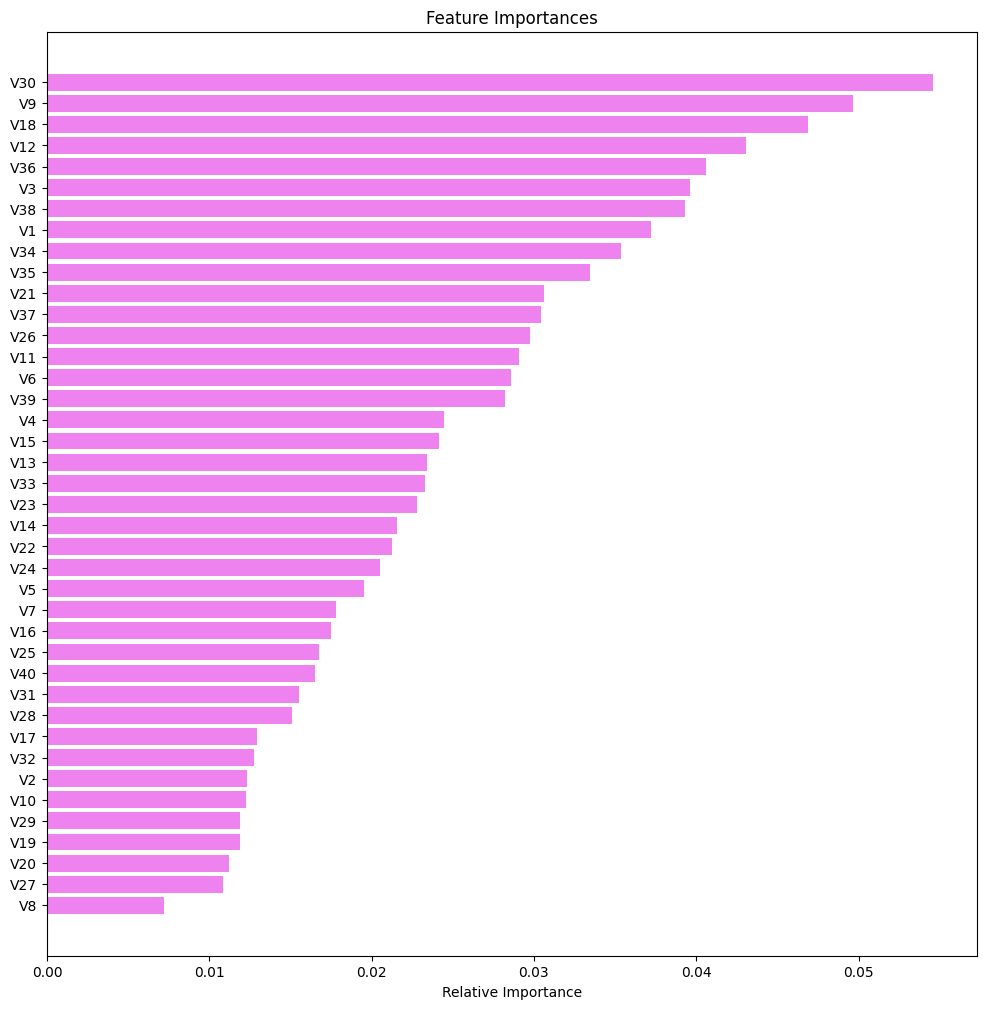

In [116]:
# Plot feature importances of best model on train set
feature_names = data_train.columns
importances =  tuned_ada.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()


####Observations

- V30, V9, V18, V12, and V36 have the highest feature importances to the ADABoost model tuned on oversampled data.


## Pipelines to build the final model


In [117]:
# Dividing test data into X1/Y1
X1 = data_test.drop(columns="Target", axis=1)
Y1 = data_test["Target"]
X1.shape

(5000, 40)

####Observations

- The test set has 5,000 rows.


In [118]:
# Create imputer instance
imputer = SimpleImputer(strategy="median")

# Impute missing values
X1 = imputer.fit_transform(X1)


In [119]:
# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)

X_over1, y_over1 = sm.fit_resample(X1, Y1)

In [120]:
# defining model
final_model_ada_over= AdaBoostClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.2, 0.05],
    "estimator": [DecisionTreeClassifier(max_depth=1, random_state=1),
                  DecisionTreeClassifier(max_depth=2, random_state=1),
                  DecisionTreeClassifier(max_depth=3, random_state=1),]}


# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=final_model_ada_over,
                                   param_distributions=param_grid,
                                   n_iter=50, 
                                   n_jobs=-1,
                                   scoring=scorer,
                                   cv=5,
                                   random_state=1)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_over1,y_over1)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 200, 'learning_rate': 0.2, 'estimator': DecisionTreeClassifier(max_depth=3, random_state=1)} with CV score=0.9764729406689792:


In [121]:
# Creating new pipeline with best parameters
final_ada_over = AdaBoostClassifier(
    n_estimators=200,
    learning_rate=0.2,
    estimator= DecisionTreeClassifier(max_depth=3, random_state=1))

# Fitting the model on oversampled data
final_ada_over.fit(X_over1, y_over1)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    random_state=1),
                   learning_rate=0.2, n_estimators=200)

In [122]:
# Check performance of final model
Pipeline_final_over = model_performance_classification_sklearn(final_ada_over, X_over1, y_over1)
Pipeline_final_over

,Accuracy,Recall,Precision,F1
0,1.000,1.000,1.000,1.000


In [123]:
# Check performance of final model on validation set
Pipeline_final_val_over= model_performance_classification_sklearn(final_ada_over, X_val, y_val)
Pipeline_final_val_over

,Accuracy,Recall,Precision,F1
0,0.977,0.809,0.784,0.796


In [124]:
# Create new instance for best model score and output as percentage 
test_score = final_ada_over.score(X_over1, y_over1)

print("Test set performance: {:.2f}%".format(test_score * 100))

Test set performance: 100.00%


# Business Insights and Conclusions


Based on the results and cost considerations for Renewind:

1. The model has high accuracy on the test set at 0.98. It correctly predicts 98% of failures. 
2. The recall score is 0.81, meaning the model correctly identifies 81% of failures. 
3. The model's precision score is 0.78, meaning the model avoids 78% of false positives.


A. The model's recall score needs to be improved. It correctly identifies 81% of failures. However, it misses approximately 19% of actual failures, leading to revenue loss as false negatives result in higher replacement costs since failures go undetected. Renewind can improve recall scores by identifying patterns or features that contribute to false negatives. 

B. The model's precision score is 0.78, meaning that out of all the instances predicted as failure, approximately 22% of instances are false positives. Lowering the number of false positives and increasing the precision score of the model will reduce inspection costs. The model's precision score should be improved in confluence with the model's recall score to maintain balance. Renewind can examine adjusting the model's threshold to find a balance between precision and recall. 

C. Implement a feedback loop with key stakeholders. Gather feedback on the model's performance through continuous monitoring to identify problems over time and adjust/update the model. 

D. Perform a cost-benefit analyssis to determine the threshold for the appropriate tradeoff between inspection costs, repair costs, and replacement costs. Use this analysis to drive the model building process and further improve its accuracy. 



